In [2]:
'''
 Load data. Input files defined in yaml files (destest_bpz.yaml, destest_metacal.yaml,destest_gold.yaml)
 It requires destest : 
 https://github.com/des-science/destest
 
 catalogs (to be specified in the yaml files):
 

 I didn't manage to run the destest Calibrator. This means that if you directly load R1 and R2 from the catalog,
 they are only the respones of the sample and neglect the response of the selection (which is usually few %).
 The solution I got was to load the columns without selection (uncut=True)
 and apply the response and selection by myself.
'''



import sys
from routines import *
import numpy as np



# ******************************************************************
#                              INPUT
# ******************************************************************
nside = 1024  


# output folders ***************
name_folder_x = '/global/cscratch1/sd/mgatti/Cosmic_shear/Additive_mastercat_04_20/'


if not os.path.exists(name_folder_x):
    os.mkdir(name_folder_x)

print ("done")

/global/homes/m/mgatti/.conda/envs/myenv_up/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


done


# Load Catalog

In [11]:
import yaml
import destest
import treecorr


# basic dict props
destest_dict_ = {
    'output_exists' : True,
    'use_mpi'       : False,
    'source'        : 'hdf5',
    'dg'            : 0.01
    }

# Populates a full destest yaml dict for each catalog selection based on the limited catalog input info provided in the common cats.yaml file
def create_destest_yaml( params, name, cal_type, group, table, select_path ):
    """
    Creates the input dictionary structure from a passed dictionary rather than reading froma yaml file.
    """

    destest_dict = destest_dict_.copy()
    destest_dict['load_cache'] = params['load_cache']
    destest_dict['output'] = params['output']
    destest_dict['name'] = name
    destest_dict['filename'] = params['datafile']
    destest_dict['param_file'] = params['param_file']
    destest_dict['cal_type'] = cal_type
    destest_dict['group'] = group
    destest_dict['table'] = table
    destest_dict['select_path'] = select_path
    destest_dict['e'] = ['e_1','e_2']
    destest_dict['Rg'] = ['R11','R22']
    destest_dict['w'] = 'weight'

    return destest_dict

# Build selector (and calibrator) classes from destest for the catalog.
def load_catalog(pipe_params, name, cal_type, group, table, select_path, inherit=None, return_calibrator=None):
    """
    Loads data access and calibration classes from destest for a given yaml setup file.
    """

    # Input yaml file defining catalog
    params = create_destest_yaml(pipe_params, name, cal_type, group, table, select_path)

    # Load destest source class to manage access to file
    source = destest.H5Source(params)

    # Load destest selector class to manage access to data in a structured way
    if inherit is None:
        sel = destest.Selector(params,source)
    else:
        sel = destest.Selector(params,source,inherit=inherit)

    # Load destest calibrator class to manage calibration of the catalog
    if return_calibrator is not None:
        cal = return_calibrator(params,sel)
        return sel, cal
    else:
        return sel

# Read yaml file that defines all the catalog selections used
params = yaml.load(open('cats.yaml'))
params['param_file'] = 'cats.yaml'

# Source catalog
source_selector, source_calibrator = load_catalog(
    params, 'mcal', 'mcal', params['source_group'], params['source_table'], params['source_path'], return_calibrator=destest.MetaCalib)

# Gold catalog
gold_selector = load_catalog(
    params, 'gold', 'mcal', params['gold_group'], params['gold_table'], params['gold_path'], inherit=source_selector)

'''
# Redmagic catalog
lens_selector, lens_calibrator = load_catalog(
    params, 'rm', None, params['lens_group'], params['lens_table'], params['lens_path'], return_calibrator=destest.NoCalib)

# Mag lim catalog
alt_lens_selector, alt_lens_calibrator = load_catalog(
    params, 'maglim', None, params['alt_lens_group'], params['alt_lens_table'], params['alt_lens_path'], return_calibrator=destest.NoCalib)



# Redmagic random catalog
ran_selector = load_catalog(
    params, 'ran', None, params['ran_group'], params['ran_table'], params['ran_path'])



# Get some source photo-z binning information, cut to range 0.1<z_mean<1.3                                                  
for i in range(1):
    print (i)
    pzbin = pz_selector.get_col('bhat') # 5-tuple for metacal (un)sheared versions                                         
    mask = [pzbin[j] == i for j in range(5)] # First tomographic bin                                                               
    # Note that get_col() returns a tuple. If its a catalog like gold, it will have length 0, but for something like metacal, it will have length 5 (in the order of the table variable list passed in cats.yaml, i.e., 'unsheared', 'sheared_1p', 'sheared_1m', 'sheared_2p', 'sheared_2m')                                                               
    # Note that get_col() applies the index mask specified by the 'path' variable in the cats.yaml file automatically.         # Get responses (c, which doesn't exist for our catalogs), and weights                                                      
    R1,c,w = source_calibrator.calibrate('e_1', mask=mask,return_full_w=True) # Optionally pass an additional mask to use when calculating the selection response. The returned R1 is <Rg_1 + Rs_1>. To get an array of R's, use return_wRg=True to get [Rg_1+Rg_2]/2 for each object or return_wRgS=True to include the selection response. return_full=True returns the non-component-averaged version of the full response.
    print len(w)
    #R2,c,w = source_calibrator.calibrate('e_2', mask=mask)
    #print(R2,c,w)
    
    g1=source_selector.get_col('e_1')[0]
    print(len(w),len(g1[0][mask[0]]))
    
    wa = source_calibrator.calibrate('e_1', mask=mask,return_full_w=True,weight_only=True) # Optionally pass an additional mask to use when calculating the selection response. The returned R1 is <Rg_1 + Rs_1>. To get an array of R's, use return_wRg=True to get [Rg_1+Rg_2]/2 for each object or return_wRgS=True to include the selection response. return_full=True returns the non-component-averaged version of the full response.
    print (len(wa))
   
    #g2=source_selector.get_col('e_2')[0]



'''
R1,c,w = source_calibrator.calibrate('e_1') # Optionally pass an additional mask to use when calculating the selection response. The returned R1 is <Rg_1 + Rs_1>. To get an array of R's, use return_wRg=True to get [Rg_1+Rg_2]/2 for each object or return_wRgS=True to include the selection response. return_full=True returns the non-component-averaged version of the full response.
R2,c,w = source_calibrator.calibrate('e_2')


# Load ra,dec from gold catalog
ra  = gold_selector.get_col('ra')[0]
dec = gold_selector.get_col('dec')[0]

# Get e1,e2 
g1=source_selector.get_col('e_1')[0]
g2=source_selector.get_col('e_2')[0]




destest.py:32: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/global/homes/m/mgatti/.conda/envs/myenv_up/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/global/homes/m/mgatti/.conda/envs/myenv_up/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/global/u2/m/mgatti/.conda/envs/myenv_up/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/global/homes/m/mgatti/.conda/envs/myenv_up/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/global/homes/m/mgatti/.conda/envs/myenv_up/lib/python2.7/si

IOError: [Errno 2] No such file or directory: 'cats.yaml'

In [ ]:
sample_dict = dict()
sample_dict['w']  = source_calibrator.calibrate('e_1',weight_only=True) # Optionally pass an additional mask to use when calculating the selection response. The returned R1 is <Rg_1 + Rs_1>. To get an array of R's, use return_wRg=True to get [Rg_1+Rg_2]/2 for each object or return_wRgS=True to include the selection response. return_full=True returns the non-component-averaged version of the full response.
sample_dict['e1'] = (g1 - np.mean(g1*w)/np.mean(w))/R1
sample_dict['e2'] = (g2 - np.mean(g2*w)/np.mean(w))/R2

sample_dict['psf_size'] = source_selector.get_col('psf_T')[0]
sample_dict['psf_size'] = np.array(master['catalog']['metacal']['unsheared']['psf_T'])[select_metacal]
sample_dict['snr'] = np.array(master['catalog']['metacal']['unsheared']['snr'])[select_metacal]
sample_dict['psf_e1'] = np.array(master['catalog']['metacal']['unsheared']['psf_e1'])[select_metacal]
sample_dict['psf_e2'] = np.array(master['catalog']['metacal']['unsheared']['psf_e2'])[select_metacal]
sample_dict['bpz_zmean'] = np.array(master['catalog']['bpz']['unsheared']['zmean_sof'])[select_metacal]
sample_dict['bpz_zmc'] = np.array(master['catalog']['bpz']['unsheared']['zmc_sof'])[select_metacal]
sample_dict['r-i'] =np.array(master['catalog']['metacal']['unsheared']['flux_r'])[select_metacal]-np.array(master['catalog']['metacal']['unsheared']['flux_i'])[select_metacal]
sample_dict['ebv'] =np.array(master['catalog']['gold']['ebv_sfd98'])[select_metacal]
sample_dict['size_ratio'] = np.array(master['catalog']['metacal']['unsheared']['size_ratio'])[select_metacal]
idx = np.array(master['catalog']['metacal']['unsheared']['coadd_object_id'])[select_metacal]
sample_dict['idx'] = idx

jj_reg = np.array(master['regions']['catalog']['gold'][u'region'])[select_metacal]
id_gold = np.array(master['catalog']['gold']['coadd_object_id'])[select_metacal]

mask_id = np.in1d(id_gold,idx)

id_gold_match = id_gold[mask_id]
jj_reg_match = jj_reg[mask_id]
sample_dict.update({'jk' : jj_reg_match })



def apply_random_rotation(e1_in, e2_in):
    np.random.seed() # CRITICAL in multiple processes !
    rot_angle = np.random.rand(len(e1_in))*2*np.pi #no need for 2?
    cos = np.cos(rot_angle)
    sin = np.sin(rot_angle)
    e1_out = + e1_in * cos + e2_in * sin
    e2_out = - e1_in * sin + e2_in * cos
    return e1_out, e2_out
e1_out, e2_out = apply_random_rotation(sample_dict["e1"], sample_dict["e2"])
sample_dict.update({'e1_rndm_rot' : e1_out})
sample_dict.update({'e2_rndm_rot' : e2_out})



desy3_map = np.zeros(hp.nside2npix(nside))

pix1 = convert_to_pix_coord(ra_master,dec_master, nside=nside)
unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
desy3_map[unique_pix1] += np.bincount(idx_rep1, weights=np.ones(len(pix1)))
mas_desy3 = desy3_map!=0.



In [5]:
from multiprocessing import Pool,sharedctypes
from functools import partial
from contextlib import closing


import matplotlib.pyplot as plt
import numpy as np
import pyfits as pf
import healpy as hp
import h5py as h5

import os
import sys


bins = ['all']
nside = 1024



# read File *******

File_data = "/project/projectdirs/des/www/y3_cats/Y3_mastercat_03_31_20.h5"
master = h5.File(File_data,'r')


select_metacal  = np.array(master['index']['select_shape']) # gold + mcal
select_all  = np.array(master['index']['select'])  # photo + gold + mcal


select_metacal_1p  = np.array(master['index']['select_shape_1p'])
select_metacal_1m  = np.array(master['index']['select_shape_1m'])
select_metacal_2p  = np.array(master['index']['select_shape_2p'])
select_metacal_2m  = np.array(master['index']['select_shape_2m'])

ra_master = np.array(master['catalog']['metacal']['unsheared']['ra'])
dec_master =  np.array(master['catalog']['metacal']['unsheared']['dec'])

mmm = dict()

cat = dict()

e1 = np.array(master['catalog']['metacal']['unsheared']['e_1'])
e2 = np.array(master['catalog']['metacal']['unsheared']['e_2'])
e1p = np.array(master['catalog']['metacal']['sheared_1p']['e_1'])[select_metacal]
e1m = np.array(master['catalog']['metacal']['sheared_1m']['e_1'])[select_metacal]
e2p = np.array(master['catalog']['metacal']['sheared_2p']['e_2'])[select_metacal]
e2m = np.array(master['catalog']['metacal']['sheared_2m']['e_2'])[select_metacal]

# compute response: 
dgamma = 2. * 0.01
R11_1 = (np.mean(e1p) - np.mean(e1m) + np.mean(
e1[select_metacal_1p]) - np.mean(
e1[select_metacal_1m]))/ dgamma
R22_1 = (np.mean(e2p) - np.mean(e2m) + np.mean(
e2[select_metacal_2p]) - np.mean(
e2[select_metacal_2m])) / dgamma


print R11_1
print R22_1

e1 = np.array(master['catalog']['metacal']['unsheared']['e_1'])[select_metacal]/R11_1
e2 = np.array(master['catalog']['metacal']['unsheared']['e_2'])[select_metacal]/R22_1

e1= e1-np.mean(e1)
e2= e2-np.mean(e2)
    
sample_dict = dict()
sample_dict['ra'] = ra_master[select_metacal]
sample_dict['dec'] = dec_master[select_metacal]
sample_dict['e1'] = e1
sample_dict['e2'] = e2


sample_dict['psf_size'] = np.array(master['catalog']['metacal']['unsheared']['psf_T'])[select_metacal]
sample_dict['snr'] = np.array(master['catalog']['metacal']['unsheared']['snr'])[select_metacal]
sample_dict['psf_e1'] = np.array(master['catalog']['metacal']['unsheared']['psf_e1'])[select_metacal]
sample_dict['psf_e2'] = np.array(master['catalog']['metacal']['unsheared']['psf_e2'])[select_metacal]
sample_dict['bpz_zmean'] = np.array(master['catalog']['bpz']['unsheared']['zmean_sof'])[select_metacal]
sample_dict['bpz_zmc'] = np.array(master['catalog']['bpz']['unsheared']['zmc_sof'])[select_metacal]
sample_dict['r-i'] =np.array(master['catalog']['metacal']['unsheared']['flux_r'])[select_metacal]-np.array(master['catalog']['metacal']['unsheared']['flux_i'])[select_metacal]
sample_dict['ebv'] =np.array(master['catalog']['gold']['ebv_sfd98'])[select_metacal]
sample_dict['size_ratio'] = np.array(master['catalog']['metacal']['unsheared']['size_ratio'])[select_metacal]
idx = np.array(master['catalog']['metacal']['unsheared']['coadd_object_id'])[select_metacal]
sample_dict['idx'] = idx

jj_reg = np.array(master['regions']['catalog']['gold'][u'region'])[select_metacal]
id_gold = np.array(master['catalog']['gold']['coadd_object_id'])[select_metacal]

mask_id = np.in1d(id_gold,idx)

id_gold_match = id_gold[mask_id]
jj_reg_match = jj_reg[mask_id]
sample_dict.update({'jk' : jj_reg_match })



def apply_random_rotation(e1_in, e2_in):
    np.random.seed() # CRITICAL in multiple processes !
    rot_angle = np.random.rand(len(e1_in))*2*np.pi #no need for 2?
    cos = np.cos(rot_angle)
    sin = np.sin(rot_angle)
    e1_out = + e1_in * cos + e2_in * sin
    e2_out = - e1_in * sin + e2_in * cos
    return e1_out, e2_out
e1_out, e2_out = apply_random_rotation(sample_dict["e1"], sample_dict["e2"])
sample_dict.update({'e1_rndm_rot' : e1_out})
sample_dict.update({'e2_rndm_rot' : e2_out})



desy3_map = np.zeros(hp.nside2npix(nside))

pix1 = convert_to_pix_coord(ra_master,dec_master, nside=nside)
unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
desy3_map[unique_pix1] += np.bincount(idx_rep1, weights=np.ones(len(pix1)))
mas_desy3 = desy3_map!=0.





0.5892019746692672
0.5898403379992099


# Load stars

done


/global/homes/m/mgatti/.conda/envs/myenv_up/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


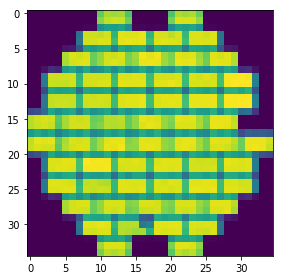

In [6]:
%matplotlib inline
# Load reserved stars and make grids
path_qq = "/global/homes/m/mjarvis/desdata/users/mjarvis/y3a1-v29/psf_y3a1-v29.fits"
output = name_folder_x



prova =  field_methods()
fact = 0.05703422

mute11 = pf.open(path_qq)
dd_qq = mute11[1].data

bb = mute11[1].data['band'] 
mag = mute11[1].data['mag']

maks=((bb =='i') | (bb =='r') | (bb =='z')) & (mag<20)
exp = np.array(mute11[1].data['exp'][maks])
bb=bb[maks]
mag=mag[maks]

ras  = mute11[1].data['ra'][maks]
decs  = mute11[1].data['dec'][maks]
p1  = mute11[1].data['obs_e1'][maks]
p2  = mute11[1].data['obs_e2'][maks]
q1  = (mute11[1].data['obs_e1']-mute11[1].data['piff_e1'])[maks]
q2  = (mute11[1].data['obs_e2']-mute11[1].data['piff_e2'])[maks]
t1  = (mute11[1].data['piff_e1']*((mute11[1].data['obs_T ']-mute11[1].data['piff_T'])/mute11[1].data['obs_T']))[maks]
t2  = (mute11[1].data['piff_e2']*((mute11[1].data['obs_T ']-mute11[1].data['piff_T'])/mute11[1].data['obs_T']))[maks]


print "done"



min_x = 0. 
max_x = 0.
min_y = 0.
max_y = 0.
for i in range(62):
    min_x = (min([min((prova.ccd_corners()/fact)[i][:,0]),min_x]))
    max_x = (max([max((prova.ccd_corners()/fact)[i][:,0]),max_x]))
    min_y = (min([min((prova.ccd_corners()/fact)[i][:,1]),min_y]))
    max_y = (max([max((prova.ccd_corners()/fact)[i][:,1]),max_y]))
    
    
    

grid_res = 35
gridded_p1 = np.zeros((grid_res,grid_res))
gridded_p2 = np.zeros((grid_res,grid_res))
gridded_q1 = np.zeros((grid_res,grid_res))
gridded_q2 = np.zeros((grid_res,grid_res))
gridded_t1 = np.zeros((grid_res,grid_res))
gridded_t2 = np.zeros((grid_res,grid_res))
gridded_nn = np.zeros((grid_res,grid_res))
dx = (max_x-min_x)/grid_res
dy = (max_y-min_y)/grid_res


if not os.path.exists(output+"ap2_rs_{0}.pkl".format(grid_res)):
    for i in range(grid_res):
        mask1 = (dd_qq['fov_x'][maks]>(dx*i+min_x)) & (dd_qq['fov_x'][maks]<(dx*(i+1)+min_x))
        for j in range(grid_res):
            mask = mask1 & (dd_qq['fov_y'][maks]>(dy*j+min_y)) & (dd_qq['fov_y'][maks]<(dy*(j+1)+min_y))
            if len(dd_qq['fov_y'][maks][mask])>0:
                gridded_q1[i,j] = np.mean(q1[mask])
                gridded_q2[i,j] = np.mean(q2[mask])
                gridded_t1[i,j] = np.mean(t1[mask])
                gridded_t2[i,j] = np.mean(t2[mask]) 
                gridded_p1[i,j] = np.mean(p1[mask])
                gridded_p2[i,j] = np.mean(p2[mask])
                gridded_nn[i,j] = len(q1[mask])
    save_obj(output+"ann_rs_{0}".format(grid_res),gridded_nn)
    save_obj(output+"aq1_rs_{0}".format(grid_res),gridded_q1)
    save_obj(output+"aq2_rs_{0}".format(grid_res),gridded_q2)
    save_obj(output+"at1_rs_{0}".format(grid_res),gridded_t1)
    save_obj(output+"at2_rs_{0}".format(grid_res),gridded_t2)
    save_obj(output+"ap1_rs_{0}".format(grid_res),gridded_p1)
    save_obj(output+"ap2_rs_{0}".format(grid_res),gridded_p2)
    
    gridded_q1 = load_obj(output+"aq1_rs_{0}".format(grid_res))#,gridded_q1)
    gridded_q2 = load_obj(output+"aq2_rs_{0}".format(grid_res))#,gridded_q2)
    gridded_t1 = load_obj(output+"at1_rs_{0}".format(grid_res))#,gridded_t1)
    gridded_t2 = load_obj(output+"at2_rs_{0}".format(grid_res))#,gridded_t2
    gridded_p1 = load_obj(output+"ap1_rs_{0}".format(grid_res))#,gridded_t1)
    gridded_p2 = load_obj(output+"ap2_rs_{0}".format(grid_res))#,gridded_t2

else:
    gridded_nn = load_obj(output+"ann_rs_{0}".format(grid_res))
    gridded_q1 = load_obj(output+"aq1_rs_{0}".format(grid_res))#,gridded_q1)
    gridded_q2 = load_obj(output+"aq2_rs_{0}".format(grid_res))#,gridded_q2)
    gridded_t1 = load_obj(output+"at1_rs_{0}".format(grid_res))#,gridded_t1)
    gridded_t2 = load_obj(output+"at2_rs_{0}".format(grid_res))#,gridded_t2
    gridded_p1 = load_obj(output+"ap1_rs_{0}".format(grid_res))#,gridded_t1)
    gridded_p2 = load_obj(output+"ap2_rs_{0}".format(grid_res))#,gridded_t2




import matplotlib.pyplot as plt
plt.imshow(gridded_nn)
plt.show()


# Match

In [ ]:
"""
This assigns residuals to every galaxy exposures based on their position in focal plane coordinates.
Then, It averages over exposure and creates a catalog to be matched later with the mastercat.


"""
# multiprocessing to do the matching faster.
agents = 30

# Metacl files from Erin.
path_mcal  = "/global/cscratch1/sd/mgatti/Cosmic_shear/metacal/*"
path_mcal = "/global/cscratch1/sd/troxel/mcal_y3_vf/*"
#path to the output
path_matched_catalog = "/global/cscratch1/sd/mgatti/Cosmic_shear/shape_systematics/qt_to_metacal1_newuberseg.csv"
path_matched_catalog1 = "/global/cscratch1/sd/mgatti/Cosmic_shear/shape_systematics/qt_to_metacal1_newuberseg1.csv"
path_matched_catalog2 = "/global/cscratch1/sd/mgatti/Cosmic_shear/shape_systematics/qt_to_metacal1_newuberseg2.csv"


path_matched_catalog = "/global/cscratch1/sd/mgatti/Cosmic_shear/Additive/Bqt_to_metacal1_newuberseg.csv"
path_matched_catalog1 = "/global/cscratch1/sd/mgatti/Cosmic_shear/Additive/Bqt_to_metacal1_newuberseg1.csv"
path_matched_catalog2 = "/global/cscratch1/sd/mgatti/Cosmic_shear/Additive/Bqt_to_metacal1_newuberseg2.csv"



#https://www.cosmo.bnl.gov/Private/gpfs/workarea/desdata/wlpipe/y3v02-mcal-003/output/

from multiprocessing import Pool,sharedctypes
from functools import partial
from contextlib import closing
import pyfits as pf
import numpy
import pandas as pd
import os
import timeit
start = timeit.default_timer()

import glob
files = (glob.glob(path_mcal))



def runit(i):
    try:
        cc = []
        oo = []
        mute = pf.open(files[i])
        selection = (mute[1].data['mcal_s2n_r']>10.) &(mute[1].data['mcal_s2n_r']<100.) & (mute[1].data['flags']==0) & (mute[1].data['mcal_T']/mute[1].data['mcal_Tpsf']>0.5)

        #match entries
        mask = np.in1d(mute[2].data['id'],mute[1].data['id'][selection])

        #conversion to pixel coordinates
        chip = [np.int(xx.split("_")[2].split("c")[1])-1 for xx in mute[2].data['image_id'][mask]]
        exposure = [np.int(xx.split("_")[0].split("D00")[1]) for xx in mute[2].data['image_id'][mask]]


        fact = 0.05703422
        x1,y1 = prova.ccd_to_field(chip,mute[2].data['orig_col' ][mask ],mute[2].data['orig_row'][mask])
        y1/=fact
        x1/=fact
        ind1,ind2 = np.array((x1-min_x)/dx).astype(int),np.array((y1-min_y)/dy).astype(int)
        q1 = np.array([gridded_q1[ind1[ixx],ind2[ixx]] for ixx in range(len(ind1))])
        q2 = np.array([gridded_q2[ind1[ixx],ind2[ixx]] for ixx in range(len(ind1))])
        t1 = np.array([gridded_t1[ind1[ixx],ind2[ixx]] for ixx in range(len(ind1))])
        t2 = np.array([gridded_t2[ind1[ixx],ind2[ixx]] for ixx in range(len(ind1))])
        p1 = np.array([gridded_p1[ind1[ixx],ind2[ixx]] for ixx in range(len(ind1))])
        p2 = np.array([gridded_p2[ind1[ixx],ind2[ixx]] for ixx in range(len(ind1))])
        mask_outchip = q1 !=0.
        dd =  {'x1':np.array(x1[mask_outchip]),'y1':np.array(y1[mask_outchip]),
               'q1':np.array(q1[mask_outchip]),'q2':np.array(q2[mask_outchip]),
               'p1':np.array(p1[mask_outchip]),'p2':np.array(p2[mask_outchip]),
               't1':np.array(t1[mask_outchip]),'t2':np.array(t2[mask_outchip]),'exp':np.array(exposure)[mask_outchip]}
        c1 = pd.DataFrame(data =dd,index = np.array(mute[2].data['id'][mask][mask_outchip]))
        c1 = c1.dropna()
        c1_compressed = c1.groupby(c1.index).mean()

        dd = {'e1':np.array(mute[1].data['mcal_g  '][selection,0]).byteswap().newbyteorder()
              ,'e2':np.array(mute[1].data['mcal_g  '][selection,1]).byteswap().newbyteorder()}
        orig1 = pd.DataFrame(data =dd, index = np.array(mute[1].data['id'][selection]))

        to_join_mastercat = orig1.join(c1_compressed)
        cosmichshearfov_cat = orig1.join(c1)
        cosmichshearfov_cat =cosmichshearfov_cat.drop(['p1','p2','q1','q2','t1','t2'], axis=1)
        cc.append(cosmichshearfov_cat)
        oo.append(to_join_mastercat)
        #return  _,oo,len(oo[0])
        return  _,oo,len(oo[0])
    except:
        print files[i]
        
        
if not os.path.exists(path_matched_catalog):
#if 1==1:
    if not os.path.exists(path_matched_catalog1):
        run_done = []
        numero = range((len(files[:5000])))
        with closing(Pool(processes=agents)) as pool:
            run_done.append(pool.map(partial(runit),numero))
            #mm = (pool.map(partial(runit),numero))
            #cc1.append(mm[0])
            #oo1.append(mm[1])


        s = []
        for i in range(len(files)):
            try:
                s.append(run_done[0][i][1][0])
            except:
                pass#
        ccf1 = pd.concat(s)

        ccf1.to_csv(path_matched_catalog1 )
    else:
        ccf1=pd.read_csv(path_matched_catalog1 )


    if not os.path.exists(path_matched_catalog2):
        run_done = []
        numero = range(5000,(len(files[5000:])))
        with closing(Pool(processes=agents)) as pool:
            run_done.append(pool.map(partial(runit),numero))
            #mm = (pool.map(partial(runit),numero))
            #cc1.append(mm[0])
            #oo1.append(mm[1])


        s = []
        for i in range(len(files)):
            try:
                s.append(run_done[0][i][1][0])
            except:
                pass#
        ccf2 = pd.concat(s)

        ccf2.to_csv(path_matched_catalog2 )
    else:
        ccf2=pd.read_csv(path_matched_catalog2)
    print ("done")
    ccf=pd.concat([ccf1,ccf2])
    ccf.to_csv(path_matched_catalog)
else:
    ccf=pd.read_csv(path_matched_catalog)
#ccf=ccf.set_index('Unnamed: 0.1')
print "done"



import pandas as pd
ccf1 = ccf.set_index("Unnamed: 0")
for key in ccf1.keys():
    try:
        ccf1[key] = ccf1[key].byteswap().newbyteorder()
    except:
        pass

dd ={'e1x':sample_dict['e1'].byteswap().newbyteorder()}
mastercat = pd.DataFrame(data =dd, index = sample_dict['idx'])
joined = mastercat.join(ccf1)
sample_dict.update({'Ap1' : joined['p1']})
sample_dict.update({'Ap2' : joined['p2']})
sample_dict.update({'Aq1' : joined['q1']})
sample_dict.update({'Aq2' : joined['q2']})
sample_dict.update({'At1' : joined['t1']})
sample_dict.update({'At2' : joined['t2']})
print ("done")

In [16]:
mass = (ccf1['e2']==ccf1['e2']) & (ccf1['q2']==ccf1['q2'])
mut = np.polyfit(ccf1['e2'][mass],ccf1['q2'][mass],1)
print mut

[ 1.28454373e-06 -1.58594662e-05]


In [6]:
np

<module 'numpy' from '/global/homes/m/mgatti/.conda/envs/myenv_up/lib/python2.7/site-packages/numpy/__init__.pyc'>

# map making

In [2]:
z_column='snr'
dict_tot = dict()
for ii,z_min in enumerate(z_min_arr):
    z_max = z_max_arr[ii]
    print " Bin: ",z_min,z_max
    name_foder =name_folder_x+'_{0}_{1}/'.format(z_min,z_max)

    if not os.path.exists(name_foder):    
        os.mkdir(name_foder)


    if not os.path.exists(name_foder+'/maps_y3.pkl'.format(z_min,z_max)):

        selection_z = np.zeros(len(sample_dict['ra']))
        selection_z += 4
        select_bin_1 = (sample_dict[z_column] > z_min) & (sample_dict[z_column] < z_max)
        selection_z[select_bin_1] += 1
        mask_1_bin = np.array([str(bin(int(selection_z[i]))[4]) == '1' for i in range(len(selection_z))])
        mask_2_bin = np.array([str(bin(int(selection_z[i]))[4]) == '1' for i in range(len(selection_z))])


        #initialize maps ************************
        #mask_photo_z = (sample_dict['bpz_mean'] > z_min) & (sample_dict['bpz_mean'] < z_max) & mask_total
        n_map = np.zeros(hp.nside2npix(nside))
        n_map1 = np.zeros(hp.nside2npix(nside))
        e1_map = np.zeros(hp.nside2npix(nside))
        e2_map = np.zeros(hp.nside2npix(nside))
        e1_rndm_map = np.zeros(hp.nside2npix(nside))
        e2_rndm_map = np.zeros(hp.nside2npix(nside))
        e1_rndm_map_2 = np.zeros(hp.nside2npix(nside))
        e2_rndm_map_2 = np.zeros(hp.nside2npix(nside))
        
        psf_e1_map = np.zeros(hp.nside2npix(nside))
        psf_e2_map = np.zeros(hp.nside2npix(nside))
        snr_map = np.zeros(hp.nside2npix(nside))
        psf_size_map = np.zeros(hp.nside2npix(nside))
        size_ratio_map = np.zeros(hp.nside2npix(nside))
        ebv_map = np.zeros(hp.nside2npix(nside))
        color_map = np.zeros(hp.nside2npix(nside))                  
        q1_map = np.zeros(hp.nside2npix(nside))
        q2_map = np.zeros(hp.nside2npix(nside))
        p1_map = np.zeros(hp.nside2npix(nside))
        p2_map = np.zeros(hp.nside2npix(nside))
        t1_map = np.zeros(hp.nside2npix(nside))
        t2_map = np.zeros(hp.nside2npix(nside))  

        bpz_zmean = np.zeros(hp.nside2npix(nside)) 
        bpz_zmc = np.zeros(hp.nside2npix(nside)) 
        # convert to map *********************************************************

        pix = convert_to_pix_coord(sample_dict['ra'][ mask_1_bin], sample_dict['dec'][ mask_1_bin], nside=nside)

        unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)
        n_map[unique_pix] += np.bincount(idx_rep, weights=np.ones(len(pix)))
        e1_map[unique_pix] += np.bincount(idx_rep, weights= sample_dict['e1'][mask_1_bin])
        e2_map[unique_pix] += np.bincount(idx_rep, weights= sample_dict['e2'][mask_1_bin])
        e1_rndm_map_2[unique_pix] += np.bincount(idx_rep, weights= sample_dict['e1_rndm_rot'][mask_1_bin])
        e2_rndm_map_2[unique_pix] += np.bincount(idx_rep, weights= sample_dict['e2_rndm_rot'][mask_1_bin])
 
        psf_e1_map[unique_pix] += np.bincount(idx_rep, weights = sample_dict['psf_e1'][mask_1_bin])
        psf_e2_map[unique_pix] += np.bincount(idx_rep, weights = sample_dict['psf_e2'][mask_1_bin])
        snr_map[unique_pix] += np.bincount(idx_rep, weights = sample_dict['snr'][mask_1_bin])
        size_ratio_map[unique_pix] += np.bincount(idx_rep, weights = sample_dict['size_ratio'][mask_1_bin])
        psf_size_map[unique_pix] += np.bincount(idx_rep, weights = sample_dict['psf_size'][mask_1_bin])
        
        color_map[unique_pix] += np.bincount(idx_rep, weights = sample_dict['r-i'][mask_1_bin])
        ebv_map[unique_pix] += np.bincount(idx_rep, weights = sample_dict['ebv'][mask_1_bin])
            
            
        bpz_zmean[unique_pix] += np.bincount(idx_rep, weights = sample_dict['bpz_zmean'][mask_1_bin])
        bpz_zmc[unique_pix] += np.bincount(idx_rep, weights = sample_dict['bpz_zmc'][mask_1_bin])
        
        
        
        add_mask = sample_dict['q1']**2>-0.1
        pix1 = convert_to_pix_coord(sample_dict['ra'][mask_1_bin &add_mask ], sample_dict['dec'][mask_1_bin &add_mask], nside=nside)

        unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
        n_map1[unique_pix1] += np.bincount(idx_rep1, weights=np.ones(len(pix1)))
        
        q1_map[unique_pix1] += np.bincount(idx_rep1, weights = sample_dict['q1'][mask_1_bin &add_mask ])
        q2_map[unique_pix1] += np.bincount(idx_rep1, weights = sample_dict['q2'][ mask_1_bin &add_mask])
        t1_map[unique_pix1] += np.bincount(idx_rep1, weights = sample_dict['t1'][ mask_1_bin &add_mask])
        t2_map[unique_pix1] += np.bincount(idx_rep1, weights = sample_dict['t2'][ mask_1_bin &add_mask])
        p1_map[unique_pix1] += np.bincount(idx_rep1, weights = sample_dict['p1'][ mask_1_bin &add_mask])
        p2_map[unique_pix1] += np.bincount(idx_rep1, weights = sample_dict['p2'][ mask_1_bin &add_mask])
                       


        mask_sims = n_map != 0.
        e1_map[mask_sims]  = e1_map[mask_sims]/n_map[mask_sims]
        e2_map[mask_sims] = e2_map[mask_sims] / n_map[mask_sims]
        e1_rndm_map_2[mask_sims]  = e1_rndm_map_2[mask_sims]/n_map[mask_sims]
        e2_rndm_map_2[mask_sims] = e2_rndm_map_2[mask_sims] / n_map[mask_sims]

        psf_e1_map[mask_sims] = psf_e1_map[mask_sims]/n_map[mask_sims]
        psf_e2_map[mask_sims] = psf_e2_map[mask_sims]/n_map[mask_sims]
        snr_map[mask_sims] = snr_map[mask_sims]/n_map[mask_sims]
        size_ratio_map[mask_sims] = size_ratio_map[mask_sims] /n_map[mask_sims]
        psf_size_map[mask_sims] = psf_size_map[mask_sims]/n_map[mask_sims]
        color_map[mask_sims] = color_map[mask_sims] /n_map[mask_sims]
        ebv_map[mask_sims] = ebv_map[mask_sims]/n_map[mask_sims]
        bpz_zmean[mask_sims] = bpz_zmean[mask_sims]/n_map[mask_sims]
        bpz_zmc[mask_sims] = bpz_zmc[mask_sims]/n_map[mask_sims]
    
        mask_sims = n_map1 != 0.
        q1_map[mask_sims] = q1_map[mask_sims]/n_map1[mask_sims]
        q2_map[mask_sims] = q2_map[mask_sims]/n_map1[mask_sims]
        t1_map[mask_sims] = t1_map[mask_sims]/n_map1[mask_sims]
        t2_map[mask_sims] = t2_map[mask_sims]/n_map1[mask_sims]
        p1_map[mask_sims] = p1_map[mask_sims]/n_map1[mask_sims]
        p2_map[mask_sims] = p2_map[mask_sims]/n_map1[mask_sims]

        
        plt.hist(sample_dict['bpz_zmc'][mask_1_bin],bins = np.linspace(0.,2.,200),histtype='step')
        plt.savefig(name_foder+'/z_distr.png')
      
        # save maps *****************************************
        sample_map = dict()
        sample_map.update({'n' : n_map})
        sample_map.update({'e1' : e1_map})
        sample_map.update({'e2' : e2_map})
        sample_map.update({'e1_rndm_rot' :  e1_rndm_map_2})
        sample_map.update({'e2_rndm_rot' :  e2_rndm_map_2})


        sample_map.update({'psf_e1' : psf_e1_map})
        sample_map.update({'psf_e2' : psf_e2_map})
        sample_map.update({'snr' : snr_map})
        sample_map.update({'psf_size' : psf_size_map})
        sample_map.update({'size_ratio' : size_ratio_map})
        sample_map.update({'r-i' : color_map})
        sample_map.update({'ebv' : ebv_map})  
        sample_map.update({'q1' : q1_map})   
        sample_map.update({'q2' : q2_map})   
        sample_map.update({'t1' : t1_map})   
        sample_map.update({'t2' : t2_map})   
        sample_map.update({'p1' : p1_map})   
        sample_map.update({'p2' : p2_map})
        sample_map.update({'bpz_zmean' : bpz_zmean})   
        sample_map.update({'bpz_zmc' : bpz_zmc})   
        info = dict()
        info.update({'z_min' : z_min})
        info.update({'z_max' : z_max})
        info.update({'mask_sims' : sample_map['n'] != 0.})
        sample_map.update({'info' : info})
        save_obj(name_foder+'/maps_y3'.format(z_min,z_max),sample_map)
        dict_tot.update({'{0}_{1}'.format(z_min,z_max):sample_map})
    else:
        print "loading"
        sample_map = load_obj(name_foder+'/maps_y3'.format(z_min,z_max))
        dict_tot.update({'{0}_{1}'.format(z_min,z_max):sample_map})

print 'done'


 Bin:  0 500
loading
done


# Load Y1 and make maps!

In [8]:
import pyfits as pf
path_y1 = '/global/cscratch1/sd/mgatti/Cosmic_shear/mcal-y1a1-combined-riz-unblind-v4-matched.fits' 
mute_y1 = pf.open(path_y1)    
mute_y1[1].header
sample_dict_y1 = dict()
sample_dict_y1['ra'] = mute_y1[1].data['ra']
sample_dict_y1['dec'] = mute_y1[1].data['dec']
sample_dict_y1['e1'] = mute_y1[1].data['e1']
sample_dict_y1['e2'] = mute_y1[1].data['e2']
sample_dict_y1['snr'] = mute_y1[1].data['snr']
sample_dict_y1['psf_e1'] = mute_y1[1].data['psf_e1']
sample_dict_y1['psf_e2'] = mute_y1[1].data['psf_e2']
sample_dict_y1['psf_size'] = mute_y1[1].data['psf_size']
sample_dict_y1['R11']=mute_y1[1].data['R11']
sample_dict_y1['R12']=mute_y1[1].data['R12']
sample_dict_y1['R21']=mute_y1[1].data['R21']
sample_dict_y1['R22']=mute_y1[1].data['R22']
mask_y1 = (mute_y1[1].data['flags_select']==0) & (sample_dict_y1['snr']>10)  & (sample_dict_y1['snr']<100) & ((mute_y1[1].data['size']/mute_y1[1].data['psf_size'])>0.5)

# load redshift & redmagic mask
path_rm = '/global/cscratch1/sd/mgatti/Input_files/systematic_maps/DES_Y1A1_3x2pt_redMaGiC_MASK_HPIX4096RING.fits'
import pyfits as pf
mute_mask = pf.open(path_rm)
maks_rm = (mute_mask[1].data['HPIX'])

pix = convert_to_pix_coord(sample_dict_y1['ra'] , sample_dict_y1['dec'] , nside=4096)
mask_3 = np.in1d(pix,maks_rm)

for key in sample_dict_y1.keys():
    sample_dict_y1[key]=sample_dict_y1[key][mask_3&mask_y1]
    
    
sample_dict_y1['e1']=sample_dict_y1['e1']/np.mean(sample_dict_y1['R11'])
sample_dict_y1['e2']=sample_dict_y1['e2']/np.mean(sample_dict_y1['R22'])
sample_dict_y1['e1'] = sample_dict_y1['e1']-np.mean(sample_dict_y1['e1'])
sample_dict_y1['e2'] = sample_dict_y1['e2']-np.mean(sample_dict_y1['e2'])
print 'done'


done


In [12]:
save_obj('/global/cscratch1/sd/mgatti/Cosmic_shear/y1_small',[sample_dict_y1['e1'],sample_dict_y1['e2'],sample_dict_y1['psf_e1'],sample_dict_y1['psf_e2'],sample_dict_y1['psf_size']])

In [8]:
sample_dict_y1 = dict()
[sample_dict_y1['e1'],sample_dict_y1['e2'],sample_dict_y1['psf_e1'],sample_dict_y1['psf_e2'],sample_dict_y1['psf_size']] = load_obj('/global/cscratch1/sd/mgatti/Cosmic_shear/y1_small')

In [39]:

z_column='snr'
dict_tot_y1 = dict()
for ii,z_min in enumerate(z_min_arr):
    z_max = z_max_arr[ii]
    print " Bin: ",z_min,z_max
    name_foder =name_folder_x+'_{0}_{1}/'.format(z_min,z_max)

    if not os.path.exists(name_foder):    
        os.mkdir(name_foder)


    if not os.path.exists(name_foder+'/maps_y1.pkl'.format(z_min,z_max)):
    #if 1==1:
        selection_z = np.zeros(len(sample_dict_y1['ra']))
        selection_z += 4
        select_bin_1 = (sample_dict_y1[z_column] > z_min) & (sample_dict_y1[z_column] < z_max)
        selection_z[select_bin_1] += 1
        mask_1_bin = np.array([str(bin(int(selection_z[i]))[4]) == '1' for i in range(len(selection_z))])
        mask_2_bin = np.array([str(bin(int(selection_z[i]))[4]) == '1' for i in range(len(selection_z))])


        #initialize maps ************************
        #mask_photo_z = (sample_dict['bpz_mean'] > z_min) & (sample_dict['bpz_mean'] < z_max) & mask_total
        n_map = np.zeros(hp.nside2npix(nside))
        
        e1_map = np.zeros(hp.nside2npix(nside))
        e2_map = np.zeros(hp.nside2npix(nside))
        
        psf_e1_map = np.zeros(hp.nside2npix(nside))
        psf_e2_map = np.zeros(hp.nside2npix(nside))
        snr_map = np.zeros(hp.nside2npix(nside))
        psf_size_map = np.zeros(hp.nside2npix(nside))

        pix = convert_to_pix_coord(sample_dict_y1['ra'][ mask_1_bin], sample_dict_y1['dec'][ mask_1_bin], nside=nside)

        unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)
        n_map[unique_pix] += np.bincount(idx_rep, weights=np.ones(len(pix)))
        e1_map[unique_pix] += np.bincount(idx_rep, weights= sample_dict_y1['e1'][mask_1_bin])
        e2_map[unique_pix] += np.bincount(idx_rep, weights= sample_dict_y1['e2'][mask_1_bin])

        psf_e1_map[unique_pix] += np.bincount(idx_rep, weights = sample_dict_y1['psf_e1'][mask_1_bin])
        psf_e2_map[unique_pix] += np.bincount(idx_rep, weights = sample_dict_y1['psf_e2'][mask_1_bin])
        snr_map[unique_pix] += np.bincount(idx_rep, weights = sample_dict_y1['snr'][mask_1_bin])
        psf_size_map[unique_pix] += np.bincount(idx_rep, weights = sample_dict_y1['psf_size'][mask_1_bin])
        


        mask_sims = n_map != 0.
        e1_map[mask_sims]  = e1_map[mask_sims]/n_map[mask_sims]
        e2_map[mask_sims] = e2_map[mask_sims] / n_map[mask_sims]

        psf_e1_map[mask_sims] = psf_e1_map[mask_sims]/n_map[mask_sims]
        psf_e2_map[mask_sims] = psf_e2_map[mask_sims]/n_map[mask_sims]
        snr_map[mask_sims] = snr_map[mask_sims]/n_map[mask_sims]

        psf_size_map[mask_sims] = psf_size_map[mask_sims]/n_map[mask_sims]
       
      
        # save maps *****************************************
        sample_map = dict()
        sample_map.update({'n' : n_map})
        sample_map.update({'e1' : e1_map})
        sample_map.update({'e2' : e2_map})
 

        sample_map.update({'psf_e1' : psf_e1_map})
        sample_map.update({'psf_e2' : psf_e2_map})
        sample_map.update({'snr' : snr_map})
        sample_map.update({'psf_size' : psf_size_map})
        sample_map.update({'ra' : sample_dict_y1['ra']})
        sample_map.update({'dec' : sample_dict_y1['dec']})
        
        info = dict()
        info.update({'z_min' : z_min})
        info.update({'z_max' : z_max})
        info.update({'mask_sims' : sample_map['n'] != 0.})
        sample_map.update({'info' : info})
        save_obj(name_foder+'/maps_y1'.format(z_min,z_max),sample_map)
        dict_tot_y1.update({'{0}_{1}'.format(z_min,z_max):sample_map})
    else:
        print "loading"
        sample_map = load_obj(name_foder+'/maps_y1'.format(z_min,z_max))
        dict_tot_y1.update({'{0}_{1}'.format(z_min,z_max):sample_map})

print 'done'


 Bin:  0 500
done


1

In [52]:
1

1

# Jaccknife

/global/homes/m/mgatti/.conda/envs/myenv_up/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


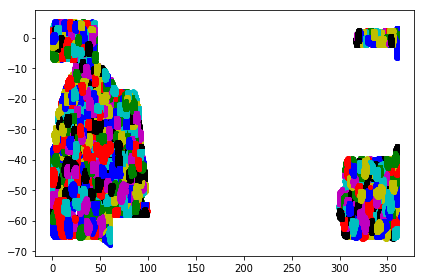

In [24]:
import kmeans_radec
import os
from scipy import spatial
from kmeans_radec import KMeans, kmeans_sample
desy3_map = np.zeros(hp.nside2npix(nside))

pix1 = convert_to_pix_coord(sample_dict['ra'],sample_dict['dec'], nside=nside)
unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
desy3_map[unique_pix1] += np.bincount(idx_rep1, weights=np.ones(len(pix1)))
mas_desy3 = desy3_map!=0.
# INPUT:   ****************************
'''
you might want to use 100 jackknife if you're using
the sumbsampled version of the catalog/
'''
n_jck = 1000 #!!!!!!

def IndexToDeclRa(index, nside,ge=False,nest=False):
    theta,phi=hp.pixelfunc.pix2ang(nside ,index,nest)
    if ge:
        r = hp.rotator.Rotator(coord=['G','E'])
        theta, phi = r(theta,phi) 
    return -np.degrees(theta-np.pi/2.),np.degrees(phi)



    ipix = np.arange(0,npix)
    theta, phi = hp.pixelfunc.pix2ang(nside, ipix)
    ra, dec = to_ra_dec(theta,phi)
    kappa = map
    return ra,dec,kappa
def jaccknife_regions(ra,dec,number_of_regions,label_jck = None, centers_jck = None, v = False):
    new_cat=np.array(zip(ra, dec))
    A=new_cat[np.random.randint(new_cat.shape[0],size=20000),:]
    
    if not v:
        centers_jck= kmeans_radec.kmeans_sample(A,number_of_regions,maxiter=100,tol=1e-05,verbose=0)
        np.savetxt(label_jck, centers_jck.centers)
        centers_tree = spatial.cKDTree(centers_jck.centers[:,[0,1]])
        _ , hpix= centers_tree.query(np.array(zip(ra,dec)))
        return centers_tree, hpix, centers_jck.centers[:,[0,1]]   
    
    centers_tree = spatial.cKDTree(centers_jck[:,[0,1]])
    _ , hpix= centers_tree.query(np.array(zip(ra,dec)))
    return centers_tree, hpix, centers_jck[:,[0,1]]

# define jackknife regions **********************
mask_jkkk =  (mas_desy3!=0.)
area = np.array(range(hp.nside2npix(nside)))[mask_jkkk]
dech,rah = IndexToDeclRa(area, nside)

label_jck= "./centers100spn.txt"
label_dist= "./dist100spn.txt"
if  os.path.exists(label_jck):
    centers=np.array(np.loadtxt(label_jck)) 
    centers_tree, hpix, centers = jaccknife_regions(rah,dech,n_jck,label_jck, centers, v = True)
else:
    centers_tree, hpix, centers = jaccknife_regions(rah,dech,n_jck,label_jck)

# plot jackknife regions in case ********************
color_i=[]
for gg in range(1000):
    color_i.append('b')
    color_i.append('g')
    color_i.append('r')
    color_i.append('c')
    color_i.append('m')
    color_i.append('y')
    color_i.append('k')

fig= plt.figure()
ax = fig.add_subplot(111)
for j in range(len(np.unique(hpix))):
    mask2=hpix==j
    plt.plot(rah[mask2], dech[mask2], 'o', ms=4, alpha=1., color=color_i[j])
plt.show()


# jackknife assignment to mastercat
ii=0
bbb = np.vstack([np.array(sample_dict['ra']).T,
                             np.array(sample_dict['dec']).T]).T
from scipy import spatial
from astropy.table import Table
_, hpp =  (spatial.cKDTree(centers)).query(bbb)


label_dist= "./dist100spn.txt"
distance_calc(label_dist,rah,dech,hpix, n_jck, centers)



info=dict()
info.update({'hpix' : hpp})
info.update({'rah' : rah})
info.update({'dech' : dech})
info.update({'centers' : centers})
info.update({'n_jck' : n_jck})







In [12]:
orig1 = pd.DataFrame(data =sample_dict, index = sample_dict['idx'])
path_m = "/global/cscratch1/sd/mgatti/Cosmic_shear/Additive/everything1.csv"
orig1.to_csv(path_m)


In [25]:
1

1

0_500
done


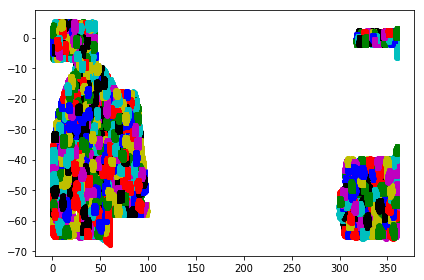

0_500
done


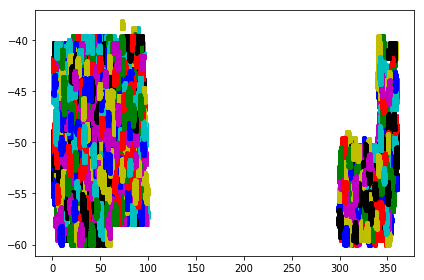

In [40]:
import kmeans_radec
import os
from scipy import spatial
from kmeans_radec import KMeans, kmeans_sample


# INPUT:   ****************************
'''
you might want to use 100 jackknife if you're using
the sumbsampled version of the catalog/
'''
n_jck = 1000 #!!!!!!


def IndexToDeclRa(index, nside,nest= False):
    theta,phi=hp.pixelfunc.pix2ang(nside ,index,nest=nest)
    return -np.degrees(theta-np.pi/2.),np.degrees(phi)

def jaccknife_regions(ra,dec,number_of_regions,label_jck = None, centers_jck = None, v = False):
    new_cat=np.array(zip(ra, dec))
    A=new_cat[np.random.randint(new_cat.shape[0],size=20000),:]
    
    if not v:
        centers_jck= kmeans_radec.kmeans_sample(A,number_of_regions,maxiter=100,tol=1e-05,verbose=0)
        np.savetxt(label_jck, centers_jck.centers)
        centers_tree = spatial.cKDTree(centers_jck.centers[:,[0,1]])
        _ , hpix= centers_tree.query(np.array(zip(ra,dec)))
        return centers_tree, hpix, centers_jck.centers[:,[0,1]]   
    
    centers_tree = spatial.cKDTree(centers_jck[:,[0,1]])
    _ , hpix= centers_tree.query(np.array(zip(ra,dec)))
    return centers_tree, hpix, centers_jck[:,[0,1]]

for ii,z_min in enumerate(z_min_arr):
    z_max = z_max_arr[ii]
    binx = '{0}_{1}'.format(z_min,z_max)
    
    
    
    print binx
    
    
    # define jackknife regions **********************
    
    area = np.array(range(hp.nside2npix(nside)))[dict_tot[binx]['info']['mask_sims']]
    dec,ra = IndexToDeclRa(area, nside)
   
    #it defines jackknife once for every tomographic bins
    name_folder = name_folder_x+'_{0}_{1}/'.format(z_min_arr[0],z_max_arr[0]) 
    label_jck = name_folder+ '/jck_centers_data_{0}.txt'.format(n_jck)
    
    if  os.path.exists(label_jck):
        centers=np.array(np.loadtxt(label_jck)) 
        centers_tree, hpix, centers = jaccknife_regions(ra,dec,n_jck,label_jck, centers, v = True)
    else:
        centers_tree, hpix, centers = jaccknife_regions(ra,dec,n_jck,label_jck)
    

    dict_tot[binx]['info'].update({'hpix' : hpix})
    dict_tot[binx]['info'].update({'ra' : ra})
    dict_tot[binx]['info'].update({'dec' : dec})
    dict_tot[binx]['info'].update({'centers' : centers})
    dict_tot[binx]['info'].update({'n_jck' : n_jck})
print ('done')

# plot jackknife regions in case ********************
color_i=[]
for gg in range(1000):
    color_i.append('b')
    color_i.append('g')
    color_i.append('r')
    color_i.append('c')
    color_i.append('m')
    color_i.append('y')
    color_i.append('k')

fig= plt.figure()
ax = fig.add_subplot(111)
for j in range(len(np.unique(hpix))):
    mask2=hpix==j
    plt.plot(ra[mask2], dec[mask2], 'o', ms=4, alpha=1., color=color_i[j])
    
plt.show()
    
    
    

for ii,z_min in enumerate(z_min_arr):
    z_max = z_max_arr[ii]
    binx = '{0}_{1}'.format(z_min,z_max)
    
    
    
    print binx
    
    
    # define jackknife regions **********************
    
    area = np.array(range(hp.nside2npix(nside)))[dict_tot_y1[binx]['info']['mask_sims']]
    dec,ra = IndexToDeclRa(area, nside)
   
    #it defines jackknife once for every tomographic bins
    name_folder = name_folder_x+'_{0}_{1}/'.format(z_min_arr[0],z_max_arr[0]) 
    label_jck = name_folder+ '/jck_centers_data_y1_{0}.txt'.format(n_jck)
    
    if  os.path.exists(label_jck):
        centers=np.array(np.loadtxt(label_jck)) 
        centers_tree, hpix, centers = jaccknife_regions(ra,dec,n_jck,label_jck, centers, v = True)
    else:
        centers_tree, hpix, centers = jaccknife_regions(ra,dec,n_jck,label_jck)
    

    dict_tot_y1[binx]['info'].update({'hpix' : hpix})
    dict_tot_y1[binx]['info'].update({'ra' : ra})
    dict_tot_y1[binx]['info'].update({'dec' : dec})
    dict_tot_y1[binx]['info'].update({'centers' : centers})
    dict_tot_y1[binx]['info'].update({'n_jck' : n_jck})
print ('done')

# plot jackknife regions in case ********************
color_i=[]
for gg in range(1000):
    color_i.append('b')
    color_i.append('g')
    color_i.append('r')
    color_i.append('c')
    color_i.append('m')
    color_i.append('y')
    color_i.append('k')

fig= plt.figure()
ax = fig.add_subplot(111)
for j in range(len(np.unique(hpix))):
    mask2=hpix==j
    plt.plot(ra[mask2], dec[mask2], 'o', ms=4, alpha=1., color=color_i[j])


In [ ]:
1

# Make systematic maps file

In [4]:
import pandas as pd
path_m = "/global/cscratch1/sd/mgatti/Cosmic_shear/Additive/everything1.csv"
sample_dict=pd.read_csv(path_m)

'''
It loads into memory a number of systematic maps to correlate with kE,kB maps.
Observing condition maps can be found here:
https://cdcvs.fnal.gov/redmine/projects/des-y3/wiki/Systematic_maps_v2
'''
def IndexToDeclRa(index, nside,ge=False,nest=False):
    theta,phi=hp.pixelfunc.pix2ang(nside ,index,nest)
    if ge:
        r = hp.rotator.Rotator(coord=['G','E'])
        theta, phi = r(theta,phi) 
    return -np.degrees(theta-np.pi/2.),np.degrees(phi)



    ipix = np.arange(0,npix)
    theta, phi = hp.pixelfunc.pix2ang(nside, ipix)
    ra, dec = to_ra_dec(theta,phi)
    kappa = map
    return ra,dec,kappa
import pyfits as pf

bands = ['i'] #,'g','r','z']

path_sys = "/global/cscratch1/sd/mgatti/Input_files/"

systematic_maps = dict()  

'''
Maps that DOES NOT depend on the tomographic bin. Maps that depend 
on the tomographic bin will be loaded later on 
'''


#Invert seeing with airmass! ********
nside_sys = 4096
pix_cat = convert_to_pix_coord(np.array(sample_dict['ra']),np.array(sample_dict['dec']),nside_sys)



# SEEING *****************************************************
for band in bands:
    mute = pf.open(path_sys+'/systematic_maps/y3a2_{0}_o.4096_t.32768_FWHM.WMEAN_EQU.fits.gz'.format(band))
    nside_sys = 4096
    sys_map = np.zeros(hp.nside2npix(nside_sys))
    ss= np.zeros(hp.nside2npix(nside_sys))
    index = mute[1].data['PIXEL']
    decxx,raxx =  IndexToDeclRa(index, 4096,nest=True)

    sys_map[mute[1].data['PIXEL']] = mute[1].data['SIGNAL']
    pix_high = convert_to_pix_coord(raxx,decxx, nside=4096)
    ss[pix_high]=sys_map[mute[1].data['PIXEL']]
    sample_dict['seeing_{0}'.format(band)] = ss[pix_cat]
    
    if nside_sys != nside :
        sys_map = hp.ud_grade(sys_map, nside, order_in = 'NESTED', order_out = 'RING')
    
    sys_map2 = np.zeros(hp.nside2npix(nside)) 
    n_map =  np.zeros(hp.nside2npix(nside))
    pix = convert_to_pix_coord(raxx,decxx, nside=nside)
    unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)
    n_map[unique_pix] += np.bincount(idx_rep, weights=np.ones(len(pix)))
    sys_map2[unique_pix] += np.bincount(idx_rep, weights=mute[1].data['SIGNAL'])
    sys_map2[n_map!=0.]=sys_map2[n_map!=0.]/n_map[n_map!=0.]

    mute_dict = dict()
    mute_dict.update({'map' : sys_map2})
    mute_dict.update({'map_old' : sys_map})
    mute_dict.update({'title' : 'seeing_{0}'.format(band)})
    mute_dict.update({'fractional' : True})
    systematic_maps.update({mute_dict['title']  : mute_dict})
    
    
    # *********************

    
# AIRMASS *****************************************************
for band in bands:
    mute = pf.open(path_sys+'/systematic_maps/y3a2_{0}_o.4096_t.32768_AIRMASS.WMEAN_EQU.fits.gz'.format(band))
    nside_sys = 4096
    sys_map = np.zeros(hp.nside2npix(nside_sys))
    sys_map[mute[1].data['PIXEL']] = mute[1].data['SIGNAL']
    
    ss= np.zeros(hp.nside2npix(nside_sys))
    index = mute[1].data['PIXEL']
    decxx,raxx =  IndexToDeclRa(index, 4096,nest=True)

    sys_map[mute[1].data['PIXEL']] = mute[1].data['SIGNAL']
    pix_high = convert_to_pix_coord(raxx,decxx, nside=4096)
    ss[pix_high]=sys_map[mute[1].data['PIXEL']]
    sample_dict['airmass_{0}'.format(band)] = ss[pix_cat]
    
    if nside_sys != nside :
        sys_map = hp.ud_grade(sys_map, nside, order_in = 'NESTED', order_out = 'RING')

    index = mute[1].data['PIXEL']
    sys_map2 = np.zeros(hp.nside2npix(nside)) 
    n_map =  np.zeros(hp.nside2npix(nside))
    decxx,raxx =  IndexToDeclRa(index, 4096,nest=True)
    pix = convert_to_pix_coord(raxx,decxx, nside=nside)
    unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)
    n_map[unique_pix] += np.bincount(idx_rep, weights=np.ones(len(pix)))
    sys_map2[unique_pix] += np.bincount(idx_rep, weights=mute[1].data['SIGNAL'])
    sys_map2[n_map!=0.]=sys_map2[n_map!=0.]/n_map[n_map!=0.]
    mute_dict = dict()
    mute_dict.update({'map' : sys_map2})
    mute_dict.update({'map_old' : sys_map})
    
    mute_dict.update({'title' : 'airmass_{0}'.format(band)})
    mute_dict.update({'fractional' : True})
    systematic_maps.update({mute_dict['title']  : mute_dict})
    

    # *********************

# EXPTIME *****************************************************
for band in bands:
    mute = pf.open(path_sys+'/systematic_maps/y3a2_{0}_o.4096_t.32768_EXPTIME.SUM_EQU.fits.gz'.format(band))
    nside_sys = 4096
    sys_map = np.zeros(hp.nside2npix(nside_sys))
    sys_map[mute[1].data['PIXEL']] = mute[1].data['SIGNAL']
    
    ss= np.zeros(hp.nside2npix(nside_sys))
    index = mute[1].data['PIXEL']
    decxx,raxx =  IndexToDeclRa(index, 4096,nest=True)

    sys_map[mute[1].data['PIXEL']] = mute[1].data['SIGNAL']
    pix_high = convert_to_pix_coord(raxx,decxx, nside=4096)
    ss[pix_high]=sys_map[mute[1].data['PIXEL']]
    sample_dict['exp_time_{0}'.format(band)] = ss[pix_cat]
    
    if nside_sys != nside :
        sys_map = hp.ud_grade(sys_map, nside, order_in = 'NESTED', order_out = 'RING')


    index = mute[1].data['PIXEL']
    sys_map2 = np.zeros(hp.nside2npix(nside)) 
    n_map =  np.zeros(hp.nside2npix(nside))
    decxx,raxx =  IndexToDeclRa(index, 4096,nest=True)
    pix = convert_to_pix_coord(raxx,decxx, nside=nside)
    unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)
    n_map[unique_pix] += np.bincount(idx_rep, weights=np.ones(len(pix)))
    sys_map2[unique_pix] += np.bincount(idx_rep, weights=mute[1].data['SIGNAL'])
    sys_map2[n_map!=0.]=sys_map2[n_map!=0.]/n_map[n_map!=0.]
    
    
    mute_dict = dict()
    mute_dict.update({'map' : sys_map2})
    mute_dict.update({'map_old' : sys_map})
    mute_dict.update({'title' : 'exp_time_{0}'.format(band)})
    mute_dict.update({'fractional' : True})
    systematic_maps.update({mute_dict['title']  : mute_dict})

# DEPTH *****************************************************
for band in bands:
    mute = pf.open(path_sys+'/systematic_maps/y3a2_gold_2_2_1_mof_nside4096_nest_{0}_depth.fits.gz'.format(band))
    nside_sys = 4096
    sys_map = np.zeros(hp.nside2npix(nside_sys))
    sys_mapa = ((mute[1].data['I'])).reshape(201326592)#, n2r = True)
    index = np.arange(len(sys_map))[sys_mapa>0.0000000001]
    
    
    ss= np.zeros(hp.nside2npix(nside_sys))
    decxx,raxx =  IndexToDeclRa(index, 4096,nest=True)

    sys_map = sys_mapa
    pix_high = convert_to_pix_coord(raxx,decxx, nside=4096)
    ss[pix_high]=sys_map[index]
    sample_dict['depth_{0}'.format(band)] = ss[pix_cat]
    
    if nside_sys != nside :
        sys_map = hp.ud_grade(sys_mapa, nside, order_in = 'NESTED', order_out = 'RING')

    
    
    sys_map2 = np.zeros(hp.nside2npix(nside)) 
    n_map =  np.zeros(hp.nside2npix(nside))
    decxx,raxx =  IndexToDeclRa(index, 4096,nest=True)
    pix = convert_to_pix_coord(raxx,decxx, nside=nside)
    unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)
    n_map[unique_pix] += np.bincount(idx_rep, weights=np.ones(len(pix)))
    sys_map2[unique_pix] += np.bincount(idx_rep, weights=sys_mapa[sys_mapa>0.0000000001])
    sys_map2[n_map!=0.]=sys_map2[n_map!=0.]/n_map[n_map!=0.]
    sys_map[~(n_map!=0.)]=0.
    
    mute_dict = dict()
    mute_dict.update({'map' : sys_map2})
    mute_dict.update({'map_old' : sys_map})
    mute_dict.update({'title' : 'depth_{0}'.format(band)})
    mute_dict.update({'fractional' : False})
    systematic_maps.update({mute_dict['title']  : mute_dict})

# SKYVAR BRIGHTNESS *****************************************************
for band in bands:
    mute = pf.open(path_sys+'/systematic_maps/y3a2_{0}_o.4096_t.32768_SKYVAR.UNCERTAINTY_EQU.fits.gz'.format(band))
    nside_sys = 4096
    sys_map = np.zeros(hp.nside2npix(nside_sys))
    sys_map[mute[1].data['PIXEL']] = mute[1].data['SIGNAL']
    
    ss= np.zeros(hp.nside2npix(nside_sys))
    index = mute[1].data['PIXEL']
    decxx,raxx =  IndexToDeclRa(index, 4096,nest=True)

    sys_map[mute[1].data['PIXEL']] = mute[1].data['SIGNAL']
    pix_high = convert_to_pix_coord(raxx,decxx, nside=4096)
    ss[pix_high]=sys_map[mute[1].data['PIXEL']]
    sample_dict['brightness_{0}'.format(band)] = ss[pix_cat]
    
    if nside_sys != nside :
        sys_map = hp.ud_grade(sys_map, nside, order_in = 'NESTED', order_out = 'RING')


    index = mute[1].data['PIXEL']
    sys_map2 = np.zeros(hp.nside2npix(nside)) 
    n_map =  np.zeros(hp.nside2npix(nside))
    decxx,raxx =  IndexToDeclRa(index, 4096,nest=True)
    pix = convert_to_pix_coord(raxx,decxx, nside=nside)
    unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)
    n_map[unique_pix] += np.bincount(idx_rep, weights=np.ones(len(pix)))
    sys_map2[unique_pix] += np.bincount(idx_rep, weights=mute[1].data['SIGNAL'])
    sys_map2[n_map!=0.]=sys_map2[n_map!=0.]/n_map[n_map!=0.]

    mute_dict = dict()
    mute_dict.update({'map' : sys_map2})
    mute_dict.update({'map_old' : sys_map})
    mute_dict.update({'title' : 'brightness_{0}'.format(band)})
    mute_dict.update({'fractional' : False})
    systematic_maps.update({mute_dict['title']  : mute_dict})

#************************************************************************
'''
if 1==1:
    
    mute_dict = dict()
    mute_dict.update({'title' : 'q1_stars'.format(band)})
    mute_dict.update({'map' : q1s_map})
    mute_dict.update({'fractional' : False})
    systematic_maps.update({mute_dict['title']  : mute_dict})

    mute_dict = dict()
    mute_dict.update({'title' : 'q2_stars'.format(band)})
    mute_dict.update({'map' : q2s_map})
    mute_dict.update({'fractional' : False})
    systematic_maps.update({mute_dict['title']  : mute_dict})


    mute_dict = dict()
    mute_dict.update({'title' : 't1_stars'.format(band)})
    mute_dict.update({'map' : t1s_map})
    mute_dict.update({'fractional' : False})
    systematic_maps.update({mute_dict['title']  : mute_dict})

    mute_dict = dict()
    mute_dict.update({'title' : 't2_stars'.format(band)})
    mute_dict.update({'map' : t2s_map})
    mute_dict.update({'fractional' : False})
    systematic_maps.update({mute_dict['title']  : mute_dict})

    

for binx in dict_tot.keys():

    dict_tot[binx].update({'p1_stars':p1s_map})
    dict_tot[binx].update({'p2_stars':p2s_map})
    dict_tot[binx].update({'q1_stars':q1s_map})
    dict_tot[binx].update({'q2_stars':q2s_map})
    dict_tot[binx].update({'t1_stars':t1s_map})
    dict_tot[binx].update({'t2_stars':t2s_map})
    dict_tot[binx].update({'size_stars':size_map})
    dict_tot[binx].update({'size_stars_t':size})
    dict_tot[binx].update({'p1_stars_t':p1})
    dict_tot[binx].update({'p2_stars_t':p2})
    dict_tot[binx].update({'q1_stars_t':q1})
    dict_tot[binx].update({'q2_stars_t':q2})
    dict_tot[binx].update({'t1_stars_t':t1})
    dict_tot[binx].update({'t2_stars_t':t2})
    dict_tot[binx].update({'e1_stars_t':e1_o})
    dict_tot[binx].update({'e2_stars_t':e2_o})
    dict_tot[binx].update({'e1_stars':e1o_map})
    dict_tot[binx].update({'e2_stars':e2o_map})

'''

save_obj(path_sys+"/systematic_maps",systematic_maps)

In [ ]:
sample_dict['ra']

In [7]:
sample_dict['bpz_zmc']  = 0.
sample_dict['bpz_zmean']  = 0.
sample_dict['dec']  = 0.
sample_dict['ra']  = 0.
sample_dict['jk']  = 0.
sample_dict['info']  = 0.
sample_dict['idx']  = 0.
sample_dict['e2_rndm_rot']  = 0.
sample_dict['e1_rndm_rot']  = 0.
sample_dict['r-i']  = 0.


In [ ]:
#pd.DataFrame(data =dd, index = sample_dict['idx'])
#save_obj('/global/cscratch1/sd/mgatti/Cosmic_shear/y3_small',sample_dict)

In [ ]:
#sample_dict = dict()
#[sample_dict['e1'],sample_dict['e2'],sample_dict['psf_e1'],sample_dict['psf_e2'],sample_dict['psf_size']] = load_obj('/global/cscratch1/sd/mgatti/Cosmic_shear/y3_small')

In [34]:
1

1

In [54]:
import glob
ff = glob.glob('/global/cscratch1/sd/mgatti/Cosmic_shear/Additive_mastercat_04_20/_0_500/save_*')
for fff in ff:
    try:
        xs = load_obj(fff.split('.pkl')[0])
        print xs['kE_label']
        print xs['sys_map']['title']
        print xs['sys_map']['xmax']
        print xs['sys_map']['xmin']
        print (' ')
    except:
        pass


E2
t2
2e-05
-2e-05
 
E2
psf_e2
0.03
-0.03
 
E1
brightness_i
11.5
4.0
 
E2
airmass_i
1.4
1.0
 
E1
airmass_i
1.4
1.0
 
E1
snr
1000.0
10.0
 
E2
brightness_i
11.5
4.0
 
E1
exp_time_i
600.0
100.0
 
E1
q1
0.0005
-0.0005
 
E2
t1
2e-05
-2e-05
 
E2
p1
0.005
-0.005
 
E1
seeing_i
1.05
0.75
 
E2
psf_size
0.6
0.2
 
E2
depth_i
23.5
22.0
 
E1
psf_size
0.6
0.2
 
E2
psf_e1
0.03
-0.03
 
E1
t2
2e-05
-2e-05
 
E1
size_ratio
10.0
0.5
 
E2
size_ratio
10.0
0.5
 
E2
exp_time_i
600.0
100.0
 
E1
psf_e2
0.03
-0.03
 
E1
depth_i
23.5
22.0
 
E2
q2
0.0005
-0.0005
 
E1
psf_e1
0.03
-0.03
 
E1
p2
0.005
-0.005
 
E2
q1
0.0005
-0.0005
 
E1
t1
2e-05
-2e-05
 
E1
q2
0.0005
-0.0005
 
E2
seeing_i
1.05
0.75
 
E1
p1
0.005
-0.005
 
E2
snr
1000.0
10.0
 
E2
p2
0.005
-0.005
 


# Prepare runs

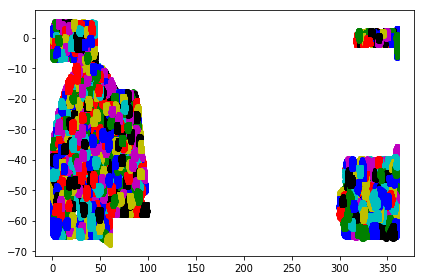

compute maximum distance for each jackknife region


In [35]:
import kmeans_radec
import os
from scipy import spatial
from kmeans_radec import KMeans, kmeans_sample
desy3_map = np.zeros(hp.nside2npix(nside))

pix1 = convert_to_pix_coord(sample_dict['ra'],sample_dict['dec'], nside=nside)
unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
desy3_map[unique_pix1] += np.bincount(idx_rep1, weights=np.ones(len(pix1)))
mas_desy3 = desy3_map!=0.
# INPUT:   ****************************
'''
you might want to use 100 jackknife if you're using
the sumbsampled version of the catalog/
'''
n_jck = 1000 #!!!!!!

def IndexToDeclRa(index, nside,ge=False,nest=False):
    theta,phi=hp.pixelfunc.pix2ang(nside ,index,nest)
    if ge:
        r = hp.rotator.Rotator(coord=['G','E'])
        theta, phi = r(theta,phi) 
    return -np.degrees(theta-np.pi/2.),np.degrees(phi)



    ipix = np.arange(0,npix)
    theta, phi = hp.pixelfunc.pix2ang(nside, ipix)
    ra, dec = to_ra_dec(theta,phi)
    kappa = map
    return ra,dec,kappa
def jaccknife_regions(ra,dec,number_of_regions,label_jck = None, centers_jck = None, v = False):
    new_cat=np.array(zip(ra, dec))
    A=new_cat[np.random.randint(new_cat.shape[0],size=20000),:]
    
    if not v:
        centers_jck= kmeans_radec.kmeans_sample(A,number_of_regions,maxiter=100,tol=1e-05,verbose=0)
        np.savetxt(label_jck, centers_jck.centers)
        centers_tree = spatial.cKDTree(centers_jck.centers[:,[0,1]])
        _ , hpix= centers_tree.query(np.array(zip(ra,dec)))
        return centers_tree, hpix, centers_jck.centers[:,[0,1]]   
    
    centers_tree = spatial.cKDTree(centers_jck[:,[0,1]])
    _ , hpix= centers_tree.query(np.array(zip(ra,dec)))
    return centers_tree, hpix, centers_jck[:,[0,1]]

# define jackknife regions **********************
mask_jkkk =  (mas_desy3!=0.)
area = np.array(range(hp.nside2npix(nside)))[mask_jkkk]
dech,rah = IndexToDeclRa(area, nside)

label_jck= "./centers100spn.txt"
label_dist= "./dist100spn.txt"
if  os.path.exists(label_jck):
    centers=np.array(np.loadtxt(label_jck)) 
    centers_tree, hpix, centers = jaccknife_regions(rah,dech,n_jck,label_jck, centers, v = True)
else:
    centers_tree, hpix, centers = jaccknife_regions(rah,dech,n_jck,label_jck)

# plot jackknife regions in case ********************
color_i=[]
for gg in range(1000):
    color_i.append('b')
    color_i.append('g')
    color_i.append('r')
    color_i.append('c')
    color_i.append('m')
    color_i.append('y')
    color_i.append('k')

fig= plt.figure()
ax = fig.add_subplot(111)
for j in range(len(np.unique(hpix))):
    mask2=hpix==j
    plt.plot(rah[mask2], dech[mask2], 'o', ms=4, alpha=1., color=color_i[j])
plt.show()


# jackknife assignment to mastercat
ii=0
bbb = np.vstack([np.array(sample_dict['ra']).T,
                             np.array(sample_dict['dec']).T]).T
from scipy import spatial
from astropy.table import Table
_, hpp =  (spatial.cKDTree(centers)).query(bbb)


label_dist= "./dist100spn.txt"
distance_calc(label_dist,rah,dech,hpix, n_jck, centers)



info=dict()
info.update({'hpix' : hpp})
info.update({'rah' : rah})
info.update({'dech' : dech})
info.update({'centers' : centers})
info.update({'n_jck' : n_jck})



In [56]:
def do_analysis_4(name_foder,ss,kE,kE_label,weight,systematic_maps,info,fract_limits=0,len_hist=10,hpix_type = 'normal',cov_ext = False, fit ='linear'):
    systematics_dict = dict() 
    runit = dict()
    
    count =0
    for key in systematic_maps.keys():
      
        t1 = timeit.default_timer()
        
        if hpix_type == 'normal':
           
            mute_dict=dict()
            mute_dict['kE_label'] = kE_label
            mute_dict['sys_map'] = systematic_maps[key]
            mute_dict['mask'] = info['mask_sims']
            mute_dict['kE'] = kE
            mute_dict['info_hpix'] = info['hpix']
            save_obj(name_foder+'save_'+kE_label+'_'+key+'_'+ss,mute_dict)
            
            #dict_output = analysis_3(kE_label,systematic_maps[key],info['mask_sims'],kE,info['hpix'])
            runit[count] = name_foder+'save_'+kE_label+'_'+key+'_'+ss
            count+=1
        if hpix_type == 'marc':
            
            mute_dict=dict()
            mute_dict['kE_label'] = kE_label
            mute_dict['sys_map'] = systematic_maps[key]
            mute_dict['mask'] = info['mask_sims']
            mute_dict['kE'] = kE
            mute_dict['info_hpix'] = info['hpix_f']
            save_obj(name_foder+'save_'+kE_label+'_'+key+'_'+ss,mute_dict)
            
            runit[count] = name_foder+'save_'+kE_label+'_'+key+'_'+ss
            count+=1

           # dict_output = analysis_3(kE_label,systematic_maps[key],info['mask_sims'],kE,info['hpix_f'])
        #systematics_dict.update({systematic_maps[key]['title'] : dict_output})
        #t2 = timeit.default_timer()
        #print "slope {0} +- {1}".format(dict_output['b_arr'][0],dict_output['b_err'])
        #print (t2-t1)
    return runit


def read_4(name_foder,ss,kE,kE_label,weight,systematic_maps,info,fract_limits=0,len_hist=10,hpix_type = 'normal',cov_ext = False, fit ='linear'):
    systematics_dict = dict() 
    systematics_dict_FLASK = dict() 
    runit = dict()
    
    count =0
    for key in systematic_maps.keys():
      

        t1 = timeit.default_timer()
        

        dict_output=load_obj(name_foder+'save_'+kE_label+'_'+key+'_'+ss+'_dict_outp')
        try:
            dict_output_FLASK=load_obj(name_foder+'save_'+kE_label+'_'+key+'_'+ss+'_dict_outp_FLASK')
        except:
            dict_output_FLASK
   
           # dict_output = analysis_3(kE_label,systematic_maps[key],info['mask_sims'],kE,info['hpix_f'])
        systematics_dict.update({systematic_maps[key]['title'] : dict_output})
        systematics_dict_FLASK.update({systematic_maps[key]['title'] : dict_output_FLASK})

    return systematics_dict,systematics_dict_FLASK


In [ ]:
'''
sample_dict.keys()

orig1 = pd.DataFrame(data =dd, index = sample_dict['idx'])
path_m = "/global/cscratch1/sd/mgatti/Cosmic_shear/Additive/everything.csv"
orig1.to_csv(path_m)
'''
import pandas as pd
path_m = "/global/cscratch1/sd/mgatti/Cosmic_shear/Additive/everything_aftersys_04_20.csv"
sample_dict=pd.read_csv(path_m)




In [60]:
# *****************************************

dict_systematics_tot_E_full = dict()
dict_systematics_tot_E_full_FLASK = dict()


systematic_maps_binx = dict()

systematic_maps_full = dict()



# *********************************

binx = '{0}_{1}'.format(0,500)
name_foder =name_folder_x+'_{0}_{1}/'.format(0,500)




# seeing_i*****************************************************
mute_dict = dict()
mute_dict.update({'title' : 'seeing_i'})
try:
    mute_dict.update({'map' : sample_dict['seeing_i']})
    mute_dict.update({'fractional' : False})
except:
    pass
systematic_maps_full.update({mute_dict['title']  : mute_dict})

# exp_time_i*****************************************************
mute_dict = dict()
mute_dict.update({'title' : 'exp_time_i'})
try:
    mute_dict.update({'map' : sample_dict['exp_time_i']})
    mute_dict.update({'fractional' : False})
except:
    pass
systematic_maps_full.update({mute_dict['title']  : mute_dict})


# brightness_i *****************************************************
mute_dict = dict()
mute_dict.update({'title' : 'brightness_i'})
try:
    mute_dict.update({'map' : sample_dict['brightness_i']})
    mute_dict.update({'fractional' : False})
except:
    pass
systematic_maps_full.update({mute_dict['title']  : mute_dict})

# depth *****************************************************
mute_dict = dict()
mute_dict.update({'title' : 'depth_i'})
try:
    mute_dict.update({'map' : sample_dict['depth_i']})
    mute_dict.update({'fractional' : False})
except:
    pass
systematic_maps_full.update({mute_dict['title']  : mute_dict})

# airmass_i *****************************************************
mute_dict = dict()
mute_dict.update({'title' : 'airmass_i'})
try:
    mute_dict.update({'map' : sample_dict['airmass_i']})
    mute_dict.update({'fractional' : False})
except:
    pass
systematic_maps_full.update({mute_dict['title']  : mute_dict})


# q1 *****************************************************
mute_dict = dict()
mute_dict.update({'title' : 'q1'})
try:
    mute_dict.update({'map' : sample_dict['q1']})
    mute_dict.update({'fractional' : False})
except:
    pass
systematic_maps_full.update({mute_dict['title']  : mute_dict})

# q2 *****************************************************
mute_dict = dict()
mute_dict.update({'title' : 'q2'})
try:
    mute_dict.update({'map' : sample_dict['q2']})
    mute_dict.update({'fractional' : False})
except:
    pass
systematic_maps_full.update({mute_dict['title']  : mute_dict})

# p1 *****************************************************
mute_dict = dict()
mute_dict.update({'title' : 'p1'})
try:
    mute_dict.update({'map' : sample_dict['p1']})
    mute_dict.update({'fractional' : False})
except:
    pass
systematic_maps_full.update({mute_dict['title']  : mute_dict})

# p2 *****************************************************
mute_dict = dict()
mute_dict.update({'title' : 'p2'})
try:
    mute_dict.update({'map' : sample_dict['p2']})
    mute_dict.update({'fractional' : False})
except:
    pass
systematic_maps_full.update({mute_dict['title']  : mute_dict})

# t1 *****************************************************
mute_dict = dict()
mute_dict.update({'title' : 't1'})
try:
    mute_dict.update({'map' : sample_dict['t1']})
    mute_dict.update({'fractional' : False})
except:
    pass
systematic_maps_full.update({mute_dict['title']  : mute_dict})

# t2 *****************************************************
mute_dict = dict()
mute_dict.update({'title' : 't2'})
try:
    mute_dict.update({'map' : sample_dict['t2']})
    mute_dict.update({'fractional' : False})
except:
    pass
systematic_maps_full.update({mute_dict['title']  : mute_dict})



# PSF_E1 *****************************************************
mute_dict = dict()
mute_dict.update({'title' : 'psf_e1'})
try:
    mute_dict.update({'map' : sample_dict['psf_e1']})
    mute_dict.update({'fractional' : False})
except:
    pass
systematic_maps_full.update({mute_dict['title']  : mute_dict})

# PSF_E2 *****************************************************
mute_dict = dict()
mute_dict.update({'title' : 'psf_e2'})
try:
    mute_dict.update({'map' : sample_dict['psf_e2']})
    mute_dict.update({'fractional' : False})
except:
    pass
systematic_maps_full.update({mute_dict['title']  : mute_dict})


# PSF_SIZE *****************************************************
mute_dict = dict()
mute_dict.update({'title' : 'psf_size'})
try:
    mute_dict.update({'map' : sample_dict['psf_size']})
    mute_dict.update({'fractional' : False})
except:
    pass
systematic_maps_full.update({mute_dict['title']  : mute_dict})

# SNR*****************************************************
mute_dict = dict()
mute_dict.update({'title' : 'snr'})
try:
    mute_dict.update({'map' : sample_dict['snr']})
    mute_dict.update({'fractional' : False})
except:
    pass
systematic_maps_full.update({mute_dict['title']  : mute_dict})


# SIZE RATIO *****************************************************
mute_dict = dict()
mute_dict.update({'title' : 'size_ratio'})
try:
    mute_dict.update({'map' : sample_dict['size_ratio']})
    mute_dict.update({'fractional' : False})
    mute_dict.update({'xmin' : 4.})
    mute_dict.update({'xmax' : 0.})
except:
    pass
systematic_maps_full.update({mute_dict['title']  : mute_dict})



mmm_1 = dict()


add_label = '_w0'
try:
    weight = np.zeros(len( sample_dict['bpz_zmean']))
except:
    weight = 0.
mmm_1 = dict()
mmm_2 = dict()






# *****************************************
try:
    kE =  sample_dict['e1']
except:
    kE = 0.
kE_label = 'E1'
systematics_dict_kB_1 = dict()
systematics_dict_kB_2 = dict()
ss= '_v1_'

#try:
systematics_dict_kB_1,systematics_dict_kB_2  = read_4(name_foder,ss,kE,kE_label,weight,systematic_maps_full,info) 
#except:
    #runit = do_analysis_4(name_foder,ss,kE,kE_label,weight,systematic_maps_full,info)     
    #save_obj('runs1',runit)

    #systematics_dict_kB_1.update({add_label : mute_1})
    #save_obj(path_syst,systematics_dict_kB_1)

mmm_1.update({kE_label:systematics_dict_kB_1})
mmm_2.update({kE_label:systematics_dict_kB_2})
dict_systematics_tot_E_full.update({binx:mmm_1})
dict_systematics_tot_E_full_FLASK.update({binx:mmm_2})










# *****************************************
try:
    kE =  sample_dict['e2']
except:
    kE = 0.
kE_label = 'E2'
path_syst = name_foder + '/apoly_systematics_dict_full_E2_{0}_{1}'.format(add_label,nside)
systematics_dict_kB_1 = dict()


#try:
systematics_dict_kB_1,systematics_dict_kB_2 = read_4(name_foder,ss,kE,kE_label,weight,systematic_maps_full,info) 

#except:
#    runit = do_analysis_4(name_foder,ss,kE,kE_label,weight,systematic_maps_full,info)     
#    save_obj('runs2',runit)
#    save_obj(path_syst,systematics_dict_kB_1)

mmm_1.update({kE_label:systematics_dict_kB_1})
mmm_2.update({kE_label:systematics_dict_kB_2})
dict_systematics_tot_E_full.update({binx:mmm_1})
dict_systematics_tot_E_full_FLASK.update({binx:mmm_2})



<function matplotlib.pyplot.tight_layout>

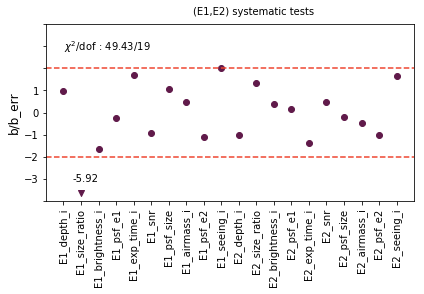

In [64]:
colors = ['#601A4A', '#EE442F','#63ACBE']

def make_plot_final1(dict_final1, label,z_minz,z_maxz,nside,n_jck=1000,type_c = 'jackknife',fact = False,Except=False,only=False,size_x = 10,size_y=10,cchi=True):
    import copy
    fig, ax = plt.subplots(1,1,sharex=True, sharey=True, figsize=(size_x,size_y))
    fig.subplots_adjust(wspace=0.,hspace=0.)
    
    bd = dict()
    for i in range(len(z_minz)):
        #i = 4-i
        z_min = z_minz[i]
        z_max = z_maxz[i]
        #print z_min,z_max
        binx = '{0}_{1}'.format(z_min,z_max)
        fold = './output_new1_{0}_{1}_{2}/'.format(z_min,z_max,nside)
        #for count in range(20):
        if 1==1:
                if 1==1:
                    ll = []
                    ll1 = []
                    key = binx
                    m1 = 0
                    count = 0
                    for key1 in dict_final1[key].keys():
                        if only: 
                            new_key = only[key1]
                            m1+=len(only[key1])
                        elif Except:
                            new_key = []
                            try:
                                llist=list(dict_final1[key][key1].keys())     
                            except:
                                llist=dict_final1[key][key1].keys()
                                
                            for ii,jj in enumerate(~np.in1d(llist,Except[key1])):
                                if jj:
                                    try:
                                        new_key.append(llist[ii])
                                    except:
                                        new_key.append(llist[ii])
                                        
                            m1 += len(new_key)
                        else:
                            m1 += len(dict_final1[key][key1].keys())
                            new_key = dict_final1[key][key1].keys()
                    b1 = np.zeros((m1,n_jck+1))
                    for key1 in dict_final1[key].keys():
                        
                        if only: 
                            new_key = only[key1]
             
                        elif Except:
                            new_key = []
                            try:
                                llist=list(dict_final1[key][key1].keys())     
                            except:
                                llist=dict_final1[key][key1].keys()
   
                            for ii,jj in enumerate(~np.in1d(llist,Except[key1])):
                                if jj:
                                    try:
                                        new_key.append(llist[ii])
                                    except:
                                        new_key.append(llist[ii])
                                        
                               
                        else:
                            new_key = dict_final1[key][key1].keys()
                        
                        for key2 in new_key:
                            b1[count,:]= dict_final1[key][key1][key2]['b_arr']
                            count+=1
                            ll.append('{0}_{1}'.format(key1,key2))


                if fact:
                    b1 = b1
                    b_dict1 = covariance_jck(b1[:,1:]*fact[binx], n_jck, type_cov = type_c)
                else:
                    b_dict1 = covariance_jck(b1[:,1:], n_jck, type_cov = type_c)
                
                
                ax.set_ylabel('b/b_err'.format(binx))
                yticks = ax.yaxis.get_major_ticks()
                yticks[0].label1.set_visible(False)  
                
                ax.scatter(np.arange(len( b1[:,0]))+1, b1[:,0]/b_dict1['err'],label = 'b/b_err',color= colors[0])

                
                # high correlations!
                mm = ((b1[:,0]/b_dict1['err']>3.8))#^((b1[:,0]/b_dict1['err']<-3.8))
                yc = b1[:,0]/b_dict1['err']
                xc = np.arange(len( b1[:,0]))+1
                for hh in range(len(mm[mm])):
                    ax.annotate( '{0:.2f}'.format(yc[mm][hh]), ((xc[mm][hh]-0.5),3.1),transform=ax.transAxes)
                    
                
                if len(mm[mm])>0:
                    yc[mm] = 3.8
                    ax.scatter(xc[mm],yc[mm],  color =  colors[0], marker = '^')

            
                mm = ((b1[:,0]/b_dict1['err']<-3.8))#^((b1[:,0]/b_dict1['err']<-3.8))
                yc = b1[:,0]/b_dict1['err']
                xc = np.arange(len( b1[:,0]))+1
                for hh in range(len(mm[mm])):
                    ax.annotate( '{0:.2f}'.format(yc[mm][hh]), ((xc[mm][hh]-0.5),-3.1),transform=ax.transAxes)
            
            
                if len(mm[mm])>0:
                    yc[mm] = -3.6
                    ax.scatter(xc[mm],yc[mm],  color = colors[0], marker = 'v')
            
            
                plt.xticks(np.arange(len( b1[:,0]))+1,ll, rotation='90')
                ax.text(0.4,1.05 , '{0}'.format(label),transform=ax.transAxes)
                
                w = b1[:,0]
                cns = np.zeros(len(b1[:,0]))
                from scipy import linalg
                inv_cov = linalg.inv(b_dict1['cov'])
                N_p = n_jck
                p_p = len(cns)
                f_hartlap = (N_p-1.)/(N_p-p_p-2.)
                #print f_hartlap
                chi2red =  (np.matmul((w-cns),np.matmul(inv_cov,(w-cns))))/(len(cns)*f_hartlap)
                if cchi:
                    ax.text(0.05 , 0.85 , '$\chi^2$/dof : {0:.2f}/{1:.0f}'.format(chi2red*len(cns),len(cns)-1),transform=ax.transAxes)#,p2s(1 - stats.t.cdf(chi2red,df=len(cns)-1))),transform=ax[i].transAxes)
                
                
                ax.plot([0.,len( b1[:,0])+1],[-2,-2],linestyle="dashed",color=colors[1])
                ax.plot([0.,len( b1[:,0])+1],[2,2],linestyle="dashed",color=colors[1])
                
                ax.xaxis.label.set_size(14)
                ax.yaxis.label.set_size(12)
                
                plt.xlim([0.,len( b1[:,0])+1])
                plt.ylim([-4.,4])
                

        fig.subplots_adjust(wspace=0.,hspace=0.)
        bd.update({binx:[b_dict1,b1]})
    return bd, ll


nside=1024
n_jck = 100

z_min_arr=[0]
z_max_arr=[500]
b_dict_finalA, label_finalA = make_plot_final1(dict_systematics_tot_E_full,'(E1,E2) systematic tests',z_min_arr,z_max_arr,nside,size_x=6,size_y=4,Except ={'E2':["bpz_zmean",'N',"bpz_zmc","PSF_SIZE","PSF_E1","PSF_E2",'E2','E1','kE','kB','q1_stars','q2_stars','t1_stars','t2_stars','q1','q2','t1','t2','p1','p2'],'E1':["bpz_zmean",'N',"bpz_zmc","PSF_SIZE","PSF_E1","PSF_E2",'E1','E2','kE','kB','q1_stars','q2_stars','t1_stars','t2_stars','q1','q2','t1','t2','p1','p2']},n_jck=n_jck,type_c = 'jackknife')
plt.tight_layout


# compute ABE

In [65]:
#A,y
resampling =1000
kk=""
PSFabe_dict = dict()
for ii,z_min in enumerate(z_min_arr):
    
    mute_dict = dict()
    # *********************************
    z_max = z_max_arr[ii]
    binx = '{0}_{1}'.format(z_min,z_max)
    maskj = (sample_dict['e1'] == sample_dict['e1']) & (sample_dict['q1'] == sample_dict['q1']) & (sample_dict['t1'] == sample_dict['t1']) & (sample_dict['p1'] == sample_dict['p1']) & (sample_dict['e2'] == sample_dict['e2']) & (sample_dict['q2'] == sample_dict['q2']) &(sample_dict['p2'] == sample_dict['p2']) & (sample_dict['t2'] == sample_dict['t2'])  
    
    print binx
    # change of variables *********
    mut = np.polyfit(sample_dict['q1'+kk][maskj]-np.mean(sample_dict['q1'+kk][maskj]),sample_dict['p1'+kk][maskj],1,cov =True)
    dp1_dq1 = mut[0][0]
    mut = np.polyfit(sample_dict['t1'+kk][maskj]-np.mean(sample_dict['t1'+kk][maskj]),sample_dict['p1'+kk][maskj],1,cov =True)
    dp1_dw1 = mut[0][0]  
    mut = np.polyfit(sample_dict['p1'+kk][maskj]-np.mean(sample_dict['p1'+kk][maskj]),sample_dict['q1'+kk][maskj],1,cov =True)
    dq1_dp1 = mut[0][0]
    mut = np.polyfit(sample_dict['t1'+kk][maskj]-np.mean(sample_dict['t1'+kk][maskj]),sample_dict['q1'+kk][maskj],1,cov =True)
    dq1_dw1 = mut[0][0] 
    mut = np.polyfit(sample_dict['p1'+kk][maskj]-np.mean(sample_dict['p1'+kk][maskj]),sample_dict['t1'+kk][maskj],1,cov =True)
    dw1_dp1 = mut[0][0]
    mut = np.polyfit(sample_dict['q1'+kk][maskj]-np.mean(sample_dict['q1'+kk][maskj]),sample_dict['t1'+kk][maskj],1,cov =True)
    dw1_dq1 = mut[0][0]
    
    
    mut = np.polyfit(sample_dict['q2'+kk][maskj]-np.mean(sample_dict['q2'+kk][maskj]),sample_dict['p2'+kk][maskj],1,cov =True)
    dp2_dq2 = mut[0][0]
    mut = np.polyfit(sample_dict['t2'+kk][maskj]-np.mean(sample_dict['t2'+kk][maskj]),sample_dict['p2'+kk][maskj],1,cov =True)
    dp2_dw2 = mut[0][0]  
    mut = np.polyfit(sample_dict['p2'+kk][maskj]-np.mean(sample_dict['p2'+kk][maskj]),sample_dict['q2'+kk][maskj],1,cov =True)
    dq2_dp2 = mut[0][0]
    mut = np.polyfit(sample_dict['t2'+kk][maskj]-np.mean(sample_dict['t2'+kk][maskj]),sample_dict['q2'+kk][maskj],1,cov =True)
    dq2_dw2 = mut[0][0] 
    mut = np.polyfit(sample_dict['p2'+kk][maskj]-np.mean(sample_dict['p2'+kk][maskj]),sample_dict['t2'+kk][maskj],1,cov =True)
    dw2_dp2 = mut[0][0]
    mut = np.polyfit(sample_dict['q2'+kk][maskj]-np.mean(sample_dict['q2'+kk][maskj]),sample_dict['t2'+kk][maskj],1,cov =True)
    dw2_dq2 = mut[0][0]
    # *******************************
    dd1_dp2 =dict_systematics_tot_E_full[binx]['E1']['p2']['b_arr']#[#0]
    dd1_dp2e =dict_systematics_tot_E_full[binx]['E1']['p2']['b_err']#
    
    dd2_dp1 =dict_systematics_tot_E_full[binx]['E2']['p1']['b_arr']#[0]
    dd2_dp1e =dict_systematics_tot_E_full[binx]['E2']['p1']['b_err']#
    
    dd1_dp1 =dict_systematics_tot_E_full[binx]['E1']['p1']['b_arr']#[0]
    dd1_dp1e =dict_systematics_tot_E_full[binx]['E1']['p1']['b_err']#

    dd2_dp2 =dict_systematics_tot_E_full[binx]['E2']['p2']['b_arr']#[0]
    dd2_dp2e =dict_systematics_tot_E_full[binx]['E2']['p2']['b_err']#
    
    

    
    dd1_dq2 =dict_systematics_tot_E_full[binx]['E1']['q2']['b_arr']#[0]
    dd1_dq2e =dict_systematics_tot_E_full[binx]['E1']['q2']['b_err']#

    
    dd2_dq1 =dict_systematics_tot_E_full[binx]['E2']['q1']['b_arr']#[0]
    dd2_dq1e =dict_systematics_tot_E_full[binx]['E2']['q1']['b_err']#
    
    dd1_dq1 =dict_systematics_tot_E_full[binx]['E1']['q1']['b_arr']#[0]
    dd1_dq1e =dict_systematics_tot_E_full[binx]['E1']['q1']['b_err']#
    dd2_dq2 =dict_systematics_tot_E_full[binx]['E2']['q2']['b_arr']#[0]
    dd2_dq2e =dict_systematics_tot_E_full[binx]['E2']['q2']['b_err']#
    
    dd1_dw1 =dict_systematics_tot_E_full[binx]['E1']['t1']['b_arr']#[0]
    dd1_dw1e =dict_systematics_tot_E_full[binx]['E1']['t1']['b_err']#
    
    dd2_dw2 =dict_systematics_tot_E_full[binx]['E2']['t2']['b_arr']#[0]
    dd2_dw2e =dict_systematics_tot_E_full[binx]['E2']['t2']['b_err']#
    
    
    mut = np.polyfit(sample_dict['psf_e2'][maskj]-np.mean(sample_dict['psf_e2'][maskj]),sample_dict['q2'+kk][maskj],1,cov =True)
    dq2_dPSF2 =  mut[0][0]
    mut = np.polyfit(sample_dict['psf_e1'][maskj]-np.mean(sample_dict['psf_e1'][maskj]),sample_dict['q1'+kk][maskj],1,cov =True)
    dq1_dPSF1 =  mut[0][0]

    mut = np.polyfit(sample_dict['psf_e2'][maskj]-np.mean(sample_dict['psf_e2'][maskj]),sample_dict['t2'+kk][maskj],1,cov =True)
    dw2_dPSF2 =  mut[0][0]
    mut = np.polyfit(sample_dict['psf_e1'][maskj]-np.mean(sample_dict['psf_e1'][maskj]),sample_dict['t1'+kk][maskj],1,cov =True)
    dw1_dPSF1 =  mut[0][0]
        
        
    mut = np.polyfit(sample_dict['psf_e2'][maskj]-np.mean(sample_dict['psf_e2'][maskj]),sample_dict['p2'+kk][maskj],1,cov =True)
    dp2_dPSF2 =  mut[0][0]
    mut = np.polyfit(sample_dict['psf_e1'][maskj]-np.mean(sample_dict['psf_e1'][maskj]),sample_dict['p1'+kk][maskj],1,cov =True)
    dp1_dPSF1 =  mut[0][0]
    '''  
    mut = np.polyfit(stat_r['p2']-np.mean(stat_r['p2']),stat_r['q2']-np.mean(stat_r['q2']),1,cov =True)
    dq2_dPSF2 =  mut[0][0]
    mut = np.polyfit(stat_r['p1']-np.mean(stat_r['p1']),stat_r['q1']-np.mean(stat_r['q1']),1,cov =True)
    dq1_dPSF1 =  mut[0][0]

    mut = np.polyfit(stat_r['p2']-np.mean(stat_r['p2']),stat_r['t2']-np.mean(stat_r['t2']),1,cov =True)
    dw2_dPSF2 =  mut[0][0]
    mut = np.polyfit(stat_r['p1']-np.mean(stat_r['p1']),stat_r['t1']-np.mean(stat_r['t1']),1,cov =True)
    dw1_dPSF1 =  mut[0][0]
        
        
    dp2_dPSF2 =  1.
    dp1_dPSF1 =  1.
    '''


    
    y = np.array([dd2_dp2,dd2_dq2,dd2_dw2])
    
    A = np.array([[1.,dq2_dp2,dw2_dp2],
        [dp2_dq2,1.,dw2_dq2],
        [dp2_dw2,dq2_dw2,1.]])

    xd = np.linalg.solve(A,y)
    
    mute_dict['E2_mean_alpha'] =  covariance_scalar_jck(xd[0,:],100,"jackknife")["mean"]
    mute_dict['E2_err_alpha'] = covariance_scalar_jck(xd[0,:],100,"jackknife")["err"]
    mute_dict['E2_mean_beta'] =  covariance_scalar_jck(xd[1,:],100,"jackknife")["mean"]
    mute_dict['E2_err_beta'] = covariance_scalar_jck(xd[1,:],100,"jackknife")["err"]
    mute_dict['E2_mean_eta'] =  covariance_scalar_jck(xd[2,:],100,"jackknife")["mean"]
    mute_dict['E2_err_eta'] = covariance_scalar_jck(xd[2,:],100,"jackknife")["err"]
    mute_dict['E2_y'] = y
    
    
    xdd = [mute_dict['E2_mean_alpha'] ,mute_dict['E2_mean_beta'] ,mute_dict['E2_mean_eta'] ]
    
    mute_dict['E2_y_p'] = [[(xdd*np.array([1.,dq2_dp2,dw2_dp2]))/y[0][0]],
                          [(xdd*np.array([dp2_dq2,1.,dw2_dq2]))/y[1][0]],
                          [(xdd*np.array([dp2_dw2,dq2_dw2,1.]))/y[2][0]]]
    
    #print np.array(mute_dict['E2_y_p'])[0]
    #print "E2) alpha: {0:3.3f}+-{3:3.3f} beta: {1:3.1f}+-{4:3.1f}  eta: {2:3.1f}+-{5:3.1f}".format(mute_dict['E2_mean_alpha'] ,mute_dict['E2_mean_beta'] ,mute_dict['E2_mean_eta'],mute_dict['E2_err_alpha'] ,mute_dict['E2_err_beta'] ,mute_dict['E2_err_eta'])

    
    
    
    y = np.array([dd1_dp1,dd1_dq1,dd1_dw1])
    
    A = np.array([[1.,dq1_dp1,dw1_dp1],
        [dp1_dq1,1.,dw1_dq1],
        [dp1_dw1,dq1_dw1,1.]])

    xd = np.linalg.solve(A,y)
    
    mute_dict['E1_mean_alpha'] =  covariance_scalar_jck(xd[0,:],100,"jackknife")["mean"]
    mute_dict['E1_err_alpha'] = covariance_scalar_jck(xd[0,:],100,"jackknife")["err"]
    mute_dict['E1_mean_beta'] =  covariance_scalar_jck(xd[1,:],100,"jackknife")["mean"]
    mute_dict['E1_err_beta'] = covariance_scalar_jck(xd[1,:],100,"jackknife")["err"]
    mute_dict['E1_mean_eta'] =  covariance_scalar_jck(xd[2,:],100,"jackknife")["mean"]
    mute_dict['E1_err_eta'] = covariance_scalar_jck(xd[2,:],100,"jackknife")["err"]
    mute_dict['E1_y'] = y
    
    
    xdd = [mute_dict['E1_mean_alpha'] ,mute_dict['E1_mean_beta'] ,mute_dict['E1_mean_eta'] ]
    
    mute_dict['E1_y_p'] = [[(xdd*np.array([1.,dq1_dp1,dw1_dp1]))/y[0][0]],
                          [(xdd*np.array([dp1_dq1,1.,dw1_dq1]))/y[1][0]],
                          [(xdd*np.array([dp1_dw1,dq1_dw1,1.]))/y[2][0]]]
    
print ('done')

0_500


IndexError: index 101 is out of bounds for axis 0 with size 101

done


In [67]:
print mute_dict['E1_mean_beta'],mute_dict['E2_mean_beta']
print mute_dict['E1_err_beta'],mute_dict['E2_err_beta']
print mute_dict['E1_mean_alpha'],mute_dict['E2_mean_alpha']
print mute_dict['E1_err_alpha'],mute_dict['E2_err_alpha']
print mute_dict['E1_mean_eta'],mute_dict['E2_mean_eta']
print mute_dict['E1_err_eta'],mute_dict['E2_err_eta']

0.9307372474651673 1.1227519726425903
0.1731935713744296 0.22187949583706684
-0.017157158439568852 -0.04624734036786332
0.01584425024833653 0.01630006917310043
-3.7263826212414237 -4.672680445338815
6.345703752882521 5.7785727531865385


# plot e vs size_ratio

In [78]:
max(sample_dict['size_ratio'])

37.89266318266265

In [100]:


TT = 20
mask = (sample_dict['size_ratio']>0.05) &  (sample_dict['size_ratio']<10.)
x = sample_dict['size_ratio'][mask]
y = sample_dict['e1'][mask]

vec = np.zeros(TT)

bound = [np.quantile(x,1.*(i*1)/TT) for i in range(TT+1)]
vec = [np.mean(y[(x>bound[i])&(x<bound[i+1])]) for i in range(TT)]
err = [np.std(y)/np.sqrt(len(y[(x>bound[i])&(x<bound[i+1])])) for i in range(TT)]
x0 = (np.array(bound[1:])+np.array(bound[:-1]))*0.5
mut = np.polyfit(sample_dict['size_ratio'][maskj],sample_dict['e1'][maskj],1,cov =True)
e1_y3 = {'bound':bound,'vec':vec,'err':err,'x0':x0,'mut':mut}






TT = 20
mask = (sample_dict['size_ratio']>0.05) &  (sample_dict['size_ratio']<10.)
x = sample_dict['size_ratio'][mask]
y = sample_dict['e2'][mask]

vec = np.zeros(TT)

bound = [np.quantile(x,1.*(i*1)/TT) for i in range(TT+1)]
vec = [np.mean(y[(x>bound[i])&(x<bound[i+1])]) for i in range(TT)]
err = [np.std(y)/np.sqrt(len(y[(x>bound[i])&(x<bound[i+1])])) for i in range(TT)]
x0 = (np.array(bound[1:])+np.array(bound[:-1]))*0.5
mut = np.polyfit(sample_dict['size_ratio'][maskj],sample_dict['e2'][maskj],1,cov =True)
e2_y3 = {'bound':bound,'vec':vec,'err':err,'x0':x0,'mut':mut}




-0.00013900374464734198
6.216099327591365e-05


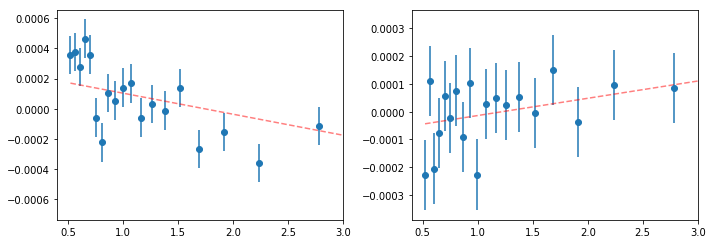

In [109]:
fig, ax = plt.subplots(1,2,sharex = True, figsize=(10,3.5))
duv = e1_y3
b_=duv['mut'][0][0]
print (b_)
ax[0].plot(duv['x0'],b_*(duv['x0'])+duv['mut'][0][1],alpha = 0.5,color='red',linestyle='dashed',label=r'from $\rho$ stats.')
ax[0].errorbar(duv['x0'],duv['vec'],duv['err'],fmt='o', label = 'Y3')
#plt.xscale('log')
#fig, ax = plt.subplots(1,2,sharex = True, figsize=(10,3.5))
duv = e2_y3
b_=duv['mut'][0][0]
print (b_)
ax[1].plot(duv['x0'],b_*(duv['x0'])+duv['mut'][0][1],alpha = 0.5,color='red',linestyle='dashed',label=r'from $\rho$ stats.')
ax[1].errorbar(duv['x0'],duv['vec'],duv['err'],fmt='o', label = 'Y3')
#plt.xscale('log')
plt.xlim([0.4,3])

dictt = dict()
dictt['e1'] = e1_y3
dictt['e2'] = e2_y3
save_obj('../final_plots_paper/just_another_pkl_file',dictt)

6.685939376925439e-10

# plots for paper

In [17]:


TT = 20
xmm = np.mean(sample_dict['psf_e1'][maskj])

mask = (sample_dict['psf_e1']>-0.03) &  (sample_dict['psf_e1']<0.03)
x = sample_dict['psf_e1'][mask]
y = sample_dict['e1'][mask]

vec = np.zeros(TT)

bound = [np.quantile(x,1.*(i*1)/TT) for i in range(TT+1)]
vec = [np.mean(y[(x>bound[i])&(x<bound[i+1])]) for i in range(TT)]
err = [np.std(y)/np.sqrt(len(y[(x>bound[i])&(x<bound[i+1])])) for i in range(TT)]
x0 = (np.array(bound[1:])+np.array(bound[:-1]))*0.5
mut = np.polyfit(sample_dict['psf_e1'][maskj]-np.mean(sample_dict['psf_e1'][maskj]),sample_dict['e1'+kk][maskj],1,cov =True)

e1_y3 = {'bound':bound,'vec':vec,'err':err,'x0':x0,'mut':mut,'xmm':xmm}





xmm = np.mean(sample_dict_y1['psf_e1'])

mask = (sample_dict_y1['psf_e1']>-0.03) &  (sample_dict_y1['psf_e1']<0.03)
x = sample_dict_y1['psf_e1'][mask]
y = sample_dict_y1['e1'][mask]

vec = np.zeros(TT)

#bound = [np.quantile(x,1.*(i*1)/TT) for i in range(TT+1)]
vec = [np.mean(y[(x>bound[i])&(x<bound[i+1])]) for i in range(TT)]
err = [np.std(y)/np.sqrt(len(y[(x>bound[i])&(x<bound[i+1])])) for i in range(TT)]
x0 = (np.array(bound[1:])+np.array(bound[:-1]))*0.5
mut = np.polyfit(sample_dict_y1['psf_e1']-np.mean(sample_dict_y1['psf_e1']),sample_dict_y1['e1'+kk],1,cov =True)

e1_y1 = {'bound':bound,'vec':vec,'err':err,'x0':x0,'mut':mut,'xmm':xmm}







TT = 20
xmm = np.mean(sample_dict['psf_e2'][maskj])

mask = (sample_dict['psf_e2']>-0.03) &  (sample_dict['psf_e2']<0.03)
x = sample_dict['psf_e2'][mask]
y = sample_dict['e2'][mask]

vec = np.zeros(TT)

bound = [np.quantile(x,1.*(i*1)/TT) for i in range(TT+1)]
vec = [np.mean(y[(x>bound[i])&(x<bound[i+1])]) for i in range(TT)]
err = [np.std(y)/np.sqrt(len(y[(x>bound[i])&(x<bound[i+1])])) for i in range(TT)]
x0 = (np.array(bound[1:])+np.array(bound[:-1]))*0.5
mut = np.polyfit(sample_dict['psf_e2'][maskj]-np.mean(sample_dict['psf_e2'][maskj]),sample_dict['e2'+kk][maskj],1,cov =True)

e2_y3 = {'bound':bound,'vec':vec,'err':err,'x0':x0,'mut':mut,'xmm':xmm}






xmm = np.mean(sample_dict_y1['psf_e2'])

mask = (sample_dict_y1['psf_e2']>-0.03) &  (sample_dict_y1['psf_e2']<0.03)
x = sample_dict_y1['psf_e2'][mask]
y = sample_dict_y1['e2'][mask]

vec = np.zeros(TT)

#bound = [np.quantile(x,1.*(i*1)/TT) for i in range(TT+1)]
vec = [np.mean(y[(x>bound[i])&(x<bound[i+1])]) for i in range(TT)]
err = [np.std(y)/np.sqrt(len(y[(x>bound[i])&(x<bound[i+1])])) for i in range(TT)]
x0 = (np.array(bound[1:])+np.array(bound[:-1]))*0.5
mut = np.polyfit(sample_dict_y1['psf_e2']-np.mean(sample_dict_y1['psf_e2']),sample_dict_y1['e2'+kk],1,cov =True)

e2_y1 = {'bound':bound,'vec':vec,'err':err,'x0':x0,'mut':mut,'xmm':xmm}




In [18]:


TT = 20
xmm = np.mean(sample_dict['psf_size'][maskj])

mask = (sample_dict['psf_size']>0.3) &  (sample_dict['psf_size']<0.6)
x = sample_dict['psf_size'][mask]
y = sample_dict['e1'][mask]

vec = np.zeros(TT)

bound = [np.quantile(x,1.*(i*1)/TT) for i in range(TT+1)]
vec = [np.mean(y[(x>bound[i])&(x<bound[i+1])]) for i in range(TT)]
err = [np.std(y)/np.sqrt(len(y[(x>bound[i])&(x<bound[i+1])])) for i in range(TT)]
x0 = (np.array(bound[1:])+np.array(bound[:-1]))*0.5
mut = np.polyfit(sample_dict['psf_size'][maskj]-np.mean(sample_dict['psf_size'][maskj]),sample_dict['e1'+kk][maskj],1,cov =True)

Se1_y3 = {'bound':bound,'vec':vec,'err':err,'x0':x0,'mut':mut,'xmm':xmm}





xmm = np.mean(sample_dict_y1['psf_size'])

mask = (sample_dict_y1['psf_size']>0.3) &  (sample_dict_y1['psf_size']<0.6)
x = sample_dict_y1['psf_size'][mask]
y = sample_dict_y1['e1'][mask]

vec = np.zeros(TT)

#bound = [np.quantile(x,1.*(i*1)/TT) for i in range(TT+1)]
vec = [np.mean(y[(x>bound[i])&(x<bound[i+1])]) for i in range(TT)]
err = [np.std(y)/np.sqrt(len(y[(x>bound[i])&(x<bound[i+1])])) for i in range(TT)]
x0 = (np.array(bound[1:])+np.array(bound[:-1]))*0.5
mut = np.polyfit(sample_dict_y1['psf_size']-np.mean(sample_dict_y1['psf_size']),sample_dict_y1['e1'+kk],1,cov =True)

Se1_y1 = {'bound':bound,'vec':vec,'err':err,'x0':x0,'mut':mut,'xmm':xmm}







TT = 20
xmm = np.mean(sample_dict['psf_size'][maskj])

mask = (sample_dict['psf_size']>0.3) &  (sample_dict['psf_size']<0.6)
x = sample_dict['psf_size'][mask]
y = sample_dict['e2'][mask]

vec = np.zeros(TT)

bound = [np.quantile(x,1.*(i*1)/TT) for i in range(TT+1)]
vec = [np.mean(y[(x>bound[i])&(x<bound[i+1])]) for i in range(TT)]
err = [np.std(y)/np.sqrt(len(y[(x>bound[i])&(x<bound[i+1])])) for i in range(TT)]
x0 = (np.array(bound[1:])+np.array(bound[:-1]))*0.5
mut = np.polyfit(sample_dict['psf_e2'][maskj]-np.mean(sample_dict['psf_e2'][maskj]),sample_dict['e2'+kk][maskj],1,cov =True)

Se2_y3 = {'bound':bound,'vec':vec,'err':err,'x0':x0,'mut':mut,'xmm':xmm}






xmm = np.mean(sample_dict_y1['psf_size'])

mask = (sample_dict_y1['psf_size']>0.3) &  (sample_dict_y1['psf_size']<0.6)
x = sample_dict_y1['psf_size'][mask]
y = sample_dict_y1['e2'][mask]

vec = np.zeros(TT)

#bound = [np.quantile(x,1.*(i*1)/TT) for i in range(TT+1)]
vec = [np.mean(y[(x>bound[i])&(x<bound[i+1])]) for i in range(TT)]
err = [np.std(y)/np.sqrt(len(y[(x>bound[i])&(x<bound[i+1])])) for i in range(TT)]
x0 = (np.array(bound[1:])+np.array(bound[:-1]))*0.5
mut = np.polyfit(sample_dict_y1['psf_size']-np.mean(sample_dict_y1['psf_size']),sample_dict_y1['e2'+kk],1,cov =True)

Se2_y1 = {'bound':bound,'vec':vec,'err':err,'x0':x0,'mut':mut,'xmm':xmm}




In [21]:
final_dict = dict()
final_dict['e2_y1']= e2_y1
final_dict['e1_y1']= e1_y1
y = np.array([dd1_dp1,dd1_dq1,dd1_dw1])

A = np.array([[1.,dq1_dp1,dw1_dp1],
    [dp1_dq1,1.,dw1_dq1],
    [dp1_dw1,dq1_dw1,1.]])
L = np.array([dp1_dPSF1,dq1_dPSF1,dw1_dPSF1] )
final_dict['L1']= L
final_dict['y1']= y
final_dict['A1']= A

y = np.array([dd2_dp2,dd2_dq2,dd2_dw2])

A = np.array([[1.,dq2_dp2,dw2_dp2],
        [dp2_dq2,1.,dw2_dq2],
        [dp2_dw2,dq2_dw2,1.]])

L = np.array([dp2_dPSF2,dq2_dPSF2,dw2_dPSF2] )

final_dict['y2']= y
final_dict['A2']= A
final_dict['L2']= L
save_obj('tit',final_dict)

NameError: name 'e2_y1' is not defined

In [4]:
L = np.array([dp1_dPSF1,dq2_dPSF2,dw2_dPSF2] )


NameError: name 'np' is not defined

[ 0.75698573 -0.49363789  0.73665216]
(-0.010796155732835528, 0.003549363715046871)
[ 0.85306465 -0.19686935  0.3438047 ]


/global/homes/m/mgatti/.conda/envs/myenv_up/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


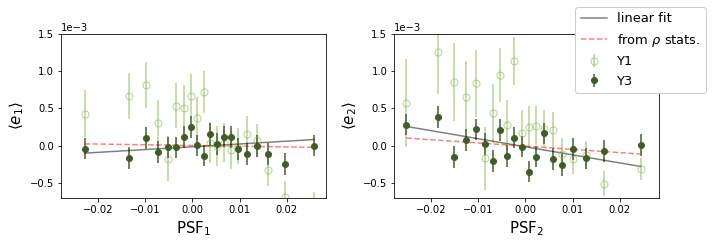

In [19]:
# prepare for plots
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

c_2=rgb_to_hex((39, 196, 96))
c_3=rgb_to_hex((55, 94, 50)) 
c_2=rgb_to_hex((121, 183, 179)) 
c_2 ='#82B74B'

c_3 ='#405D27'
#405D27
#82B74B

colors = [c_2,c_3]

fig, ax = plt.subplots(1,2,sharex = True, figsize=(10,3.5))


#****************************
duv = e1_y1 
ax[0].errorbar(duv['x0'],duv['vec'],duv['err'],fmt='o',alpha = 0.6,label = 'Y1' ,markersize=7,markerfacecoloralt=c_2,color=c_2,fillstyle='none')

duv = e1_y3 
ax[0].errorbar(duv['x0'],duv['vec'],duv['err'],fmt='o',color=c_3, label = 'Y3')


b_ =  duv['mut'][0][0]
ax[0].plot(duv['x0'],b_*(duv['x0']-duv['xmm']),alpha = 0.5,color='black',label='linear fit')
#ax[0].fill_between(duv['x0'], (b_+np.sqrt(duv['mut'][1][0,0]))*(duv['x0']-duv['xmm']),(b_-np.sqrt(duv['mut'][1][0,0]))*(duv['x0']-duv['xmm']),alpha = 0.5,color="black",label="real plane coord.")

   
y = np.array([dd1_dp1,dd1_dq1,dd1_dw1])[:,0]
L = np.array([dp1_dPSF1,dq1_dPSF1,dw1_dPSF1] )


b_ = np.sum(y*L)


y = np.array([dd1_dp1,dd1_dq1,dd1_dw1])
L = np.array([dp1_dPSF1,dq1_dPSF1,dw1_dPSF1] )

y[0,:]*=L[0]
y[1,:]*=L[1]
y[2,:]*=L[2]
print y[:,0]/np.sum(y[:,0])
y = np.sum(y,axis=0)

dus = covariance_scalar_jck(y[1:],1000,'jackknife')
b_=y[0]
ax[0].plot(duv['x0'],b_*(duv['x0']-duv['xmm']),alpha = 0.5,color='red',linestyle='dashed',label=r'from $\rho$ stats.')
#ax[0].fill_between(x0, (b_+dus['err'])*(x0-xmm),(b_-dus['err'])*(x0-xmm),alpha = 0.5,color="red",label="focal plane coord.")









#****************************
duv = e2_y1 
ax[1].errorbar(duv['x0'],duv['vec'],duv['err'],fmt='o', alpha = 0.6,label = 'Y1' ,markersize=7,markerfacecoloralt=c_2,color=c_2,fillstyle='none')

duv = e2_y3 
ax[1].errorbar(duv['x0'],duv['vec'],duv['err'],fmt='o',color=c_3, label = 'Y3')

b_ =  duv['mut'][0][0]
ax[1].plot(duv['x0'],b_*(duv['x0']-duv['xmm']),alpha = 0.5,color='black',label='linear fit')
#ax[1].fill_between(duv['x0'], (b_+np.sqrt(duv['mut'][1][0,0]))*(duv['x0']-duv['xmm']),(b_-np.sqrt(duv['mut'][1][0,0]))*(duv['x0']-duv['xmm']),alpha = 0.5,color="black",label="real plane coord.")

print (b_,np.sqrt(duv['mut'][1][0,0]))
y = np.array([dd1_dp1,dd1_dq1,dd1_dw1])[:,0]
L = np.array([dp1_dPSF1,dq1_dPSF1,dw1_dPSF1] )


b_ = np.sum(y*L)



y = np.array([dd1_dp1,dd1_dq1,dd1_dw1])

A = np.array([[1.,dq1_dp1,dw1_dp1],
    [dp1_dq1,1.,dw1_dq1],
    [dp1_dw1,dq1_dw1,1.]])


    

y = np.array([dd2_dp2,dd2_dq2,dd2_dw2])

A = np.array([[1.,dq2_dp2,dw2_dp2],
        [dp2_dq2,1.,dw2_dq2],
        [dp2_dw2,dq2_dw2,1.]])

xd = np.linalg.solve(A,y)


L = np.array([dp2_dPSF2,dq2_dPSF2,dw2_dPSF2] )

y[0,:]*=L[0]
y[1,:]*=L[1]
y[2,:]*=L[2]
print y[:,0]/np.sum(y[:,0])
y = np.sum(y,axis=0)

dus = covariance_scalar_jck(y[1:],1000,'jackknife')
b_=y[0]
ax[1].plot(duv['x0'],b_*(duv['x0']-duv['xmm']),alpha = 0.5,color='red',linestyle='dashed',label=r'from $\rho$ stats.')
#ax[1].fill_between(x0, (b_+dus['err'])*(x0-xmm),(b_-dus['err'])*(x0-xmm),alpha = 0.5,color="red",label="focal plane coord.")



















ax[1].legend(loc="upper right", bbox_to_anchor=(1.2,1.2),fontsize=13,framealpha=1)

ax[0].set_ylabel(r"$\langle e_1 \rangle$",size=15)
ax[1].set_ylabel(r"$\langle e_2 \rangle$",size=15)
ax[0].set_xlabel(r"${\rm PSF}_1$",size=15)
ax[1].set_xlabel(r"${\rm PSF}_2$",size=15)
ax[1].set_ylim([-0.0007,0.0015])
ax[0].set_ylim([-0.0007,0.0015])
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.tight_layout()
plt.savefig('e_PSF_y3y1.pdf',bbox_inches='tight')
plt.show()

In [ ]:
# prepare for plots
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

c_2=rgb_to_hex((39, 196, 96))
c_3=rgb_to_hex((55, 94, 50)) 
c_2=rgb_to_hex((121, 183, 179)) 
c_2 ='#82B74B'

c_3 ='#405D27'
#405D27
#82B74B

colors = [c_2,c_3]

fig, ax = plt.subplots(1,2,sharex = True, figsize=(10,3.5))


#****************************
duv = Se1_y1 
ax[0].errorbar(duv['x0'],duv['vec'],duv['err'],fmt='o',alpha = 0.6,label = 'Y1' ,markersize=7,markerfacecoloralt=c_2,color=c_2,fillstyle='none')

duv = Se1_y3 
ax[0].errorbar(duv['x0'],duv['vec'],duv['err'],fmt='o',color=c_3, label = 'Y3')


b_ =  duv['mut'][0][0]
#ax[0].plot(duv['x0'],b_*(duv['x0']-duv['xmm']),alpha = 0.5,color='black',label='linear fit')
#ax[0].fill_between(duv['x0'], (b_+np.sqrt(duv['mut'][1][0,0]))*(duv['x0']-duv['xmm']),(b_-np.sqrt(duv['mut'][1][0,0]))*(duv['x0']-duv['xmm']),alpha = 0.5,color="black",label="real plane coord.")

   
y = np.array([dd1_dp1,dd1_dq1,dd1_dw1])[:,0]
L = np.array([dp1_dPSF1,dq1_dPSF1,dw1_dPSF1] )


b_ = np.sum(y*L)


y = np.array([dd1_dp1,dd1_dq1,dd1_dw1])
L = np.array([dp1_dPSF1,dq1_dPSF1,dw1_dPSF1] )

y[0,:]*=L[0]
y[1,:]*=L[1]
y[2,:]*=L[2]
print y[:,0]/np.sum(y[:,0])
y = np.sum(y,axis=0)

dus = covariance_scalar_jck(y[1:],1000,'jackknife')
b_=y[0]
#ax[0].plot(duv['x0'],b_*(duv['x0']-duv['xmm']),alpha = 0.5,color='red',linestyle='dashed',label=r'from $\rho$ stats.')
#ax[0].fill_between(x0, (b_+dus['err'])*(x0-xmm),(b_-dus['err'])*(x0-xmm),alpha = 0.5,color="red",label="focal plane coord.")









#****************************
duv = Se2_y1 
ax[1].errorbar(duv['x0'],duv['vec'],duv['err'],fmt='o', alpha = 0.6,label = 'Y1' ,markersize=7,markerfacecoloralt=c_2,color=c_2,fillstyle='none')

duv = Se2_y3 
ax[1].errorbar(duv['x0'],duv['vec'],duv['err'],fmt='o',color=c_3, label = 'Y3')

b_ =  duv['mut'][0][0]
#ax[1].plot(duv['x0'],b_*(duv['x0']-duv['xmm']),alpha = 0.5,color='black',label='linear fit')
#ax[1].fill_between(duv['x0'], (b_+np.sqrt(duv['mut'][1][0,0]))*(duv['x0']-duv['xmm']),(b_-np.sqrt(duv['mut'][1][0,0]))*(duv['x0']-duv['xmm']),alpha = 0.5,color="black",label="real plane coord.")

print (b_,np.sqrt(duv['mut'][1][0,0]))
y = np.array([dd1_dp1,dd1_dq1,dd1_dw1])[:,0]
L = np.array([dp1_dPSF1,dq1_dPSF1,dw1_dPSF1] )


b_ = np.sum(y*L)



y = np.array([dd1_dp1,dd1_dq1,dd1_dw1])

A = np.array([[1.,dq1_dp1,dw1_dp1],
    [dp1_dq1,1.,dw1_dq1],
    [dp1_dw1,dq1_dw1,1.]])


    

y = np.array([dd2_dp2,dd2_dq2,dd2_dw2])

A = np.array([[1.,dq2_dp2,dw2_dp2],
        [dp2_dq2,1.,dw2_dq2],
        [dp2_dw2,dq2_dw2,1.]])

xd = np.linalg.solve(A,y)


L = np.array([dp2_dPSF2,dq2_dPSF2,dw2_dPSF2] )

y[0,:]*=L[0]
y[1,:]*=L[1]
y[2,:]*=L[2]
print y[:,0]/np.sum(y[:,0])
y = np.sum(y,axis=0)

dus = covariance_scalar_jck(y[1:],1000,'jackknife')
b_=y[0]
#ax[1].plot(duv['x0'],b_*(duv['x0']-duv['xmm']),alpha = 0.5,color='red',linestyle='dashed',label=r'from $\rho$ stats.')
#ax[1].fill_between(x0, (b_+dus['err'])*(x0-xmm),(b_-dus['err'])*(x0-xmm),alpha = 0.5,color="red",label="focal plane coord.")



















ax[1].legend(loc="upper right", bbox_to_anchor=(1.2,1.2),fontsize=13,framealpha=1)

ax[0].set_ylabel(r"$\langle e_1 \rangle$",size=15)
ax[1].set_ylabel(r"$\langle e_2 \rangle$",size=15)
ax[0].set_xlabel(r"${\rm PSF size}$",size=15)
ax[1].set_xlabel(r"${\rm PSF size}$",size=15)
ax[1].set_ylim([-0.0007,0.0007])
ax[0].set_ylim([-0.0007,0.0007])
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.tight_layout()
plt.savefig('e_PSFsize_y3y1.pdf',bbox_inches='tight')
plt.show()

In [37]:
L = np.array([dp2_dPSF2,dq2_dPSF2,dw2_dPSF2] )
params = [0.009,2.29,1.9]
print L,L*params

L = np.array([dp1_dPSF1,dq1_dPSF1,dw1_dPSF1] )
params = [0.009,2.29,1.9]
print L,L*params

[ 1.00000000e+00  7.78450031e-02 -4.89903521e-04] [ 0.009       0.17826506 -0.00093082]
[ 1.00000000e+00  9.12695380e-02 -4.83049124e-04] [ 0.009       0.20900724 -0.00091779]


In [300]:

y = np.array([dd2_dp2,dd2_dq2,dd2_dw2])

A = np.array([[1.,dq2_dp2,dw2_dp2],
        [dp2_dq2,1.,dw2_dq2],
        [dp2_dw2,dq2_dw2,1.]])

xd = np.linalg.solve(A,y)

xd[0] = 0.
xd[1] = 0.
#xd[2] = 0.

y = np.matmul(A,xd)
L = np.array([dp2_dPSF2,dq2_dPSF2,dw2_dPSF2] )

y[0,:]*=L[0]
y[1,:]*=L[1]
y[2,:]*=L[2]
y = np.sum(y,axis=0)

print y[0]

-0.00015263051330405633


In [276]:
dq2_dPSF2

0.0005897079309244818

In [271]:
y = np.array([dd2_dp2,dd2_dq2,dd2_dw2])
L = np.array([dp2_dPSF2,dq2_dPSF2,dw2_dPSF2] )

y[0,:]*=L[0]
y[1,:]*=L[1]
y[2,:]*=L[2]
y = np.sum(y,axis=0)
print y[0]

-0.004300629808609506


ValueError: operands could not be broadcast together with shapes (3,1001) (3,) 

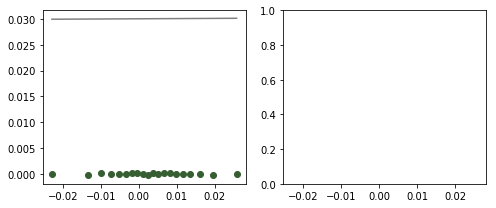

In [110]:
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

c_2=rgb_to_hex((239, 96, 96))
c_3=rgb_to_hex((55, 94, 50)) 
c_23=rgb_to_hex((121, 183, 179)) 
colors = [c_2,c_3,c_23]



fig, ax = plt.subplots(1,2,sharex = True, figsize=(7,3))




TT = 20
mask = (sample_dict['psf_e1']>-0.03) &  (sample_dict['psf_e1']<0.03)
x = sample_dict['psf_e1'][mask]
y = sample_dict['e1'][mask]

vec = np.zeros(TT)

bound = [np.quantile(x,1.*(i*1)/TT) for i in range(TT+1)]
vec = [np.mean(y[(x>bound[i])&(x<bound[i+1])]) for i in range(TT)]
err = [np.std(y[(x>bound[i])&(x<bound[i+1])])/np.sqrt(len(y[(x>bound[i])&(x<bound[i+1])])) for i in range(TT)]
x0 = (np.array(bound[1:])+np.array(bound[:-1]))*0.5
ax[0].errorbar(x0,vec,err,fmt='o',color=c_3, label = 'Y3')
xmm = np.mean(sample_dict['psf_e1'][maskj])
mut = np.polyfit(sample_dict['psf_e1'][maskj]-np.mean(sample_dict['psf_e1'][maskj]),sample_dict['e1'+kk][maskj],1,cov =True)
b_ =  mut[0][0]
ax[0].plot(x0,b_*(x0-xmm),alpha = 0.5,color='black')

y = np.array([dd1_dp1,dd1_dq1,dd1_dw1])
L = np.array([dp1_dPSF1,dq1_dPSF1,dw1_dPSF1] )

b_ = np.sum(y*L)
ax[0].plot(x0,b_*(x0-xmm),alpha = 0.5,color='red')






TT = 20
mask = (sample_dict['psf_e2']>-0.03) &  (sample_dict['psf_e2']<0.03)
x = sample_dict['psf_e2'][mask]
y = sample_dict['e2'][mask]

vec = np.zeros(TT)

bound = [np.quantile(x,1.*(i*1)/TT) for i in range(TT+1)]
vec = [np.mean(y[(x>bound[i])&(x<bound[i+1])]) for i in range(TT)]
err = [np.std(y[(x>bound[i])&(x<bound[i+1])])/np.sqrt(len(y[(x>bound[i])&(x<bound[i+1])])) for i in range(TT)]
x0 = (np.array(bound[1:])+np.array(bound[:-1]))*0.5
ax[1].errorbar(x0,vec,err,fmt='o',color=c_3, label = 'Y3')

xmm = np.mean(sample_dict['psf_e2'][maskj])
mut = np.polyfit(sample_dict['psf_e2'][maskj]-np.mean(sample_dict['psf_e2'][maskj]),sample_dict['e2'+kk][maskj],1,cov =True)
b_ =  mut[0][0]
ax[0].plot(x0,b_*(x0-xmm),alpha = 0.5,color='black')

y = np.array([dd2_dp2,dd2_dq2,dd2_dw2])
L = np.array([dp2_dPSF2,dq2_dPSF2,dw2_dPSF2] )

b_ = np.sum(y*L)
ax[0].plot(x0,b_*(x0-xmm),alpha = 0.5,color='red')







TT = 20
mask = (sample_dict_y1['psf_e1']>-0.03) &  (sample_dict_y1['psf_e1']<0.03)
x = sample_dict_y1['psf_e1'][mask]
y = sample_dict_y1['e1'][mask]

vec = np.zeros(TT)

bound = [np.quantile(x,1.*(i*1)/TT) for i in range(TT+1)]
vec = [np.mean(y[(x>bound[i])&(x<bound[i+1])]) for i in range(TT)]
err = [np.std(y[(x>bound[i])&(x<bound[i+1])])/np.sqrt(len(y[(x>bound[i])&(x<bound[i+1])])) for i in range(TT)]
x0 = (np.array(bound[1:])+np.array(bound[:-1]))*0.5
ax[0].errorbar(x0,vec,err,fmt='o',color=c_23, linestyle = 'dashed',label = 'Y1')



TT = 20
mask = (sample_dict_y1['psf_e2']>-0.03) &  (sample_dict_y1['psf_e2']<0.03)
x = sample_dict_y1['psf_e2'][mask]
y = sample_dict_y1['e2'][mask]

vec = np.zeros(TT)

bound = [np.quantile(x,1.*(i*1)/TT) for i in range(TT+1)]
vec = [np.mean(y[(x>bound[i])&(x<bound[i+1])]) for i in range(TT)]
err = [np.std(y[(x>bound[i])&(x<bound[i+1])])/np.sqrt(len(y[(x>bound[i])&(x<bound[i+1])])) for i in range(TT)]
x0 = (np.array(bound[1:])+np.array(bound[:-1]))*0.5
ax[1].errorbar(x0,vec,err,fmt='*',color=c_2,label = 'Y1')



ax[0].legend(loc="upper left", bbox_to_anchor=(.05,0.3))
ax[1].legend(loc="upper left", bbox_to_anchor=(.05,0.3))

ax[0].set_ylabel("$<e_1>$")
ax[1].set_ylabel("$<e_2>$")
ax[0].set_xlabel("$PSF_1$")
ax[1].set_xlabel("$PSF_2$")

plt.savefig("E_PSF_"+binx+".pdf")


plt.legend()
plt.show()


In [ ]:
1

fit E1/PSF_E1 : 0.0055 +- 0.0043 [sigma: 1.2778]
fit E2/PSF_E2 : -0.0034 +- 0.0041 [sigma: -0.8433]


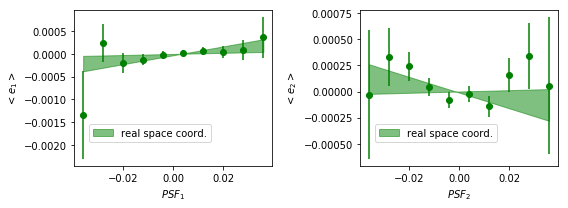

In [15]:
lenp=10
fig, ax = plt.subplots(1,2,sharex=False, sharey=False, figsize=(8,3))
y = dict_tot[binx]['e1'][dict_tot[binx]['info']['mask_sims']]
x = dict_tot[binx]['psf_e1'][dict_tot[binx]['info']['mask_sims']]

nbins = np.linspace(-0.04,0.04,lenp+1)
mn = []
mne = []
for i in range(lenp):

    maska = (x>nbins[i])&(x<nbins[i+1])
    n, _ = np.histogram(x[maska], bins=nbins)
    mn.append(np.mean(y[maska]))
    mne.append(np.std(y)/np.sqrt(len(y[maska])))

xx = 0.5*(nbins[1:]+nbins[:-1])
beta = dict_systematics_tot_E[binx]['E1']['_w0']['PSF_E1']['b_arr'][0]
b_err = dict_systematics_tot_E[binx]['E1']['_w0']['PSF_E1']['b_err']#[0]
print ("fit E1/PSF_E1 : {0:2.4f} +- {1:2.4f} [sigma: {2:2.4f}]").format(beta,dict_systematics_tot_E[binx]['E1']['_w0']['PSF_E1']['b_err'],beta/dict_systematics_tot_E[binx]['E1']['_w0']['PSF_E1']['b_err'])


ax[0].errorbar(xx,mn-np.mean(y),mne,fmt = 'o',color='green')
ax[0].fill_between(xx, (beta+b_err)*(xx-np.mean(x)),(beta-b_err)*(xx-np.mean(x)),alpha = 0.5,color="green",label="real space coord.")







#**************************
y = dict_tot[binx]['e2'][dict_tot[binx]['info']['mask_sims']]
x = dict_tot[binx]['psf_e2'][dict_tot[binx]['info']['mask_sims']]

nbins = np.linspace(-0.04,0.04,lenp+1)
mn = []
mne = []
for i in range(lenp):

    maska = (x>nbins[i])&(x<nbins[i+1])
    n, _ = np.histogram(x[maska], bins=nbins)
    mn.append(np.mean(y[maska]))
    mne.append(np.std(y)/np.sqrt(len(y[maska])))

xx = 0.5*(nbins[1:]+nbins[:-1])
beta = dict_systematics_tot_E[binx]['E2']['_w0']['PSF_E2']['b_arr'][0]
b_err = dict_systematics_tot_E[binx]['E2']['_w0']['PSF_E2']['b_err']#[0]
print ("fit E2/PSF_E2 : {0:2.4f} +- {1:2.4f} [sigma: {2:2.4f}]").format(beta,dict_systematics_tot_E[binx]['E2']['_w0']['PSF_E2']['b_err'],beta/dict_systematics_tot_E[binx]['E2']['_w0']['PSF_E2']['b_err'])

ax[1].errorbar(xx,mn-np.mean(y),mne,fmt = 'o',color='green')
ax[1].fill_between(xx, (beta+b_err)*(xx-np.mean(x)),(beta-b_err)*(xx-np.mean(x)),alpha = 0.5,color="green",label="real space coord.")




ax[0].legend(loc="upper left", bbox_to_anchor=(.05,0.3))
ax[1].legend(loc="upper left", bbox_to_anchor=(.05,0.3))



ax[0].set_ylabel("$<e_1>$")
ax[1].set_ylabel("$<e_2>$")
ax[0].set_xlabel("$PSF_1$")
ax[1].set_xlabel("$PSF_2$")

plt.savefig("E_PSF_"+binx+".pdf")


fit E1/PSF_E1 : 0.0038 +- 0.0073 [sigma: 0.5132]
fit E2/PSF_E2 : 0.0010 +- 0.0073 [sigma: 0.1413]


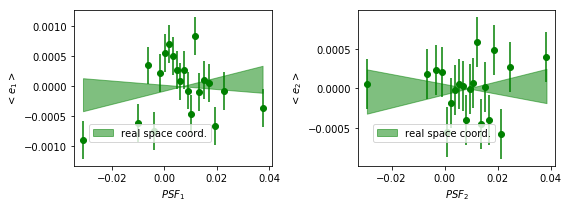

In [49]:
lenp=20
fig, ax = plt.subplots(1,2,sharex=False, sharey=False, figsize=(8,3))
y = dict_tot_y1[binx]['e1'][dict_tot_y1[binx]['info']['mask_sims']]
x = dict_tot_y1[binx]['psf_e1'][dict_tot_y1[binx]['info']['mask_sims']]

mu = (x>-0.05) & (x<0.05)
y=y[mu]
x=x[mu]
nbins = np.linspace(-0.04,0.04,lenp+1)

nbins = np.array([np.quantile(x,1.*(i*1)/lenp) for i in range(lenp+1)])

mn = []
mne = []
for i in range(lenp):

    maska = (x>nbins[i])&(x<nbins[i+1])
    n, _ = np.histogram(x[maska], bins=nbins)
    mn.append(np.mean(y[maska]))
    mne.append(np.std(y)/np.sqrt(len(y[maska])))

xx = 0.5*(nbins[1:]+nbins[:-1])
beta = dict_systematics_tot_E_y1[binx]['E1']['_w0']['PSF_E1']['b_arr'][0]
b_err = dict_systematics_tot_E_y1[binx]['E1']['_w0']['PSF_E1']['b_err']#[0]
print ("fit E1/PSF_E1 : {0:2.4f} +- {1:2.4f} [sigma: {2:2.4f}]").format(beta,dict_systematics_tot_E_y1[binx]['E1']['_w0']['PSF_E1']['b_err'],beta/dict_systematics_tot_E_y1[binx]['E1']['_w0']['PSF_E1']['b_err'])


ax[0].errorbar(xx,mn-np.mean(y),mne,fmt = 'o',color='green')
ax[0].fill_between(xx, (beta+b_err)*(xx-np.mean(x)),(beta-b_err)*(xx-np.mean(x)),alpha = 0.5,color="green",label="real space coord.")







#**************************
y = dict_tot_y1[binx]['e2'][dict_tot_y1[binx]['info']['mask_sims']]
x = dict_tot_y1[binx]['psf_e2'][dict_tot_y1[binx]['info']['mask_sims']]

mu = (x>-0.05) & (x<0.05)
y=y[mu]
x=x[mu]
nbins = np.linspace(-0.04,0.04,lenp+1)

nbins =  np.array([np.quantile(x,1.*(i*1)/lenp) for i in range(lenp+1)])
mn = []
mne = []
for i in range(lenp):

    maska = (x>nbins[i])&(x<nbins[i+1])
    n, _ = np.histogram(x[maska], bins=nbins)
    mn.append(np.mean(y[maska]))
    mne.append(np.std(y)/np.sqrt(len(y[maska])))

xx = 0.5*(nbins[1:]+nbins[:-1])
beta = dict_systematics_tot_E_y1[binx]['E2']['_w0']['PSF_E2']['b_arr'][0]
b_err = dict_systematics_tot_E_y1[binx]['E2']['_w0']['PSF_E2']['b_err']#[0]
print ("fit E2/PSF_E2 : {0:2.4f} +- {1:2.4f} [sigma: {2:2.4f}]").format(beta,dict_systematics_tot_E_y1[binx]['E2']['_w0']['PSF_E2']['b_err'],beta/dict_systematics_tot_E_y1[binx]['E2']['_w0']['PSF_E2']['b_err'])

ax[1].errorbar(xx,mn-np.mean(y),mne,fmt = 'o',color='green')
ax[1].fill_between(xx, (beta+b_err)*(xx-np.mean(x)),(beta-b_err)*(xx-np.mean(x)),alpha = 0.5,color="green",label="real space coord.")




ax[0].legend(loc="upper left", bbox_to_anchor=(.05,0.3))
ax[1].legend(loc="upper left", bbox_to_anchor=(.05,0.3))



ax[0].set_ylabel("$<e_1>$")
ax[1].set_ylabel("$<e_2>$")
ax[0].set_xlabel("$PSF_1$")
ax[1].set_xlabel("$PSF_2$")

plt.savefig("E_PSF_"+binx+".pdf")


(array([   970.,   2787.,   8599.,  24057.,  55181.,  89505., 104083.,
         86875.,  52147.,  24047.]),
 array([-2.99933600e-02, -2.39940420e-02, -1.79947240e-02, -1.19954061e-02,
        -5.99608808e-03,  3.22990486e-06,  6.00254789e-03,  1.20018659e-02,
         1.80011839e-02,  2.40005018e-02,  2.99998198e-02]),
 <a list of 10 Patch objects>)

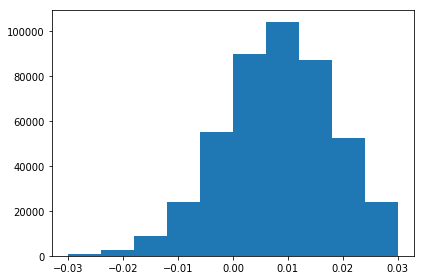

In [48]:
plt.hist(x)

# tes

Unnamed: 0
e1
bpz_zmc
e1


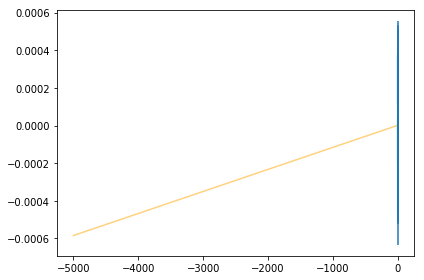

bpz_zmean
e1
dec
e1
e1
e1
e1_rndm_rot
e1
e2
e1
e2_rndm_rot
e1
ebv
e1
idx
e1
info
e1
jk
e1


In [ ]:
TT= 30
for  key in sample_dict.keys():
    try:
        print key
        print 'e1'

        x = sample_dict[key]
        y = sample_dict['e1']

        mask = (x==x) & (y==y)
        x=x[mask]
        y=y[mask]

        vec = np.zeros(TT)

        bound = [np.quantile(x,1.*(i*1)/TT) for i in range(TT+1)]
        vec = [np.mean(y[(x>bound[i])&(x<bound[i+1])]) for i in range(TT)]
        err = [np.std(y[(x>bound[i])&(x<bound[i+1])])/np.sqrt(len(y[(x>bound[i])&(x<bound[i+1])])) for i in range(TT)]
        x0 = (np.array(bound[1:])+np.array(bound[:-1]))*0.5
        plt.errorbar(x0[1:-1],vec[1:-1],err[1:-1])

        xmm = np.mean(sample_dict[key])
        b_=dict_systematics_tot_E_full[binx]['E1'][key]['b_arr'][0]
        plt.plot(x0,b_*(x0-xmm),alpha = 0.5,color='orange')


        plt.show()


        print 'e2'
        y = sample_dict['e2']
        mask = (x==x) & (y==y)
        x=x[mask]
        y=y[mask]
        vec = np.zeros(TT)

        vec = [np.mean(y[(x>bound[i])&(x<bound[i+1])]) for i in range(TT)]
        err = [np.std(y[(x>bound[i])&(x<bound[i+1])])/np.sqrt(len(y[(x>bound[i])&(x<bound[i+1])])) for i in range(TT)]
        x0 = (np.array(bound[1:])+np.array(bound[:-1]))*0.5
        plt.errorbar(x0[1:-1],vec[1:-1],err[1:-1])
        b_=dict_systematics_tot_E_full[binx]['E2'][key]['b_arr'][0]
        plt.plot(x0,b_*(x0-xmm),alpha = 0.5,color='orange')

        plt.show()
    except:
        pass

In [ ]:

TT = 20
mask = (sample_dict['psf_e2']>-0.03) &  (sample_dict['psf_e2']<0.03)
x = sample_dict['p2'][mask]
y = sample_dict['e2'][mask]

vec = np.zeros(TT)

bound = [np.quantile(x,1.*(i*1)/TT) for i in range(TT+1)]
vec = [np.mean(y[(x>bound[i])&(x<bound[i+1])]) for i in range(TT)]
err = [np.std(y[(x>bound[i])&(x<bound[i+1])])/np.sqrt(len(y[(x>bound[i])&(x<bound[i+1])])) for i in range(TT)]
x0 = (np.array(bound[1:])+np.array(bound[:-1]))*0.5
plt.errorbar(x0,vec,err,fmt='*',label = 'Y1')

b_=dict_systematics_tot_E_full[binx]['E2']['p2']['b_arr'][0]
print b_
plt.plot(x0,b_*(x0),alpha = 0.5,color='orange')

plt.legend()
plt.show()





TT = 20
mask = (sample_dict['psf_e2']>-0.03) &  (sample_dict['psf_e2']<0.03)
x = sample_dict['p1'][mask]
y = sample_dict['e1'][mask]

vec = np.zeros(TT)

bound = [np.quantile(x,1.*(i*1)/TT) for i in range(TT+1)]
vec = [np.mean(y[(x>bound[i])&(x<bound[i+1])]) for i in range(TT)]
err = [np.std(y[(x>bound[i])&(x<bound[i+1])])/np.sqrt(len(y[(x>bound[i])&(x<bound[i+1])])) for i in range(TT)]
x0 = (np.array(bound[1:])+np.array(bound[:-1]))*0.5
plt.errorbar(x0,vec,err,fmt='*',label = 'Y1')

b_=dict_systematics_tot_E_full[binx]['E1']['p1']['b_arr'][0]
print b_
plt.plot(x0,b_*(x0),alpha = 0.5,color='orange')

plt.legend()
plt.show()


1.4357314065286142


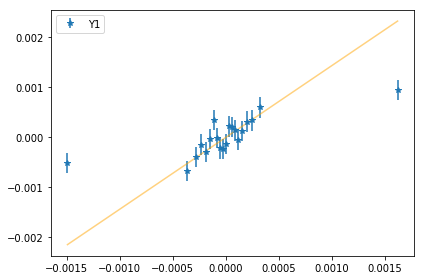

1.063924547942402


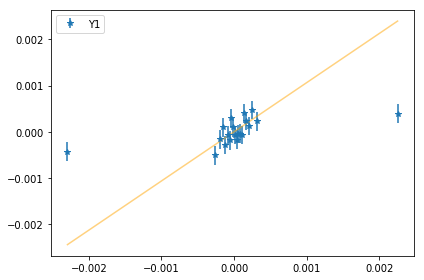

In [48]:

TT = 20
mask = np.array(sample_dict['q2']) == np.array(sample_dict['q2']) 
x = np.array(sample_dict['q2'])[mask]
y = np.array(sample_dict['e2'])[mask]

vec = np.zeros(TT)

bound = [np.quantile(x,1.*(i*1)/TT) for i in range(TT+1)]
vec = [np.mean(y[(x>bound[i])&(x<bound[i+1])]) for i in range(TT)]
err = [np.std(y[(x>bound[i])&(x<bound[i+1])])/np.sqrt(len(y[(x>bound[i])&(x<bound[i+1])])) for i in range(TT)]
x0 = (np.array(bound[1:])+np.array(bound[:-1]))*0.5
plt.errorbar(x0,vec,err,fmt='*',label = 'Y1')

b_=dict_systematics_tot_E_full[binx]['E2']['q2']['b_arr'][0]
print b_
plt.plot(x0,b_*(x0),alpha = 0.5,color='orange')

plt.legend()
plt.show()





TT = 20
mask = np.array(sample_dict['q1']) == np.array(sample_dict['q1']) 
x = np.array(sample_dict['q1'])[mask]
y = np.array(sample_dict['e1'])[mask]

vec = np.zeros(TT)

bound = [np.quantile(x,1.*(i*1)/TT) for i in range(TT+1)]
vec = [np.mean(y[(x>bound[i])&(x<bound[i+1])]) for i in range(TT)]
err = [np.std(y[(x>bound[i])&(x<bound[i+1])])/np.sqrt(len(y[(x>bound[i])&(x<bound[i+1])])) for i in range(TT)]
x0 = (np.array(bound[1:])+np.array(bound[:-1]))*0.5
plt.errorbar(x0,vec,err,fmt='*',label = 'Y1')

b_=dict_systematics_tot_E_full[binx]['E1']['q1']['b_arr'][0]
print b_
plt.plot(x0,b_*(x0),alpha = 0.5,color='orange')

plt.legend()
plt.show()




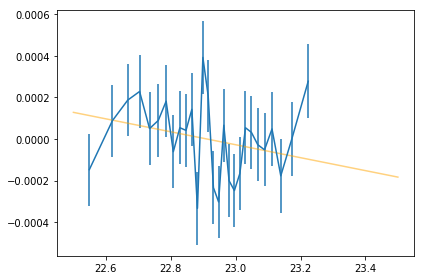

In [71]:
key = 'q2'
xmm = np.mean(sample_dict[key])
b_=dict_systematics_tot_E_full[binx]['E2'][key]['b_arr'][0]
print b_
plt.plot(xx,b_*(xx-xmm),alpha = 0.5,color='orange')
plt.show()
xmm = np.mean(sample_dict[key])
b_=dict_systematics_tot_E_full[binx]['E1'][key]['b_arr'][0]
print b_
xx = np.linspace(22.5,23.5,20)
plt.errorbar(x0[1:-1],vec[1:-1],err[1:-1])
plt.plot(xx,b_*(xx-xmm),alpha = 0.5,color='orange')
plt.show()

# PSF plot

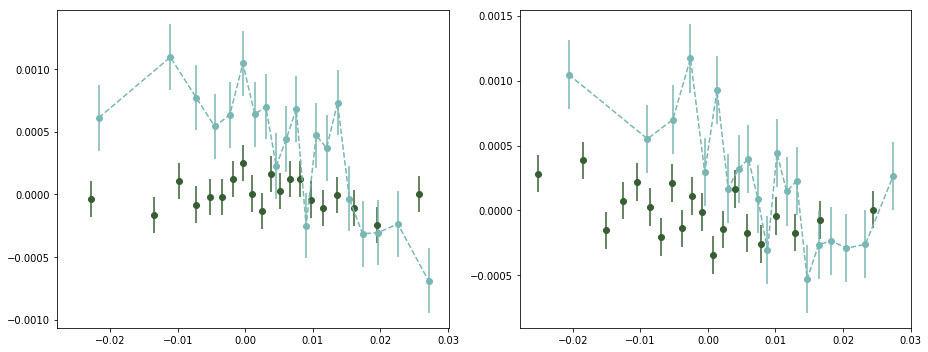

In [48]:



fig, ax = plt.subplots(1,2,sharex = True, figsize=(7,3))




TT = 20
mask = (sample_dict['psf_e1']>-0.03) &  (sample_dict['psf_e1']<0.03)
x = sample_dict['psf_e1'][mask]
y = sample_dict['e1'][mask]

vec = np.zeros(TT)

bound = [np.quantile(x,1.*(i*1)/TT) for i in range(TT+1)]
vec = [np.mean(y[(x>bound[i])&(x<bound[i+1])]) for i in range(TT)]
err = [np.std(y[(x>bound[i])&(x<bound[i+1])])/np.sqrt(len(y[(x>bound[i])&(x<bound[i+1])])) for i in range(TT)]
x0 = (np.array(bound[1:])+np.array(bound[:-1]))*0.5
ax[0].errorbar(x0,vec,err,fmt='o',color=c_3, label = 'Y3')



TT = 20
mask = (sample_dict['psf_e2']>-0.03) &  (sample_dict['psf_e2']<0.03)
x = sample_dict['psf_e2'][mask]
y = sample_dict['e2'][mask]

vec = np.zeros(TT)

bound = [np.quantile(x,1.*(i*1)/TT) for i in range(TT+1)]
vec = [np.mean(y[(x>bound[i])&(x<bound[i+1])]) for i in range(TT)]
err = [np.std(y[(x>bound[i])&(x<bound[i+1])])/np.sqrt(len(y[(x>bound[i])&(x<bound[i+1])])) for i in range(TT)]
x0 = (np.array(bound[1:])+np.array(bound[:-1]))*0.5
ax[1].errorbar(x0,vec,err,fmt='o',color=c_3, label = 'Y3')





TT = 20
mask = (sample_dict_y1['psf_e1']>-0.03) &  (sample_dict_y1['psf_e1']<0.03)
x = sample_dict_y1['psf_e1'][mask]
y = sample_dict_y1['e1'][mask]

vec = np.zeros(TT)

bound = [np.quantile(x,1.*(i*1)/TT) for i in range(TT+1)]
vec = [np.mean(y[(x>bound[i])&(x<bound[i+1])]) for i in range(TT)]
err = [np.std(y[(x>bound[i])&(x<bound[i+1])])/np.sqrt(len(y[(x>bound[i])&(x<bound[i+1])])) for i in range(TT)]
x0 = (np.array(bound[1:])+np.array(bound[:-1]))*0.5
ax[0].errorbar(x0,vec,err,fmt='o',color=c_23, linestyle = 'dashed',label = 'Y1')



TT = 20
mask = (sample_dict_y1['psf_e2']>-0.03) &  (sample_dict_y1['psf_e2']<0.03)
x = sample_dict_y1['psf_e2'][mask]
y = sample_dict_y1['e2'][mask]

vec = np.zeros(TT)

bound = [np.quantile(x,1.*(i*1)/TT) for i in range(TT+1)]
vec = [np.mean(y[(x>bound[i])&(x<bound[i+1])]) for i in range(TT)]
err = [np.std(y[(x>bound[i])&(x<bound[i+1])])/np.sqrt(len(y[(x>bound[i])&(x<bound[i+1])])) for i in range(TT)]
x0 = (np.array(bound[1:])+np.array(bound[:-1]))*0.5
ax[1].errorbar(x0,vec,err,fmt='*',color=c_2,label = 'Y1')
plt.legend()
plt.show()




    
    

In [56]:
1

1

In [ ]:

    if 1==1:
        #dedp *************************************************************************
        lenp = 10
        fig, ax = plt.subplots(1,3,sharex=False, sharey=False, figsize=(13,3))
        ssf = np.zeros((resampling,lenp))

        
        y = dict_tot[binx]['e2'][dict_tot[binx]['info']['mask_sims']]
        x = dict_tot[binx]['p2'][dict_tot[binx]['info']['mask_sims']]

        nbins = np.linspace(-0.007,0.007,lenp+1)
        mn = []
        mne = []
        for i in range(lenp):

            maska = (x>nbins[i])&(x<nbins[i+1])
            n, _ = np.histogram(x[maska], bins=nbins)
            mn.append(np.mean(y[maska]))
            mne.append(np.std(y)/np.sqrt(len(y[maska])))

        xx = 0.5*(nbins[1:]+nbins[:-1])
        beta = dd2_dp2[0]
        b_err = dd2_dp2e
        #ax[0].plot(-xx,beta*(xx-np.mean(x)))
        ax[0].fill_between(-xx, (beta+b_err)*(xx-np.mean(x)),(beta-b_err)*(xx-np.mean(x)),alpha = 0.5,color='orange')
        ax[0].errorbar(-xx,mn-np.mean(y),mne,fmt = 'o',label='$e_2*p_2$',color='orange')


        y = dict_tot[binx]['e1'][dict_tot[binx]['info']['mask_sims']]
        x = dict_tot[binx]['p1'][dict_tot[binx]['info']['mask_sims']]

        nbins = np.linspace(-0.007,0.007,lenp+1)
        mn = []
        mne = []
        for i in range(lenp):

            maska = (x>nbins[i])&(x<nbins[i+1])
            n, _ = np.histogram(x[maska], bins=nbins)
            mn.append(np.mean(y[maska]))
            mne.append(np.std(y)/np.sqrt(len(y[maska])))

        xx = 0.5*(nbins[1:]+nbins[:-1])
        beta = dd1_dp1[0]
        b_err = dd1_dp1e
        #ax[0].plot(-xx,beta*(xx-np.mean(x)))
        ax[0].fill_between(-xx, (beta+b_err)*(xx-np.mean(x)),(beta-b_err)*(xx-np.mean(x)),alpha = 0.5,color='red')
        
        ax[0].errorbar(-xx,mn-np.mean(y),mne,fmt = 'o',label='$e_1*p_1$',color='red')
        ax[0].set_ylim([-0.001,0.001])
        ax[0].set_xlim([-0.007,0.007])

        ax[0].set_xlabel("$p_i$")
        ax[0].set_ylabel("$<e_i>$")



        ax[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

        
        
        # DEDQ ************************************************************************
        
        y = dict_tot[binx]['e2'][dict_tot[binx]['info']['mask_sims']]
        x = dict_tot[binx]['q2'][dict_tot[binx]['info']['mask_sims']]

        nbins = np.linspace(-0.0004,0.0004,lenp+1)
        mn = []
        mne = []
        for i in range(lenp):

            maska = (x>nbins[i])&(x<nbins[i+1])
            n, _ = np.histogram(x[maska], bins=nbins)
            mn.append(np.mean(y[maska]))
            mne.append(np.std(y)/np.sqrt(len(y[maska])))

        xx = 0.5*(nbins[1:]+nbins[:-1])
        beta = dd2_dq2[0]
        b_err = dd2_dq2e
        

        #ax[1].plot(-xx,beta*(xx-np.mean(x)))
 
        
        ax[1].fill_between(-xx, (beta+b_err)*(xx-np.mean(x)),(beta-b_err)*(xx-np.mean(x)),alpha = 0.5,color='orange')

        ax[1].errorbar(-xx,mn-np.mean(y),mne,fmt = 'o',label='$e_2*q_2$',color='orange')


        y = dict_tot[binx]['e1'][dict_tot[binx]['info']['mask_sims']]
        x = dict_tot[binx]['q1'][dict_tot[binx]['info']['mask_sims']]

        nbins = np.linspace(-0.0004,0.0004,lenp+1)
        mn = []
        mne = []
        for i in range(lenp):

            maska = (x>nbins[i])&(x<nbins[i+1])
            n, _ = np.histogram(x[maska], bins=nbins)
            mn.append(np.mean(y[maska]))
            mne.append(np.std(y)/np.sqrt(len(y[maska])))

        xx = 0.5*(nbins[1:]+nbins[:-1])
        beta = dd1_dq1[0]
        b_err = dd1_dq1e#[0]

        #ax[1].plot(-xx,beta*(xx-np.mean(x)))
        ax[1].fill_between(-xx, (beta+b_err)*(xx-np.mean(x)),(beta-b_err)*(xx-np.mean(x)),alpha = 0.5,color='red')

        ax[1].errorbar(-xx,mn-np.mean(y),mne,fmt = 'o',label='$e_1*q_1$',color='red')
        ax[1].set_ylim([-0.0005,0.0005])
        ax[1].set_xlim([-0.0004,0.0004])

        ax[1].set_xlabel("$q_i$")
        ax[1].set_ylabel("$<e_i>$")



        ax[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))




        #DEDT ******************************************************************

        y = dict_tot[binx]['e2'][dict_tot[binx]['info']['mask_sims']]
        x = dict_tot[binx]['t2'][dict_tot[binx]['info']['mask_sims']]

        nbins = np.linspace(-0.00001,0.00001,lenp+1)
        mn = []
        mne = []
        for i in range(lenp):

            maska = (x>nbins[i])&(x<nbins[i+1])
            n, _ = np.histogram(x[maska], bins=nbins)
            mn.append(np.mean(y[maska]))
            mne.append(np.std(y)/np.sqrt(len(y[maska])))

        xx = 0.5*(nbins[1:]+nbins[:-1])
        beta = dd2_dw2[0]
        b_err = dd2_dw2e#[0]
        #ax[2].plot(xx,beta*xx)
        ax[2].fill_between(xx, (beta+b_err)*(xx-np.mean(x)),(beta-b_err)*(xx-np.mean(x)),alpha = 0.5,color='orange')

        ax[2].errorbar(xx,mn-np.mean(y),mne,fmt = 'o',label='$e_2*w_2$',color='orange')


        y = dict_tot[binx]['e1'][dict_tot[binx]['info']['mask_sims']]
        x = dict_tot[binx]['t1'][dict_tot[binx]['info']['mask_sims']]

        nbins = np.linspace(-0.00001,0.00001,lenp+1)
        mn = []
        mne = []
        for i in range(lenp):

            maska = (x>nbins[i])&(x<nbins[i+1])
            n, _ = np.histogram(x[maska], bins=nbins)
            mn.append(np.mean(y[maska]))
            mne.append(np.std(y)/np.sqrt(len(y[maska])))

        xx = 0.5*(nbins[1:]+nbins[:-1])
        beta = dd1_dw1[0]
        beta_err = dd1_dw1e#[0]
        #ax[2].plot(xx,beta*xx)
        ax[2].fill_between(xx, (beta+b_err)*(xx-np.mean(x)),(beta-b_err)*(xx-np.mean(x)),alpha = 0.5,color='red')

        ax[2].errorbar(xx,mn-np.mean(y),mne,fmt = 'o',label='$e_1*w_1$',color='red')
        ax[2].set_ylim([-0.001,0.001])
        ax[2].set_xlim([-0.00001,0.00001])

        ax[2].set_xlabel("$w_i$")
        ax[2].set_ylabel("$<e_i>$")
        
        ax[2].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        ax[0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        
        ax[0].text(0.4,0.9 ,r'$\partial e_1$/ $\partial p_1$: {0:2.3f}$\pm${1:2.3f}'.format(-dd1_dp1[0],dd1_dp1e),transform=ax[0].transAxes)
        ax[0].text(0.4,0.8 , r'$\partial e_2$/ $\partial p_2$: {0:2.3f}$\pm${1:2.3f}'.format(-dd2_dp2[0],dd2_dp2e),transform=ax[0].transAxes)

        ax[1].text(0.4,0.9 ,r'$\partial e_1$/ $\partial q_1$: -{0:2.2f}$\pm${1:2.2f}'.format(dd1_dq1[0],dd1_dq1e),transform=ax[1].transAxes)
        ax[1].text(0.4,0.8 , r'$\partial e_2$/ $\partial q_2$: -{0:2.2f}$\pm${1:2.2f}'.format(dd2_dq2[0],dd2_dq2e),transform=ax[1].transAxes)

        ax[2].text(0.4,0.9 , '$\partial e_1$ / $\partial w_1$: {0:2.2f}$\pm${1:2.2f}'.format(dd1_dw1[0],dd1_dw1e),transform=ax[2].transAxes)
        ax[2].text(0.4,0.8 , '$\partial e_2$ / $\partial w_2$: {0:2.2f}$\pm${1:2.2f}'.format(dd2_dw2[0],dd2_dw2e),transform=ax[2].transAxes)
        ax[0].legend(loc="upper left", bbox_to_anchor=(.6,0.3))
        ax[1].legend(loc="upper left", bbox_to_anchor=(.6,0.3))
        ax[2].legend(loc="upper left", bbox_to_anchor=(.6,0.3))
        plt.tight_layout()
        #plt.show()
        plt.savefig("E_psferr_"+binx+".pdf")

        
        
        
        
        
        
        
        
        
        
        fig, ax = plt.subplots(1,2,sharex=False, sharey=False, figsize=(8,3))
        y = dict_tot[binx]['e1'][dict_tot[binx]['info']['mask_sims']]
        x = dict_tot[binx]['psf_e1'][dict_tot[binx]['info']['mask_sims']]

        nbins = np.linspace(-0.02,0.02,lenp+1)
        mn = []
        mne = []
        for i in range(lenp):

            maska = (x>nbins[i])&(x<nbins[i+1])
            n, _ = np.histogram(x[maska], bins=nbins)
            mn.append(np.mean(y[maska]))
            mne.append(np.std(y)/np.sqrt(len(y[maska])))

        xx = 0.5*(nbins[1:]+nbins[:-1])
        beta = dict_systematics_tot_E[binx]['E1']['_w0']['PSF_E1']['b_arr'][0]
        b_err = dict_systematics_tot_E[binx]['E1']['_w0']['PSF_E1']['b_err']#[0]
        print ("fit E1/PSF_E1 : {0:2.4f} +- {1:2.4f} [sigma: {2:2.4f}]").format(beta,dict_systematics_tot_E[binx]['E1']['_w0']['PSF_E1']['b_err'],beta/dict_systematics_tot_E[binx]['E1']['_w0']['PSF_E1']['b_err'])
        
       
        ax[0].errorbar(xx,mn-np.mean(y),mne,fmt = 'o',color='green')
        ax[0].fill_between(xx, (beta+b_err)*(xx-np.mean(x)),(beta-b_err)*(xx-np.mean(x)),alpha = 0.5,color="green",label="real space coord.")
        
        
        

        beta = dd1_dq1[0]*dq1_dPSF1 +dd1_dp1[0]*dp1_dPSF1 +dd1_dw1[0]*dw1_dPSF1
        beta_e = np.abs(dd1_dq1e*dq1_dPSF1)+np.abs(dd1_dp1e*dp1_dPSF1)+np.abs(dd1_dw1e*dw1_dPSF1)
        print ("from PSF errors: {0:2.4f} +- {1:2.4f} [sigma: {2:2.4f}]").format(beta,beta_e,beta/beta_e)
        ax[0].fill_between(xx, (beta+b_err)*(xx-np.mean(x)),(beta-b_err)*(xx-np.mean(x)),alpha = 0.5,color="orange",label="from focal plane coord.")
        
        

        
        
        #**************************
        y = dict_tot[binx]['e2'][dict_tot[binx]['info']['mask_sims']]
        x = dict_tot[binx]['psf_e2'][dict_tot[binx]['info']['mask_sims']]

        nbins = np.linspace(-0.02,0.02,lenp+1)
        mn = []
        mne = []
        for i in range(lenp):

            maska = (x>nbins[i])&(x<nbins[i+1])
            n, _ = np.histogram(x[maska], bins=nbins)
            mn.append(np.mean(y[maska]))
            mne.append(np.std(y)/np.sqrt(len(y[maska])))

        xx = 0.5*(nbins[1:]+nbins[:-1])
        beta = dict_systematics_tot_E[binx]['E2']['_w0']['PSF_E2']['b_arr'][0]
        b_err = dict_systematics_tot_E[binx]['E2']['_w0']['PSF_E2']['b_err']#[0]
        print ("fit E2/PSF_E2 : {0:2.4f} +- {1:2.4f} [sigma: {2:2.4f}]").format(beta,dict_systematics_tot_E[binx]['E2']['_w0']['PSF_E2']['b_err'],beta/dict_systematics_tot_E[binx]['E2']['_w0']['PSF_E2']['b_err'])
        
        ax[1].errorbar(xx,mn-np.mean(y),mne,fmt = 'o',color='green')
        ax[1].fill_between(xx, (beta+b_err)*(xx-np.mean(x)),(beta-b_err)*(xx-np.mean(x)),alpha = 0.5,color="green",label="real space coord.")
        

        beta = dd2_dq2[0]*dq2_dPSF2 +dd2_dp2[0]*dp2_dPSF2 +dd2_dw2[0]*dw2_dPSF2
        beta_e = np.abs(dd2_dq2e*dq2_dPSF2)+np.abs(dd2_dp2e*dp2_dPSF2)+np.abs(dd2_dw2e*dw2_dPSF2)
        print ("from PSF errors: {0:2.4f} +- {1:2.4f} [sigma: {2:2.4f}]").format(beta,beta_e,beta/beta_e)

        #print beta
        ax[1].fill_between(xx, (beta+b_err)*(xx-np.mean(x)),(beta-b_err)*(xx-np.mean(x)),alpha = 0.5,color="orange",label="from focal plane coord.")
        
        
        ax[0].legend(loc="upper left", bbox_to_anchor=(.05,0.3))
        ax[1].legend(loc="upper left", bbox_to_anchor=(.05,0.3))
        
        
        
        ax[0].set_ylabel("$<e_1>$")
        ax[1].set_ylabel("$<e_2>$")
        ax[0].set_xlabel("$PSF_1$")
        ax[1].set_xlabel("$PSF_2$")
 
        plt.savefig("E_PSF_"+binx+".pdf")
        #plt.show()

        
    PSFabe_dict.update({binx:mute_dict})

In [ ]:
%load_ext Cython

In [ ]:
%%cython -a
import wignerpy._wignerpy as wp
cimport numpy as np

#include "wignerSymbols.h"
#include <iostream>
#include <iomanip>
#include <armadillo>
#include <time.h>
#include "wignerSymbols/wignerSymbols-cpp.h"
#include "wignerSymbols/wignerSymbols-fortran.h"
#include "wignerSymbols/commonFunctions.h"





def triple_cycle_2(int l1,np.ndarray[double, ndim=1, mode="c"] u, int lenU):
    import numpy as np
    a = 1./(8*np.pi)
    ME = np.zeros(lenU)
    MB = np.zeros(lenU)
    for l2 in range(lenU):
        for l3 in range(lenU):
            if ((l1-l2)**2 <= l3*l3) and ((l1+l2)>=l3):
                ME[l2] += (2*l2+1)*(2*l3+1)* a * u[l3] * ( 1 + (-1.)**(l1+l2+l3))*wp.wigner3j(l1, l2 , l3,  2, -2, 0)**2.
                MB[l2] += (2*l2+1)*(2*l3+1)* a * u[l3] * ( 1 - (-1.)**(l1+l2+l3))*wp.wigner3j(l1, l2 , l3,  2, -2, 0)**2.

    return ME, MB,l1

def triple_cycle_temperature(int l1,np.ndarray[double, ndim=1, mode="c"] u, int lenU,np.ndarray[double, ndim=1, mode="c"] ME):
    import numpy as np
    a = 1./(4*np.pi)
    for l2 in range(lenU):
        for l3 in range(lenU):
            if ((l1-l2)**2 <= l3*l3) and ((l1+l2)>=l3):
                ME[l2] += (2*l2+1)*(2*l3+1)* a * u[l3] *wp.wigner3j(l1, l2 , l3,  0, 0, 0)**2.

    return ME

def triple_cycle_3(int l1,np.ndarray[double, ndim=1, mode="c"] u, int lenU):
    import numpy as np
    a = 1./(8*np.pi)
    l3 = np.arange(3*lenU)
    mask1 = l3<lenU
    ME = np.zeros(lenU)
    MB = np.zeros(lenU)
    for l2 in range(2,lenU):
 
        
        mask = ((l1-l2)**2 <= l3*l3) & ((l1+l2)>=l3) 
        mask2 = l3[mask]<lenU
        #print len(mask),len(l3), len(u),len(u[mask])
       
  
        v1 = wp.wigner3jvec(l1,l2, 2,-2)
        #print v1,l1,l2,len(u[mask[mask1]]),len(l3[mask])

        ME[l2] += np.sum((2*l2+1)*(2*l3[mask&mask1]+1)* a * u[mask[mask1]] * ( 1 + (-1.)**(l1+l2+l3[mask&mask1]))*v1[mask2]**2.)
        MB[l2] += np.sum((2*l2+1)*(2*l3[mask&mask1]+1)* a * u[mask[mask1]] * ( 1 - (-1.)**(l1+l2+l3[mask&mask1]))*v1[mask2]**2.)

    return ME, MB, l1

def triple_cycle(np.ndarray[double, ndim=1, mode="c"] u, int lenU,np.ndarray[double, ndim=2, mode="c"] ME,np.ndarray[double, ndim=2, mode="c"] MB):
    import numpy as np
    for l1 in range(lenU):
        for l2 in range(lenU):
            for l3 in range(lenU):
                ME[l1,l2] += (2*l2+1)*(2*l3+1)/(8*np.pi) * u[l3] * ( 1 + (-1.)**(l1+l2+l3))*wp.wigner3j(l1, l2 , l3,  2, -2, 0)**2.
                MB[l1,l2] += (2*l2+1)*(2*l3+1)/(8*np.pi) * u[l3] * ( 1 - (-1.)**(l1+l2+l3))*wp.wigner3j(l1, l2 , l3,  2, -2, 0)**2.

    return ME, MB, l1

In [ ]:
import timeit
import numpy as np
from multiprocessing import Pool,sharedctypes
from functools import partial
from contextlib import closing
import h5py

def _init(arr_to_populate):
    global arr
    arr = arr_to_populate
    

lmax = nside*2
agents = 64

# define mask
for i,binx in enumerate(dict_tot.keys()):
    if i == 0:
        mask = dict_tot[binx]["n"]>0.
    else:
        mask = mask & (dict_tot[binx]["n"]>0.)
        
# compute Cl_mask
alms_mask = hp.map2alm(mask, lmax=lmax)  # Spin transform
Cl_mask =  hp.sphtfunc.alm2cl(alms_mask)

l1 = range(2,lmax)
    

ME_final = np.zeros(lmax*lmax)
MB_final = np.zeros(lmax*lmax)
t3 = timeit.default_timer()

mute_list = []
l2l = (2*np.arange(lmax)+1)

with closing(Pool(processes=agents)) as pool:
     mute_list.append(pool.map(partial(triple_cycle_3, u = Cl_mask[:lmax], lenU = lmax),l1))
        
for xx,i in enumerate(np.array(mute_list)[0,:,2]):
    ME_final[lmax*(i):lmax*(i+1)] = np.array(mute_list)[0,xx,0]
    MB_final[lmax*(i):lmax*(i+1)] = np.array(mute_list)[0,xx,1]
t4 = timeit.default_timer()
print t4-t3

name_file =name_folder_x+'_{0}_{1}/M_mcaly3_new_{2}_{3}.h5'.format(z_min,z_max,lmax,nside)

h5f = h5py.File(name_file, 'w')
h5f.create_dataset('ME', data=ME_final)
h5f.create_dataset('MB', data=MB_final)
print "done"

15

****************

TEST [method2] E1: -> p2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275

In [14]:
runs_path = load_obj("runs2")
run_count = 0
rewrite=False
runsss = np.arange(len(runs_path.keys()))
list_run = []
list_run1 = []
count = 0
for i in range(len(runsss)):


    runs_path = load_obj("runs2")
    print (len(runs_path.keys()))
    if  ((rewrite) or (not os.path.exists(runs_path[i]+'_dict_outp'+".pkl"))):
        count+=1
    print (count)

20
0
20
0
20
0
20
0
20
0
20
0
20
0
20
0
20
0
20
0
20
0
20
0
20
0
20
0
20
0
20
0
20
0
20
0
20
0
20
0


In [1]:
rewrite=False

In [5]:
import os
path = '/global/cscratch1/sd/mgatti/Mass_Mapping/flask/output_flask_Buzzard_covMM_4096/junk/397_e1_PSF_SIZE'
print ((rewrite) or (not os.path.exists(path+'.pkl')))
        

False


In [13]:
1

1

In [132]:
#0_e2_depth_i.pkl       0_e2_size_ratio.pkl  10_e2_t1.pkl  1_e2_q2.pkl   2_e2_snr.pkl  4_e2_snr.pkl  6_e2_snr.pkl  8_e2_t1.pkl
xx = '0_e2_depth_i'
xx = '0_e2_t1'
path='/global/cscratch1/sd/mgatti/Mass_Mapping/flask/output_flask_Buzzard_covMM_4096/junk/'+xx
mute = load_obj(path)
print mute

[0, 4.845281881535411, 7.826656534258222e-05]


In [ ]:
from __future__ import division
from __future__ import print_function
import numpy as np
import timeit
import treecorr # Module for correlation functions, pip install TreeCorr.
from astropy.cosmology import Planck15 as Planck15
import pickle
import sys

#%matplotlib inline
#import matplotlib.pyplot as plt
import sys
import pyfits as pf
import numpy as np
import healpy as hp
import timeit
from astropy.table import Table
import os
import pickle
import os
import timeit
import shutil
from multiprocessing import Pool
import timeit
import numpy as np
from multiprocessing import Pool,sharedctypes
from functools import partial
from contextlib import closing


path_flask = '/global/cscratch1/sd/mgatti/Mass_Mapping/flask/output_flask_Buzzard_covMM_4096/'
def covariance_jck(TOTAL_PHI,jk_r,type_cov):
  if type_cov=='jackknife':
      fact=(jk_r-1.)/(jk_r)

  elif type_cov=='bootstrap':
      fact=1./(jk_r)
  #  Covariance estimation

  average=np.zeros(TOTAL_PHI.shape[0])
  cov_jck=np.zeros((TOTAL_PHI.shape[0],TOTAL_PHI.shape[0]))
  err_jck=np.zeros(TOTAL_PHI.shape[0])


  for kk in range(jk_r):
    average+=TOTAL_PHI[:,kk]
  average=average/(jk_r)

 # print average
  for ii in range(TOTAL_PHI.shape[0]):
     for jj in range(ii+1):
          for kk in range(jk_r):
            cov_jck[jj,ii]+=TOTAL_PHI[ii,kk]*TOTAL_PHI[jj,kk]

          cov_jck[jj,ii]=(-average[ii]*average[jj]*jk_r+cov_jck[jj,ii])*fact
          cov_jck[ii,jj]=cov_jck[jj,ii]

  for ii in range(TOTAL_PHI.shape[0]):
   err_jck[ii]=np.sqrt(cov_jck[ii,ii])
 # print err_jck

  #compute correlation
  corr=np.zeros((TOTAL_PHI.shape[0],TOTAL_PHI.shape[0]))
  for i in range(TOTAL_PHI.shape[0]):
      for j in range(TOTAL_PHI.shape[0]):
        corr[i,j]=cov_jck[i,j]/(np.sqrt(cov_jck[i,i]*cov_jck[j,j]))

  average=average*fact
  return {'cov' : cov_jck,
          'err' : err_jck,
          'corr':corr,
          'mean':average}


def covariance_scalar_jck(TOTAL_PHI,jk_r, type_c = 'jackknife'):

  #  Covariance estimation
  if type_c == 'jackknife':
      fact=(jk_r-1.)/(jk_r)

  elif type_c=='bootstrap':
      fact=1./(jk_r)
        
  average=0.
  cov_jck=0.
  err_jck=0.


  for kk in range(jk_r):
    average+=TOTAL_PHI[kk]
  average=average/(jk_r)

  for kk in range(jk_r):
    #cov_jck+=TOTAL_PHI[kk]#*TOTAL_PHI[kk]

    cov_jck+=(-average+TOTAL_PHI[kk])*(-average+TOTAL_PHI[kk])


  err_jck=np.sqrt(cov_jck*fact)


  #average=average*(jk_r)/(jk_r-1)
  return {'cov' : cov_jck*fact,
          'err' : err_jck,
          'mean': average}


def comp(jk,s,m,hp,t):
    if t == 'AAdepth_i' or t == 'AAdepth_g' or t == 'dAAepth_r' or t == 'AAdepth_z':
        
        index = np.random.randint(0,len(s),200000)
        mask1 = (hp[index] != jk)
        mm = np.polyfit(s[index][mask1],m[index][mask1],1)
        
        return jk, mm[0],mm[1]      
    else:
        
        mask1 = (hp != jk)
        mm = np.polyfit(s[mask1],m[mask1],1)
        return jk, mm[0],mm[1]
    
def analysis_3(kE_label,sys_map,mask,mapa, hpix, fract_limits=0.,mapa_weight = False, cov_ext = False):
    from scipy import linalg

    print ('\n****************\n')
    title = sys_map['title']
    print ('TEST [method2] {1}: -> {0}'.format(title,kE_label))
    
    n_jck = len(np.unique(hpix))
    n_jck = 1000
    fractional = sys_map['fractional']
    
    # plot typical ranges ***********************
   # area_tot = compute_area(mask, nside)
    
    sys_map1 =  sys_map['map'][mask]
    
    



    if mapa_weight:
        mapa1 = mapa[mask]-mapa_weight[mask]
    else:
        mapa1 = mapa[mask]
        
    mask2 = (mapa1==mapa1) & (sys_map1==sys_map1)
    sys_map1=sys_map1[mask2]
    mapa1=mapa1[mask2]
    hpix=hpix[mask][mask2]
    ave = sys_map1.mean()
    std = sys_map1.std()
    
    min_s, max_s = min(sys_map1),max(sys_map1)


    # plot maps properties *************************

    b_arr = np.zeros(n_jck+1)
    c_arr = np.zeros(n_jck+1)
    if title == 'depth_i' or title == 'depth_g' or title == 'depth_r' or title == 'depth_z':
       
        index = np.random.randint(0,len(sys_map1),200000)

        b_arr[0],c_arr[0] = np.polyfit(sys_map1[index],mapa1[index],1)
        
    else:
        b_arr[0],c_arr[0] = np.polyfit(sys_map1,mapa1,1)
    #print 'jck'
    

    aaa = range(n_jck)
    mas = []
    agents=5
    '''
    with closing(Pool(processes=agents)) as pool:
        mas.append(pool.map(partial(comp,s=sys_map1,m=mapa1,hp=hpix,t=title),aaa))
    '''
    for i in range(n_jck):
        print(i)
        mas.append(comp(i,s=sys_map1,m=mapa1,hp=hpix,t=title))
    mas = np.array(mas)

    

    mas =mas.reshape(n_jck,3)
    index = np.array(mas[:,0]).astype(int)+1
    b_arr[index]=mas[:,1]
    c_arr[index]=mas[:,2]
    #print mas
    #for i in range(n_jck):
    #    mask1 = (hpix != i)
    #    b_arr[i+1],c_arr[i+1] = np.polyfit(sys_map1[mask1],mapa1[mask1],1)
    
    xx = np.linspace(min_s,max_s,100)
    yy = b_arr[0]*xx+c_arr[0]
    dict_output=dict()
    dict_output.update({'b_arr' : b_arr})
    dict_output.update({'c_arr' : c_arr})
    dict_output.update({'b_err' : covariance_scalar_jck(b_arr[1:],n_jck)['err'] })
    
    dict_output.update({'min_s': min_s})
    dict_output.update({'max_s': max_s})

    dict_output.update({'xx': xx})
    dict_output.update({'yy': yy})

    return dict_output

















def comp_FLASK(jk,sA,mA,hp,t,mapa_rx,mask,syst,rewrite=False):
    print (jk)
    path = '/global/cscratch1/sd/mgatti/Mass_Mapping/flask/output_flask_Buzzard_covMM_4096/junk/{0}_{1}_{2}'.format(jk,mapa_rx,syst)
    if ((rewrite) or (not os.path.exists(path+'.pkl'))):
        
        
        mute = load_obj('/global/cscratch1/sd/mgatti/Mass_Mapping/flask/output_flask_Buzzard_covMM_4096/flask_full_{0}'.format(jk))
        
        '''
        sA = mute[mapa_rx][mask]
        mask2 = (mA==mA) & (sA==sA)
        s=sA[mask2]
        m=mA[mask][mask2]
        '''
        
        mA = mute[mapa_rx][mask]

        mask2 = (mA==mA) & (sA==sA)
        m=mA[mask2]
        s=sA[mask][mask2]
        
        
        if t == 'AAdepth_i' or t == 'AAdepth_g' or t == 'dAAepth_r' or t == 'AAdepth_z':

            index = np.random.randint(0,len(s),200000)
            mm = np.polyfit(s[index],m[index],1)


        else:
            mm = np.polyfit(s,m,1)
        
        m0,m1 = mm[0],mm[1]
        iu = [jk, m0,m1 ]
        save_obj(path,iu)
    else:
        try:
            iu = load_obj(path)
            jk, m0,m1  = iu
        except:
        
            mute = load_obj('/global/cscratch1/sd/mgatti/Mass_Mapping/flask/output_flask_Buzzard_covMM_4096/flask_full_{0}'.format(jk))

            '''
            sA = mute[mapa_rx][mask]
            mask2 = (mA==mA) & (sA==sA)
            s=sA[mask2]
            m=mA[mask][mask2]
            '''

            mA = mute[mapa_rx][mask]

            mask2 = (mA==mA) & (sA==sA)
            m=mA[mask2]
            s=sA[mask][mask2]


            if t == 'AAdepth_i' or t == 'AAdepth_g' or t == 'dAAepth_r' or t == 'AAdepth_z':

                index = np.random.randint(0,len(s),200000)
                mm = np.polyfit(s[index],m[index],1)


            else:
                mm = np.polyfit(s,m,1)

            m0,m1 = mm[0],mm[1]
            iu = [jk, m0,m1 ]
            save_obj(path,iu)   

    return jk, m0,m1 
    
def analysis_3_FLASK(kE_label,sys_map,mask,mapa_rx, hpix, fract_limits=0.,mapa_weight = False, cov_ext = False):
    from scipy import linalg

    print ('\n****************\n')
    title = sys_map['title']
    print ('TEST [method2] {1}: -> {0}'.format(title,kE_label))
    
    n_jck = len(np.unique(hpix))
    n_jck = 100
    fractional = sys_map['fractional']
    
    # plot typical ranges ***********************
   # area_tot = compute_area(mask, nside)
    
    sys_map1A =  sys_map['map'][mask]
    mute = load_obj('/global/cscratch1/sd/mgatti/Mass_Mapping/flask/output_flask_Buzzard_covMM_4096/flask_full_0')
    mapa = mute[mapa_rx]
    if mapa_weight:
        mapa1A = mapa[mask]-mapa_weight[mask]
    else:
        mapa1A = mapa[mask]
        
    mask2 = (mapa1A==mapa1A) & (sys_map1A==sys_map1A)
    sys_map1=sys_map1A[mask2]
    mapa1=mapa1A[mask2]
    hpix=hpix[mask][mask2]
    ave = sys_map1.mean()
    std = sys_map1.std()
    
    min_s, max_s = min(sys_map1),max(sys_map1)


    # plot maps properties *************************

    b_arr = np.zeros(n_jck+1)
    c_arr = np.zeros(n_jck+1)
    if title == 'depth_i' or title == 'depth_g' or title == 'depth_r' or title == 'depth_z':
       
        index = np.random.randint(0,len(sys_map1),200000)

        b_arr[0],c_arr[0] = np.polyfit(sys_map1[index],mapa1[index],1)
        
    else:
        b_arr[0],c_arr[0] = np.polyfit(sys_map1,mapa1,1)
    #print 'jck'
    

    aaa = range(n_jck)
    mas = []
    agents=2
    '''
    print ('riunning multiproc')
    
    with closing(Pool(processes=agents)) as pool:
        mas.append(pool.map(partial(comp_FLASK,sA=sys_map1A,mA=mapa1A,hp=hpix,t=title,mapa_rx=mapa_rx,mask=mask,syst=title),aaa))
    mas = np.array(mas)[0]
    
    '''
    for i in range(n_jck):
        mas.append(comp_FLASK(i,sA=sys_map1A,mA=mapa1A,hp=hpix,t=title,mapa_rx=mapa_rx,mask=mask,syst=title))
    mas = np.array(mas)
    
    

    mas =mas.reshape(n_jck,3)
    index = np.array(mas[:,0]).astype(int)+1
    b_arr[index]=mas[:,1]
    c_arr[index]=mas[:,2]
    #print mas
    #for i in range(n_jck):
    #    mask1 = (hpix != i)
    #    b_arr[i+1],c_arr[i+1] = np.polyfit(sys_map1[mask1],mapa1[mask1],1)
    
    xx = np.linspace(min_s,max_s,100)
    yy = b_arr[0]*xx+c_arr[0]
    dict_output=dict()
    dict_output.update({'b_arr' : b_arr})
    dict_output.update({'c_arr' : c_arr})
    dict_output.update({'b_err' : covariance_scalar_jck(b_arr[1:],n_jck,'bootstrap')['err'] })
    
    dict_output.update({'min_s': min_s})
    dict_output.update({'max_s': max_s})

    dict_output.update({'xx': xx})
    dict_output.update({'yy': yy})

    return dict_output






def save_obj(name, obj):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)#, encoding='latin1')
#mute = load_obj("seeing_g_l2_9.pkl")   



def runit1(i):
    mutex = load_obj('runs1')
    mute = load_obj(mutex[i])
    dict_output = analysis_3(mute['kE_label'],mute['sys_map'],mute['mask'],mute['kE'],mute['info_hpix'])
    save_obj(mutex[i]+'_dict_outp',dict_output)
            
def runit2(i):
    mutex = load_obj('runs2')
    mute = load_obj(mutex[i])
    dict_output = analysis_3(mute['kE_label'],mute['sys_map'],mute['mask'],mute['kE'],mute['info_hpix'])
    save_obj(mutex[i]+'_dict_outp',dict_output)          

    
    
    
def runit1_FLASK(i):
    mutex = load_obj('runs1')
    mute = load_obj(mutex[i])
    
    
    dict_output = analysis_3_FLASK(mute['kE_label'],mute['sys_map'],mute['mask'],'e1',mute['info_hpix'])
    save_obj(mutex[i]+'_dict_outp_FLASK',dict_output)
            
def runit2_FLASK(i):
    mutex = load_obj('runs2')
    mute = load_obj(mutex[i])
    dict_output = analysis_3_FLASK(mute['kE_label'],mute['sys_map'],mute['mask'],'e2',mute['info_hpix'])
    save_obj(mutex[i]+'_dict_outp_FLASK',dict_output)          

    
    
    
if __name__ == '__main__':
    '''
    import gc      

    runs_path = load_obj("runs1")
    run_count = 0

    runsss = np.arange(len(runs_path.keys()))
    
    list_run = []
    list_run1 = []

    for i in range(len(runsss)):
    
        rewrite = False
        runs_path = load_obj("runs1")

        if  ((rewrite) or (not os.path.exists(runs_path[i]+'_dict_outp'+".pkl"))):
            list_run.append(i)
       
            
        runs_path=0.
        mute_dict=0.
        gc.collect
    list_run= np.array(list_run)

    while run_count<(len(list_run)):
        comm = MPI.COMM_WORLD
        

        print("Hello! I'm rank %d from %d running in total..." % (comm.rank, comm.size))
        if (run_count+comm.rank)< len(list_run):
            print ('A',(run_count+comm.rank),len(list_run))
            runit1(list_run[(run_count+comm.rank)])#,runs_path)
        run_count+=comm.size
        comm.bcast(run_count,root = 0)
        comm.Barrier() 


        
        
        
    runs_path = load_obj("runs2")
    run_count = 0

    runsss = np.arange(len(runs_path.keys()))
    
    list_run = []
    list_run1 = []
    for i in range(len(runsss)):
    
        rewrite = False
        runs_path = load_obj("runs2")

        if  ((rewrite) or (not os.path.exists(runs_path[i]+'_dict_outp'+".pkl"))):
            list_run.append(i)
       
            
        runs_path=0.
        mute_dict=0.
        gc.collect
    list_run= np.array(list_run)

    while run_count<(len(list_run)):
        comm = MPI.COMM_WORLD
        

        print("Hello! I'm rank %d from %d running in total..." % (comm.rank, comm.size))
        if (run_count+comm.rank)< len(list_run):
            runit2(list_run[(run_count+comm.rank)])#,runs_path)
        run_count+=comm.size
        comm.bcast(run_count,root = 0)
        comm.Barrier() 


        
        
        
        
        
    '''
        
        



        

    runs_path = load_obj("runs2")
    run_count = 0

    runsss = np.arange(len(runs_path.keys()))
    
    list_run = []
    list_run1 = []
    for i in range(len(runsss)):
    
        rewrite = False
        runs_path = load_obj("runs2")

        if  ((rewrite) or (not os.path.exists(runs_path[i]+'_dict_outp_FLASK'+".pkl"))):
            list_run.append(i)
       
            
        runs_path=0.
        mute_dict=0.
       
    list_run= np.array(list_run)

    while run_count<(len(list_run)):
        
        


        if (run_count)< len(list_run):
            runit2_FLASK(list_run[(run_count)])#,runs_path)
        run_count+=1



        
        

        
        
# NON JACKKNIFE *****

    runs_path = load_obj("runs1")
    run_count = 0

    runsss = np.arange(len(runs_path.keys()))
    
    list_run = []
    list_run1 = []

    for i in range(len(runsss)):
    
        rewrite = True
        runs_path = load_obj("runs1")

        if  ((rewrite) or (not os.path.exists(runs_path[i]+'_dict_outp_FLASK'+".pkl"))):
            list_run.append(i)
       
            
        runs_path=0.
        mute_dict=0.
     
    list_run= np.array(list_run)

    while run_count<(len(list_run)):


        if (run_count)< len(list_run):
            runit1_FLASK(list_run[(run_count)])#,runs_path)
        run_count+=1



****************

TEST [method2] E1: -> depth_i
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99

****************

TEST [method2] E1: -> p2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99

****************

TEST [method2] E1: -> q2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97

In [ ]:
1

In [1]:
1

1

In [ ]:
mean_e1 = []
mean_e2 = []
for jk in range(1000):
    print jk
    mute = load_obj('/global/cscratch1/sd/mgatti/Mass_Mapping/flask/output_flask_Buzzard_covMM_4096/flask_full_{0}'.format(jk))
    mean_e1.append(np.mean(mute['e1']))
    mean_e2.append(np.mean(mute['e2']))
mean_e1 = np.array(mean_e1)
Amean_e1 = np.array(mean_e1)
Amean_e2 = np.array(mean_e2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
2

In [315]:
du1 = covariance_scalar_jck(Amean_e1,1000,'bootstrap')
print du1['err']

du2 = covariance_scalar_jck(Amean_e2,1000,'bootstrap')
print du2['err']

6.113052144931373e-05
5.580563149966367e-05


In [2]:
import h5py as h5
import numpy as np
bins = ['all']
nside = 1024



# read File *******

File_data = "/project/projectdirs/des/www/y3_cats/Y3_mastercat_12_3_19.h5"
master = h5.File(File_data,'r')


select_metacal  = np.array(master['index']['select_shape']) # gold + mcal
select_all  = np.array(master['index']['select'])  # photo + gold + mcal


select_metacal_1p  = np.array(master['index']['select_shape_1p'])
select_metacal_1m  = np.array(master['index']['select_shape_1m'])
select_metacal_2p  = np.array(master['index']['select_shape_2p'])
select_metacal_2m  = np.array(master['index']['select_shape_2m'])

ra_master = np.array(master['catalog']['metacal']['unsheared']['ra'])
dec_master =  np.array(master['catalog']['metacal']['unsheared']['dec'])

mmm = dict()

cat = dict()

e1 = np.array(master['catalog']['metacal']['unsheared']['e_1'])
e2 = np.array(master['catalog']['metacal']['unsheared']['e_2'])
e1p = np.array(master['catalog']['metacal']['sheared_1p']['e_1'])[select_metacal]
e1m = np.array(master['catalog']['metacal']['sheared_1m']['e_1'])[select_metacal]
e2p = np.array(master['catalog']['metacal']['sheared_2p']['e_2'])[select_metacal]
e2m = np.array(master['catalog']['metacal']['sheared_2m']['e_2'])[select_metacal]

# compute response: 
dgamma = 2. * 0.01
R11_1 = (np.mean(e1p) - np.mean(e1m) + np.mean(
e1[select_metacal_1p]) - np.mean(
e1[select_metacal_1m]))/ dgamma
R22_1 = (np.mean(e2p) - np.mean(e2m) + np.mean(
e2[select_metacal_2p]) - np.mean(
e2[select_metacal_2m])) / dgamma


print R11_1
print R22_1

e1 = np.array(master['catalog']['metacal']['unsheared']['e_1'])[select_metacal]/R11_1
e2 = np.array(master['catalog']['metacal']['unsheared']['e_2'])[select_metacal]/R22_1

0.5892019746692672
0.5898403379992099


In [13]:
np.mean(e1)*10000,np.mean(e2)*10000

(0.7719163494543434, 0.00017240552003121995)

<ErrorbarContainer object of 3 artists>

/global/homes/m/mgatti/.conda/envs/myenv_up/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


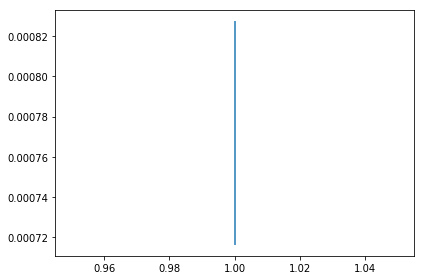

In [14]:
plt.errorbar([1],[np.mean(e1)],du1['err'])

In [9]:
mean_e1 = []
mean_e2 = []
for jj in range(1000):
    mask = jk!= jj
    mean_e1.append(np.mean(e1[mask]))
    mean_e2.append(np.mean(e2[mask]))
Bmean_e1 = np.array(mean_e1)
Bmean_e2 = np.array(mean_e2)

In [12]:
du1 = covariance_scalar_jck(Bmean_e1,1000,'jackknife')
print du1['err']

du2 = covariance_scalar_jck(Bmean_e2,1000,'jackknife')
print du2['err']

5.5529993967760295e-05
5.3725458215266896e-05


In [7]:
idx = np.array(master['catalog']['metacal']['unsheared']['coadd_object_id'])[select_metacal]


jj_reg = np.array(master['regions']['catalog']['gold'][u'region'])[select_metacal]
id_gold = np.array(master['catalog']['gold']['coadd_object_id'])[select_metacal]

mask_id = np.in1d(id_gold,idx)

id_gold_match = id_gold[mask_id]
jj_reg_match = jj_reg[mask_id]
jk = jj_reg_match 

In [21]:
'{0:2.5f} + {1:2.5f}'.format(np.mean(e1)*10000,du1['err']*10000)

'7.71916 + 0.55530'

In [20]:
'{0:225f} + {1:2.2f}'.format(np.mean(e2)*10000,du2['err']*10000)

'                                                                                                                                                                                                                         1.724055 + 0.54'

In [ ]:
n_jck = 1000 #!!!!!!

def IndexToDeclRa(index, nside,ge=False,nest=False):
    theta,phi=hp.pixelfunc.pix2ang(nside ,index,nest)
    if ge:
        r = hp.rotator.Rotator(coord=['G','E'])
        theta, phi = r(theta,phi) 
    return -np.degrees(theta-np.pi/2.),np.degrees(phi)



    ipix = np.arange(0,npix)
    theta, phi = hp.pixelfunc.pix2ang(nside, ipix)
    ra, dec = to_ra_dec(theta,phi)
    kappa = map
    return ra,dec,kappa

def jaccknife_regions(ra,dec,number_of_regions,label_jck = None, centers_jck = None, v = False,size = 200000):
    new_cat=np.array(zip(ra, dec))
    A=new_cat[np.random.randint(new_cat.shape[0],size=size),:]
    
    if not v:
        centers_jck= kmeans_radec.kmeans_sample(A,number_of_regions,maxiter=100,tol=1e-05,verbose=0)
        np.savetxt(label_jck, centers_jck.centers)
        centers_tree = spatial.cKDTree(centers_jck.centers[:,[0,1]])
        _ , hpix= centers_tree.query(np.array(zip(ra,dec)))
        return centers_tree, hpix, centers_jck.centers[:,[0,1]]   
    
    centers_tree = spatial.cKDTree(centers_jck[:,[0,1]])
    _ , hpix= centers_tree.query(np.array(zip(ra,dec)))
    return centers_tree, hpix, centers_jck[:,[0,1]]

# define jackknife regions **********************

mask # footprint
area = np.array(range(hp.nside2npix(nside)))[mask]
dech,rah = IndexToDeclRa(area, nside)

label_jck= "./centers1000spn.txt"
if  os.path.exists(label_jck):
    centers=np.array(np.loadtxt(label_jck)) 
    centers_tree, hpix, centers = jaccknife_regions(rah,dech,n_jck,label_jck, centers, v = True)
else:
    centers_tree, hpix, centers = jaccknife_regions(rah,dech,n_jck,label_jck)

# hpix is the JK of each healpy pixel.

In [24]:
TT = 20
xmm = np.mean(sample_dict['psf_e2'][maskj])

mask = (sample_dict['psf_e2']>-0.03) &  (sample_dict['psf_e2']<0.03)
x = sample_dict['psf_e2'][mask]
y = sample_dict['e2'][mask]

vec = np.zeros(TT)

bound = [np.quantile(x,1.*(i*1)/TT) for i in range(TT+1)]
vec = [np.mean(y[(x>bound[i])&(x<bound[i+1])]) for i in range(TT)]
err = [np.std(y)/np.sqrt(len(y[(x>bound[i])&(x<bound[i+1])])) for i in range(TT)]
err_l = [np.std(y[(x>bound[i])&(x<bound[i+1])])/np.sqrt(len(y[(x>bound[i])&(x<bound[i+1])])) for i in range(TT)]

x0 = (np.array(bound[1:])+np.array(bound[:-1]))*0.5
mut = np.polyfit(sample_dict['psf_e2'][maskj]-np.mean(sample_dict['psf_e2'][maskj]),sample_dict['e2'+kk][maskj],1,cov =True)

e2_y3 = {'bound':bound,'vec':vec,'err':err,'x0':x0,'mut':mut,'xmm':xmm}

